# Approximate Bayesian Computation for Cospectra with Variability (and dead time)

We don't know what the likelihood is for cospectra with variability, because there's no known closed-form solution for the sum of correlated variables that are drawn from a variance-gamma distribution.

So, can we do this using Approximate Bayesian Computation instead? Let's give this a try! First, we're going to do this without dead time. 

In this notebook, we're going to attempt to accurately measure the fractional rms amplitude of a QPO.

## Imports


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib notebook
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("whitegrid")

import numpy as np
import mpmath
import pandas as pd
from tqdm import tnrange, tqdm_notebook

import scipy.stats
import scipy.special
import scipy.fftpack
from tqdm import tqdm_notebook, tnrange 

from stingray import Lightcurve, Crossspectrum, Powerspectrum
from stingray.simulator.simulator import Simulator

import warnings
warnings.filterwarnings('ignore')

from astropy.modeling import models
from stingray.modeling import PSDLogLikelihood, PSDParEst

import astroabc

## The Probability Distributions for Cospectra

I'm going to need the functions for the almost-correct distributions, so let's put them here.

The first is the probability density of a variable $Z = XY$, where $X$ and $Y$ are zero-mean, normally distributed random variables that are correlated.

The second describes the variable $Q = Z_1 + Z_2 + ... + Z_n$ for $n$ variables, where each is the product of two zero-mean, normally distributed random variables that are correlated. **Note, however, that the $Z_i$ are assumed to be independent and identically distributed!**

This indicates that the second distribution will not be appropriate for the cospectrum, because in the cospectrum all four Fourier amplitude components are correlated among one another for any power spectral shape other than white noise.



In [4]:
def bessel_probability(x, sigmax, sigmay, rho):
    """
    Probability distribution for the product of two 
    correlated variables.
    
    Parameters
    ----------
    x : float
        The variable for which to calculate the probability
        
    sigmax, sigmay : float
        The standard deviation of the two zero-mean normal
        random variables that make up the product
        
    rho : float in [0,1]
        The correlation between the two zero-mean normal 
        random variables that make up the product
    
    Returns
    -------
    prob : float in [0,1]
        The probability density at position `x`
    
    """
    sigmaboth = sigmax * sigmay
    rho_term = 1. - rho**2.
    
    first_term = 1. / (np.pi * sigmaboth * np.sqrt(rho_term))
    
    second_term = np.exp(rho * x / (sigmaboth * rho_term))
    
    bessel_term = np.abs(x) / (sigmaboth * rho_term)
    order = 0
    third_term = scipy.special.kv(order, bessel_term)
    prob = first_term * second_term * third_term
    return prob

def variance_gamma(x, std1, std2, rho, n=2):
    """
    Calculate the probability density for a variable 
    that is the mean of $n$ random variables, where 
    each is the product of two correlated, zero-mean 
    normal random variables
    
    Parameters
    ----------
    x : float
        The variable for which to calculate the probability
        
    std1, std2 : float
        The standard deviation of the two zero-mean normal
        random variables that make up the product
        
    rho : float in [0,1]
        The correlation between the two zero-mean normal 
        random variables that make up the product
    
    n : int, must be >= 2
        The number of random numbers that were averaged in `x`
    
    Returns
    -------
    prob : float in [0,1]
        The probability density at position `x`

    """
    sigma_both = std1 * std2
    rho_coeff = (1 - rho**2.)
    x_abs = np.abs(x)
    
    first_term_nom = (n+1)/2 * np.log(n) + (1-n)/2. * np.log(2) + (n-1)/2. *  np.log(x_abs)
    first_term_denom = ((n+1)/2.)*np.log(sigma_both) + 0.5 * np.log(np.pi * rho_coeff) + scipy.special.gammaln(n/2.)
    
    first_term = first_term_nom - first_term_denom
    
    second_term = rho * n * x / (sigma_both * rho_coeff)
    
    log_bessel_arg = np.log(n) + np.log(x_abs) -  np.log(sigma_both) - np.log(rho_coeff)
    order = (n - 1) / 2.
    
    third_term = np.log(scipy.special.kv(order, np.exp(log_bessel_arg)))
    
    tt_mask = (np.isfinite(third_term))
    
    for i in np.arange(0, len(tt_mask), 1, dtype=int)[~tt_mask]:
        third_term[i] = np.float(mpmath.log(mpmath.besselk(order, np.exp(log_bessel_arg[i]))))
    
    prob = np.exp(first_term + second_term + third_term)
    return prob

## Generating a Test Data Set

Let's generate a data set we'll pretend is the "real" data. This will simulate a light curve with 2000 data points and a QPO at 10 Hz with a width of 2 Hz and an amplitude of, I dunno, 20.



In [5]:
qpo = models.Lorentz1D()# + models.Const1D()

In [6]:
qpo.param_names

('amplitude', 'x_0', 'fwhm')

In [7]:
qpo_amp = 1.0
qpo_x0 = 200.0
qpo_fwhm = 20.0

true_pars = [qpo_amp, qpo_x0, qpo_fwhm]

qpo.amplitude = qpo_amp
qpo.x_0 = qpo_x0
qpo.fwhm = qpo_fwhm


In [8]:
true_rms = 0.2
true_mean = 1000.0

In [9]:
npoints = 2000 # number of data points
dt = 0.001 # time step

tseg = dt * npoints
df = 1.0/tseg
fmax = 0.5/dt

freq = np.linspace(df, fmax, num=npoints//2)

In [10]:
mspec_true = qpo(freq)

<IPython.core.display.Javascript object>


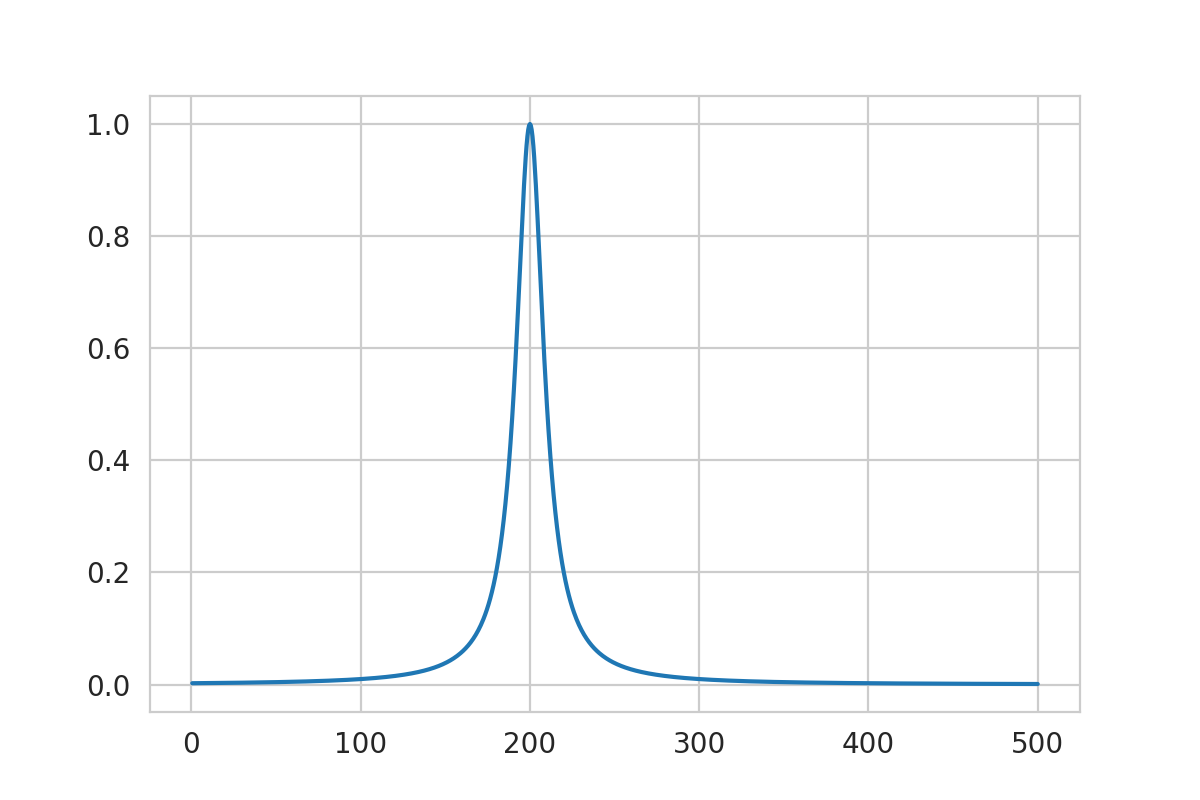

In [11]:
fig, ax = plt.subplots(1,1, figsize=(6,4))

ax.plot(freq, mspec_true)

Okay, cool, now we can put that into the simulator:

In [12]:
# set the random state for reproducibility
rng = np.random.RandomState(1000) 

# set up the Simulator object.
sim = Simulator(dt=dt, N=npoints, mean=true_mean, rms=true_rms, random_state=rng)

#print(i)
lc = sim.simulate(mspec_true)

counts1 = rng.poisson(lc.counts)
counts2 = rng.poisson(lc.counts)

lc1_true = Lightcurve(lc.time, counts1)
lc2_true = Lightcurve(lc.time, counts2)

lc_sum_true = lc1_true + lc2_true

ps_true = Powerspectrum(lc_sum_true, norm="frac")
ps1_true = Powerspectrum(lc1_true, norm="frac")
ps2_true = Powerspectrum(lc2_true, norm="frac")

cs_true = Crossspectrum(lc1_true, lc2_true, norm="frac")

Let's plot the result:

<IPython.core.display.Javascript object>


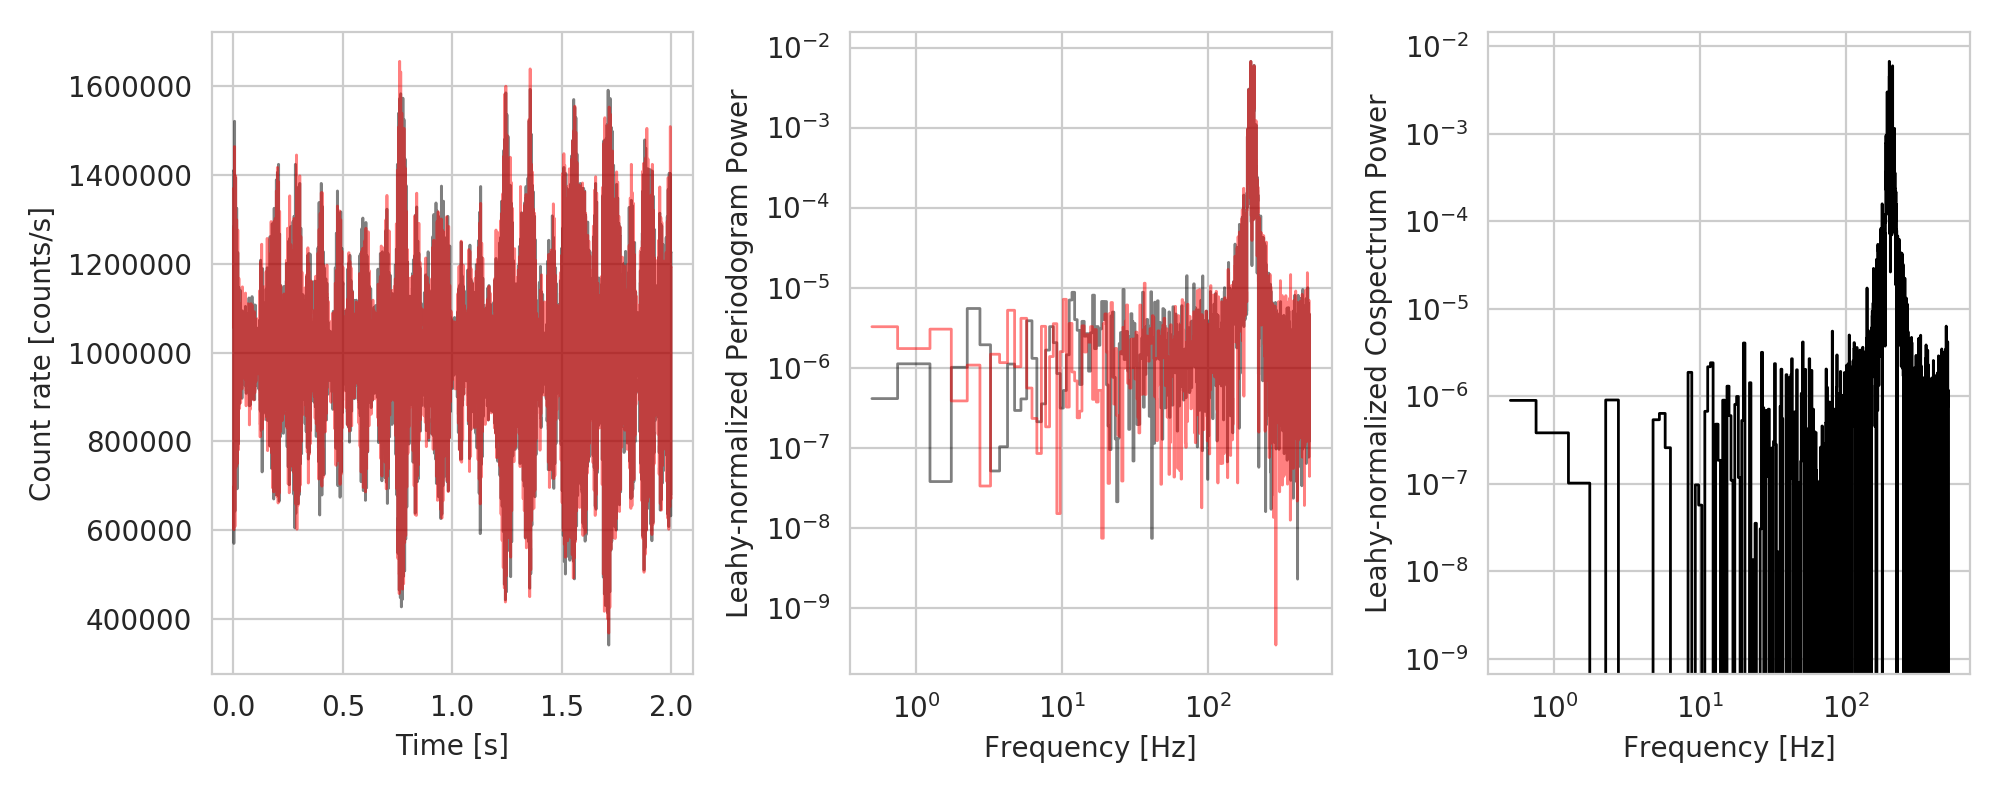

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 4))

ax1.plot(lc1_true.time, lc1_true.countrate, lw=1, color="black", 
         linestyle="steps-mid", alpha=0.5)
ax1.plot(lc2_true.time, lc2_true.countrate, lw=1, color="red", 
         linestyle="steps-mid", alpha=0.5)

ax1.set_xlabel("Time [s]")
ax1.set_ylabel("Count rate [counts/s]")

ax2.loglog(ps1_true.freq, ps1_true.power, lw=1, color="black", 
           linestyle="steps-mid", alpha=0.5)
ax2.loglog(ps2_true.freq, ps2_true.power, lw=1, color="red", 
           linestyle="steps-mid", alpha=0.5)
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Leahy-normalized Periodogram Power")

ax3.loglog(cs_true.freq, cs_true.power, lw=1, color="black", linestyle="steps-mid")
ax3.set_xlabel("Frequency [Hz]")
ax3.set_ylabel("Leahy-normalized Cospectrum Power")

plt.tight_layout()

Let's fit a model to the periodogram:

In [14]:
qpo_const = models.Lorentz1D() + models.Const1D()

[8.65721762e-03 2.01180095e+02 2.97917203e+00 4.49667643e-07]


<IPython.core.display.Javascript object>


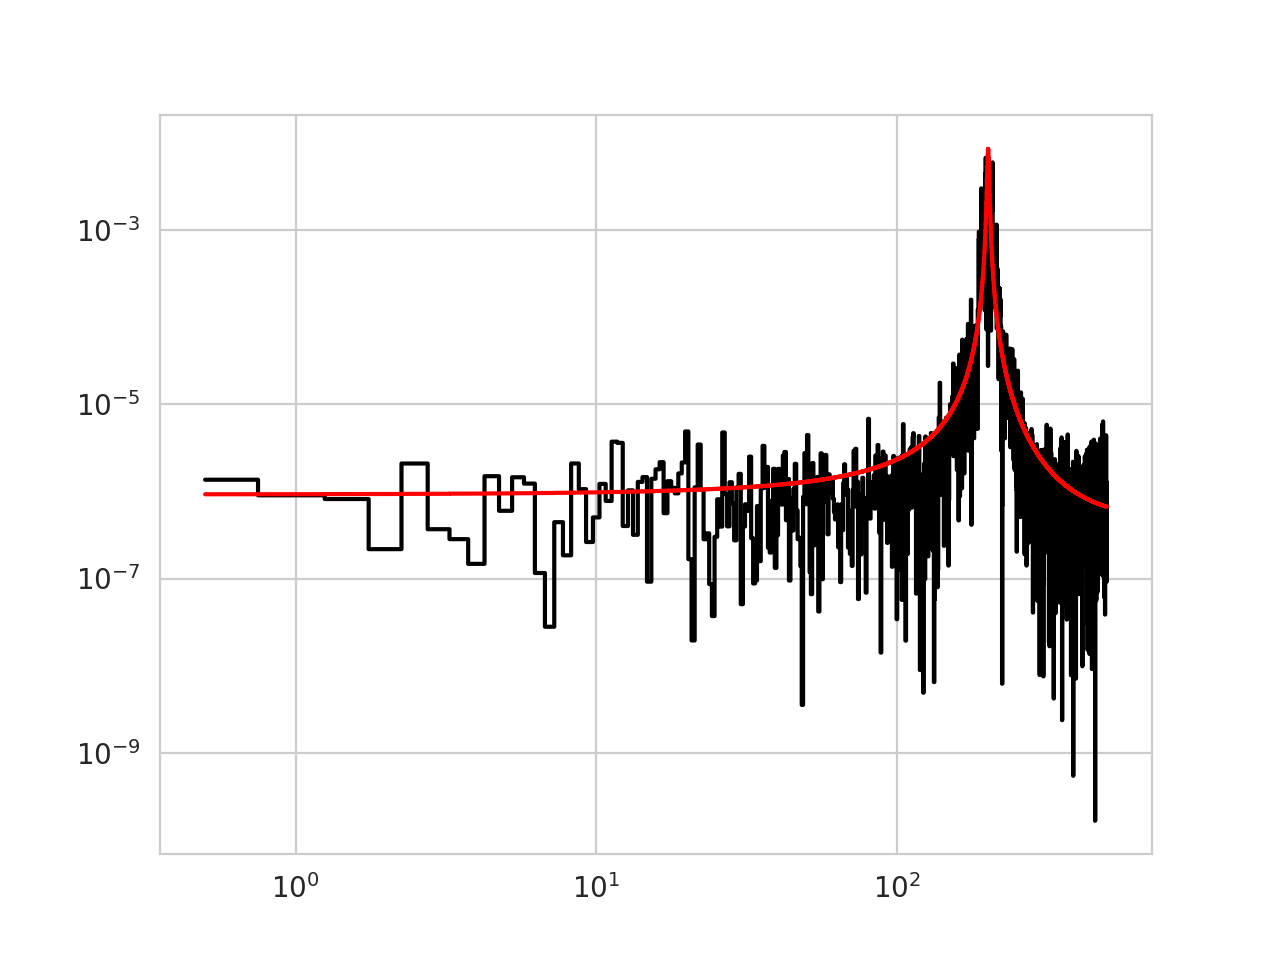

In [15]:
loglike = PSDLogLikelihood(ps_true.freq, ps_true.power, model=qpo_const, m=ps_true.m)
parest = PSDParEst(ps_true, max_post=False, fitmethod='powell')

res = parest.fit(loglike, [8e-3, 200, 20, 5e-7])

print(res.p_opt)

plt.figure()
plt.loglog(ps_true.freq, ps_true.power, linestyle="steps-mid", color="black")
plt.loglog(ps_true.freq, res.mfit, linestyle="steps-mid", color="red")

In [16]:
np.sqrt(np.sum(res.mfit*ps_true.df))

0.20143886228642902

In [17]:
lor = models.Lorentz1D(amplitude=res.p_opt[0], x_0=res.p_opt[1], fwhm=res.p_opt[2])(freq)
const = models.Const1D(amplitude=res.p_opt[3])(freq)

Let's calculate the fractional rms amplitude:

In [18]:
minind = ps_true.freq.searchsorted(50)
maxind = ps_true.freq.searchsorted(350)

print(np.sum(ps_true.power[minind:maxind])*ps_true.df)

0.040381714956489845


What's the fractional rms amplitude of just the QPO?

In [19]:
np.sqrt(np.sum(ps_true.power[minind:maxind]*ps_true.df))

0.2009520215287466

What's the fractional rms amplitude of the entire light curve?

In [20]:
np.std(lc_sum_true.counts)/np.mean(lc_sum_true.counts)

0.2014396704646622

Okay, that looks reasonable. Let's make a distribution of fractional rms amplitudes from a bunch of simulated spectra, just so that I have some idea of what the spread should look like:

In [20]:
nsims = 10000

frac_qpo_all = np.zeros(nsims)


# set the random state for reproducibility
rng = np.random.RandomState(2000) 

for i in tnrange(nsims):

    #print(i)
    lc = sim.simulate(mspec_true)

    try:
        counts1 = rng.poisson(lc.counts)
        counts2 = rng.poisson(lc.counts)

        lc1_sim = Lightcurve(lc.time, counts1)
        lc2_sim = Lightcurve(lc.time, counts2)

        lc_sim = lc1_sim + lc2_sim

        ps_sim = Powerspectrum(lc_sim, norm="frac")

        frac_qpo_all[i] = np.sqrt(np.sum(ps_sim.power[minind:maxind]*ps_sim.df))
    except ValueError:
        continue


KeyboardInterrupt: 

Let's plot a histogram of all the fractional amplitudes:

<IPython.core.display.Javascript object>


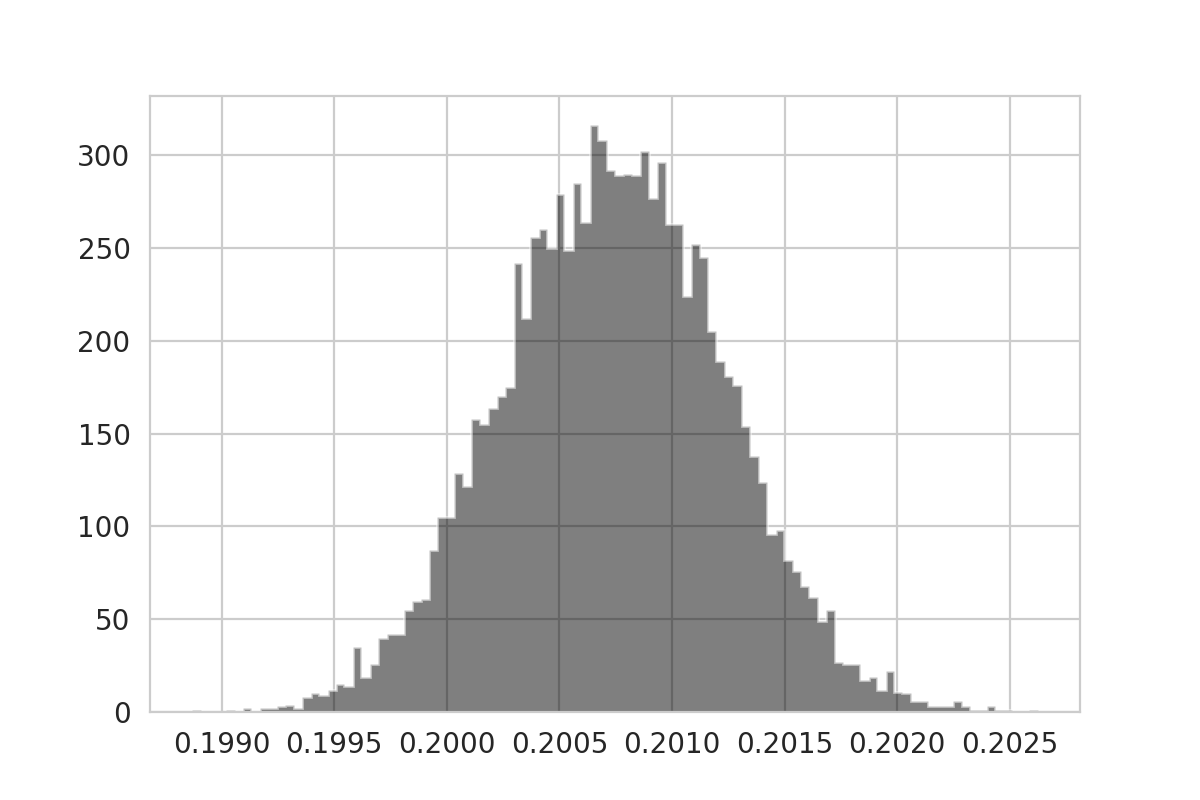

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.hist(frac_qpo_all[frac_qpo_all>0], bins=100, histtype="stepfilled", color="black", alpha=0.5);

Okay, so I think I'm doing this right now: I've got a QPO that is 20% rms amplitude, and I've added some white noise, such that the total variance in the light curve is larger. 

I'm interested that there seems to be a small bias towards higher numbers here: why is that?


### MCMC with the Periodogram

I want to do some MCMC for the periodogram, so that I know what the posterior for the power law index should look like.

First, I need to define a posterior object and some priors:




In [21]:
from stingray.modeling import PSDPosterior, set_logprior

lpost = PSDPosterior(ps_true.freq, ps_true.power, model=qpo_const, m=ps_true.m)

qpo_const.param_names

('amplitude_0', 'x_0_0', 'fwhm_0', 'amplitude_1')

In [22]:

amp_prior = scipy.stats.uniform(1e-10, 100).pdf
x0_prior = scipy.stats.uniform(1, 1000).pdf
fwhm_prior = scipy.stats.uniform(0.001, 1000).pdf

wn_prior = scipy.stats.uniform(1e-20, 1e5).pdf

priors = {"amplitude_0": amp_prior,
          "x_0_0": x0_prior,
          "fwhm_0": fwhm_prior,
          "amplitude_1": wn_prior}

lpost.logprior = set_logprior(lpost, priors)

Now we can set up the sampling:

[9.66075821e-03 2.01183555e+02 2.83045988e+00 4.34346971e-07]
[[-2.98680387e-05 -5.36257688e-07  4.40903749e-03 -5.98190549e-21]
 [-5.36257687e-07 -1.22049341e-01  1.34835938e-04  1.42503526e-20]
 [ 4.40903749e-03  1.34835937e-04 -6.54305846e-01  8.83027538e-19]
 [-5.97360774e-21 -1.07251538e-22  8.81807497e-19 -5.96046448e-26]]


<IPython.core.display.Javascript object>


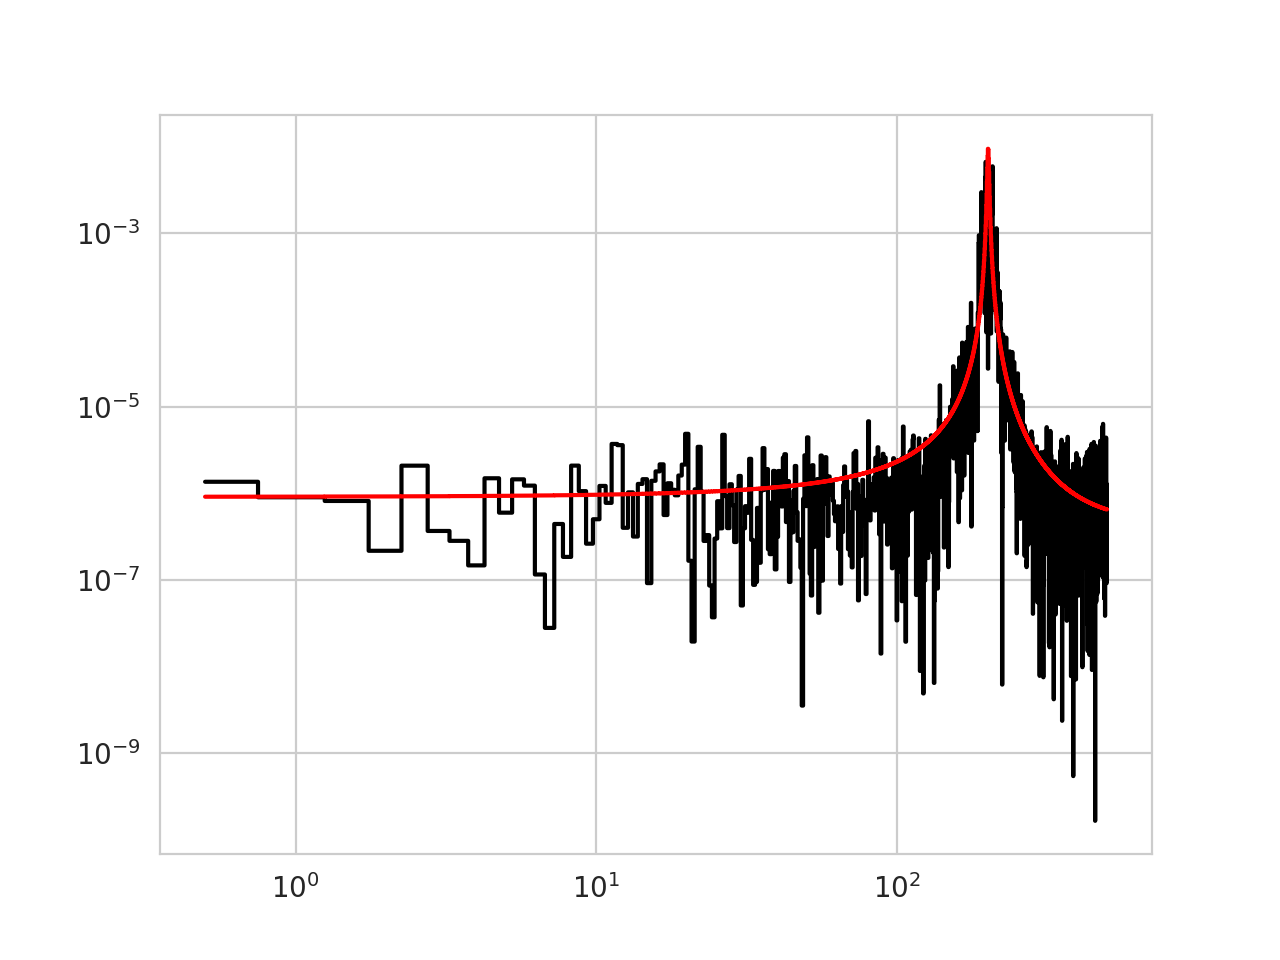

In [43]:
parest = PSDParEst(ps_true, max_post=True, fitmethod='powell')

res = parest.fit(lpost, [1e-3, 200, 20, 5e-7])

print(res.p_opt)
print(res.cov)

plt.figure()
plt.loglog(ps_true.freq, ps_true.power, linestyle="steps-mid", color="black")
plt.loglog(ps_true.freq, res.mfit, linestyle="steps-mid", color="red")

Here's the actual sampling step:

-- The acceptance fraction is: 0.370480.5
-- The acceptance fraction is: 0.370480.5
-- The acceptance fraction is: 0.370480.5
INFO:MCMC summary:-- The acceptance fraction is: 0.370480.5
R_hat for the parameters is: [8.20521130e-05 1.23150643e-01 4.45048211e-01 1.65656959e-15]
R_hat for the parameters is: [8.20521130e-05 1.23150643e-01 4.45048211e-01 1.65656959e-15]
R_hat for the parameters is: [8.20521130e-05 1.23150643e-01 4.45048211e-01 1.65656959e-15]
INFO:MCMC summary:R_hat for the parameters is: [8.20521130e-05 1.23150643e-01 4.45048211e-01 1.65656959e-15]
-- Posterior Summary of Parameters: 

-- Posterior Summary of Parameters: 

-- Posterior Summary of Parameters: 

INFO:MCMC summary:-- Posterior Summary of Parameters: 

parameter 	 mean 		 sd 		 5% 		 95% 

parameter 	 mean 		 sd 		 5% 		 95% 

parameter 	 mean 		 sd 		 5% 		 95% 

INFO:MCMC summary:parameter 	 mean 		 sd 		 5% 		 95% 

---------------------------------------------

---------------------------------------------

<IPython.core.display.Javascript object>


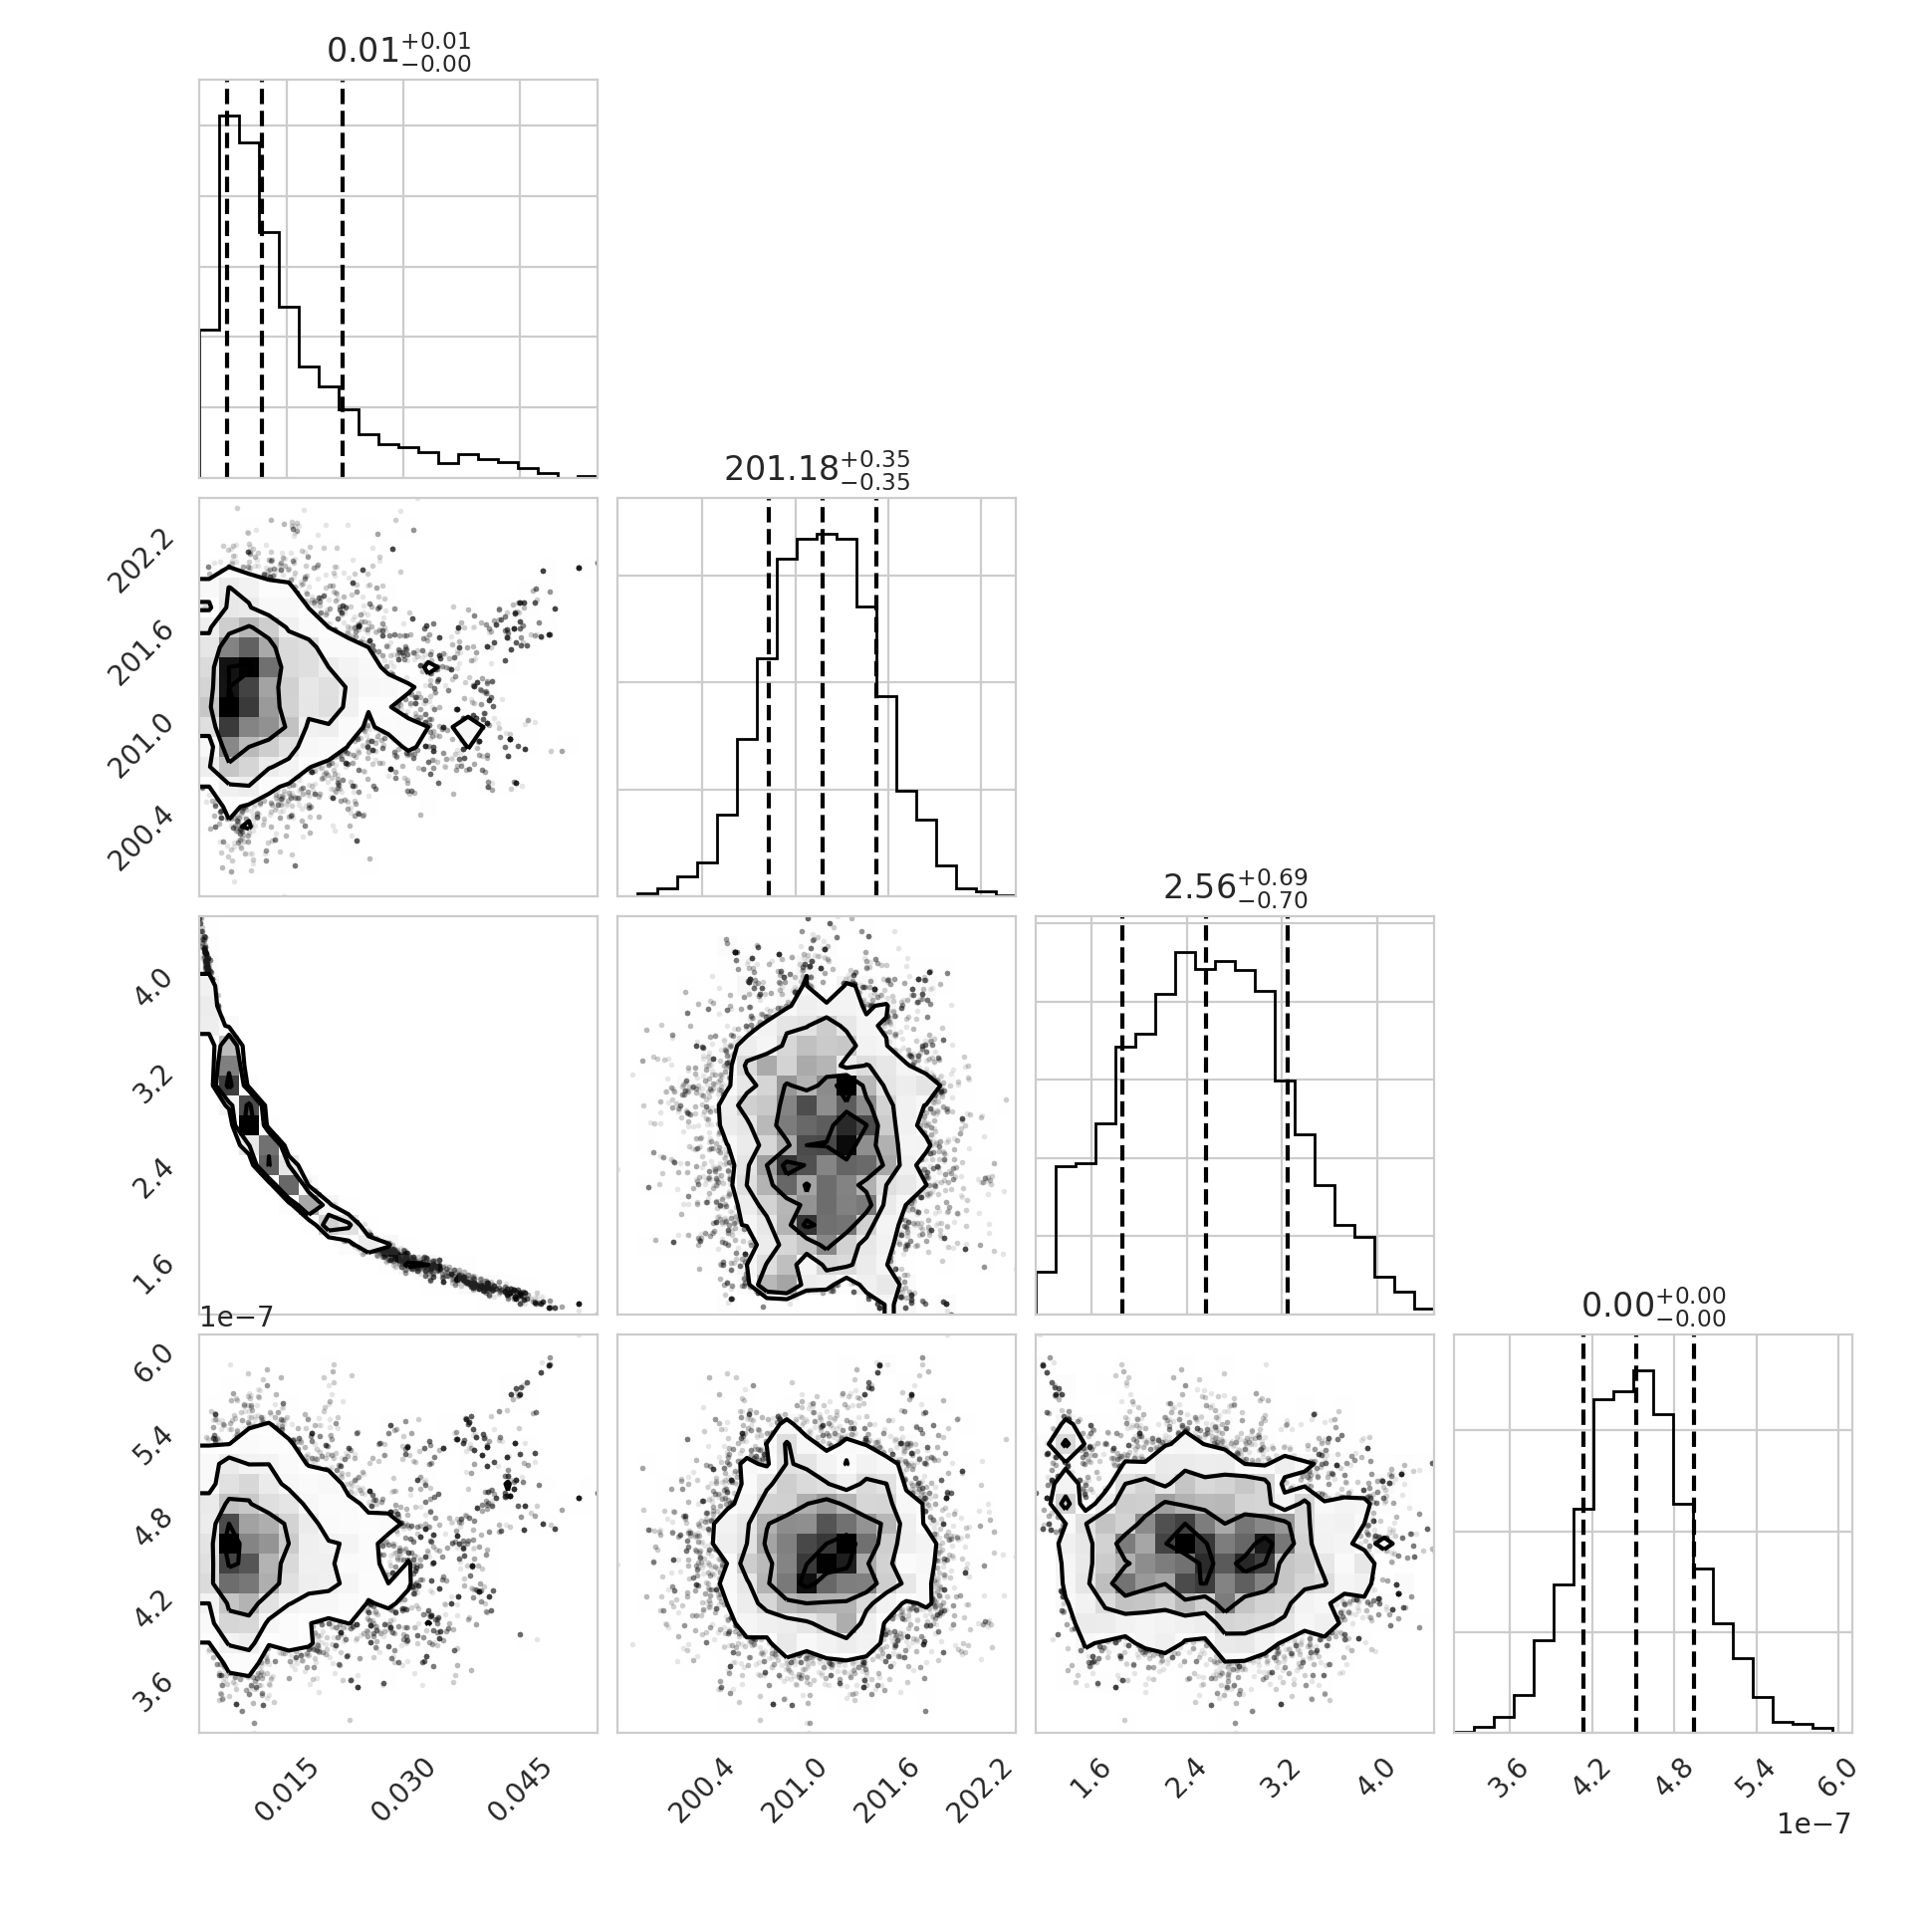

<IPython.core.display.Javascript object>


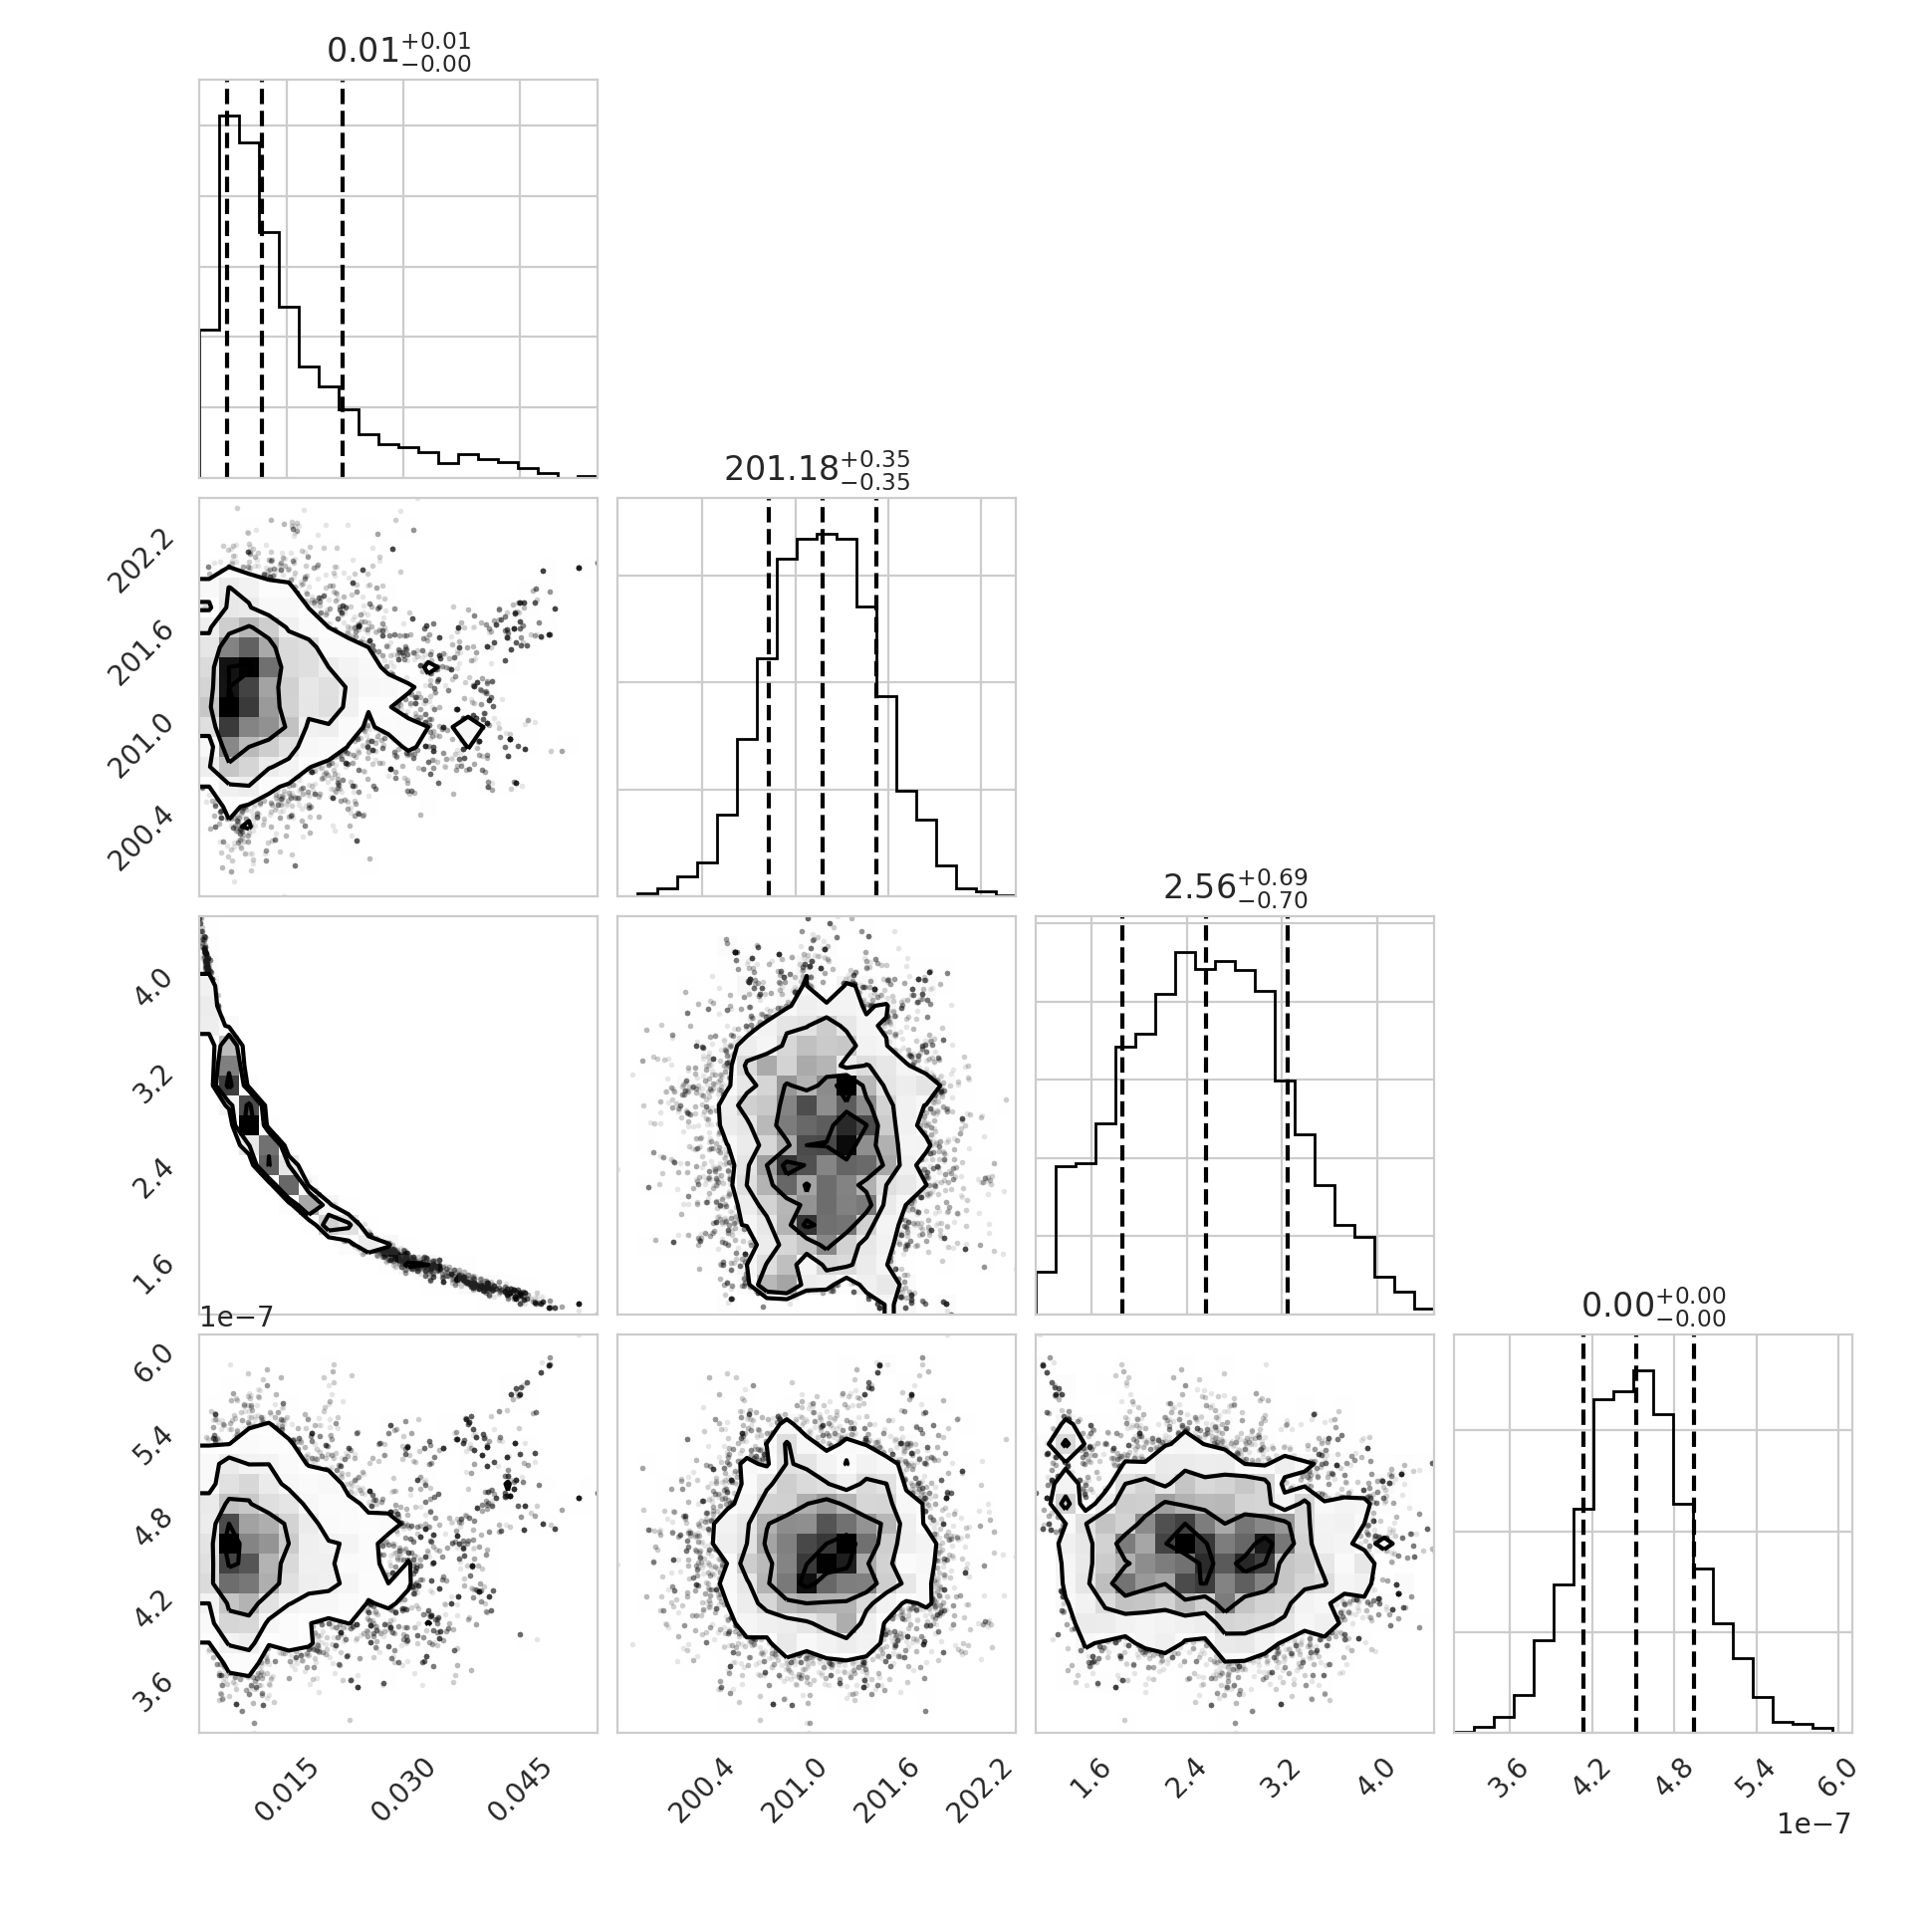

In [41]:
sample_res = parest.sample(lpost, res.p_opt, cov=np.diag(np.diag(res.cov)), nwalkers=50, niter=500, 
                           burnin=1000, threads=1)

sample_res.plot_results()

### Basic Rejection sampling

Let's do rejection sampling on one parameter only, the power law index. 

For this, let's set up the simulator:

In [44]:
def simulate_csd(sim, mspec):
    """
    Function to simulate cospectra, given a 
    Simulator object and a power law index.
    
    Parameters
    ----------
    pl_idx : float
        The power law index for the model
        
    sim : stingray.simulation.Simulator object
        A simulator object to simulate the periodogram
    """
    lc = sim.simulate(mspec)
    
    mask = (lc.counts < 0.0)
    lc.counts[mask] = 0.0

    counts1 = rng.poisson(lc.counts)
    counts2 = rng.poisson(lc.counts)

    lc1 = Lightcurve(lc.time, counts1)
    lc2 = Lightcurve(lc.time, counts2)

    lc_sum = lc1 + lc2

    ps = Powerspectrum(lc_sum, norm="frac")
    ps1 = Powerspectrum(lc1, norm="frac")
    ps2 = Powerspectrum(lc2, norm="frac")

    cs_sim = Crossspectrum(lc1, lc2, norm="frac")
    
    return ps, cs_sim

Let's try this:

<IPython.core.display.Javascript object>


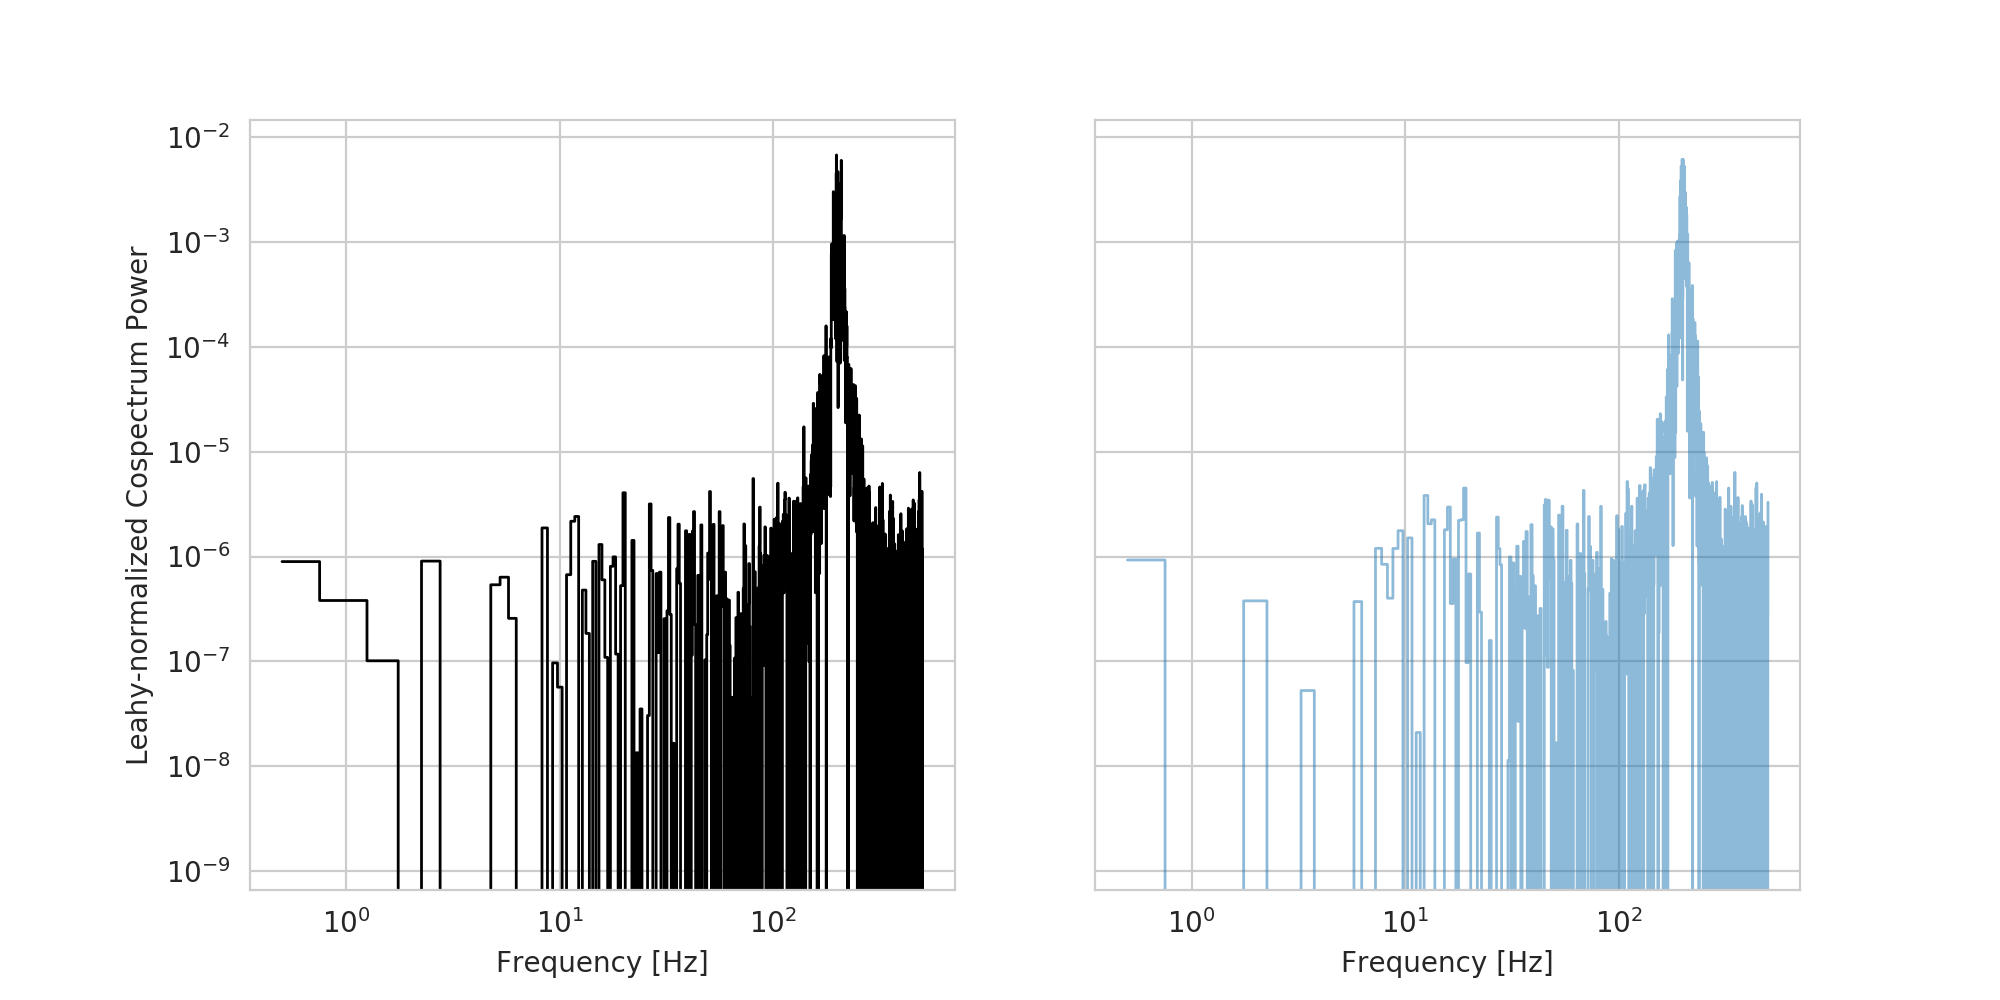

Text(0.5, 0, 'Frequency [Hz]')

In [45]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharey=True, sharex=True)

ax1.loglog(cs_true.freq, cs_true.power, lw=1, color="black", linestyle="steps-mid")
ax1.set_xlabel("Frequency [Hz]")
ax1.set_ylabel("Leahy-normalized Cospectrum Power")


ps_sim, cs_sim = simulate_csd(sim, mspec_true)
ax2.loglog(cs_sim.freq, cs_sim.power, lw=1, linestyle="steps-mid", alpha=0.5)

ax2.set_xlabel("Frequency [Hz]")

## Distances and Summary Statistics

Okay, since that seems to work, now let's set up rejection sampling. 

For a distance metric, let's try a simple Euclidean distance. 

In [46]:
def euclidean_distance(x, y, weights="obs"):
    """
    Euclidean distance between the summaries of an observed 
    data set and a simulated data set. Because these summaries 
    can be on very different scales, and some of these summaries 
    might be tied to different parameters, it is possible that the 
    unweighted Euclidean distance allows certain parameters to be 
    better estimated than others (because the summary that helps 
    constrain the parameter has a much larger scale than the summary 
    tied to another parameter).
    
    In this case, re-weighting is useful. 
    
    Parameters
    ----------
    x : iterable
        The summaries of the observed data
        
    y : iterable
        The summaries of the simulated data
        
    weights : {None, "obs", or iterable of length x.shape}
        The weights to use in the Euclidean distance. If None, 
        no weights are applied. If "obs" (default), then the 
        difference between each summary is re-weighted by the 
        value of the summaries of the observed data. 
        If an iterable, assume that the input is a list or array 
        of weights to apply directly.
    
    """
    if weights is None:
        weights = np.ones_like(x)
    elif weights == "obs":
        weights = x
    elif isinstance(weights, iterable):
        weights = np.array(weights)
    else:
        raise ValueError("weights are not of a recognized type.")
        
    return np.sqrt(np.sum(((x - y)/weights)**2.))

def abs_distance(x, y):
    return np.sum(np.abs(x-y))

Okay, so assuming  Euclidean distance, I still need to decide on some summary statistics.

For this, I'm going to look at three things:
* the integrated rms between 100 and 300 Hz
* the maximum power in the periodogram (above the zeroth frequency)
* Given the maximum power, what's the width of that Lorentzian, i.e. some measure of the FWHM

I think the first and second are pretty straightforward. For the third, I think I want to find the "percentiles" of my periodogram: because the fractional rms normalization is defined in a way that the integral of the periodogram is a measure of the rms amplitude, I think I can look for the percentile containing 10%, 20%, 50% etc of the total variance in the light curve. **Important note**: This assumes that the variance due to white noise is small compared to the variance of the QPO. This may or may not be true in reality (but we can test that out as well!).

For this, we're first going to look at the cumulative sum of the powers:

<IPython.core.display.Javascript object>


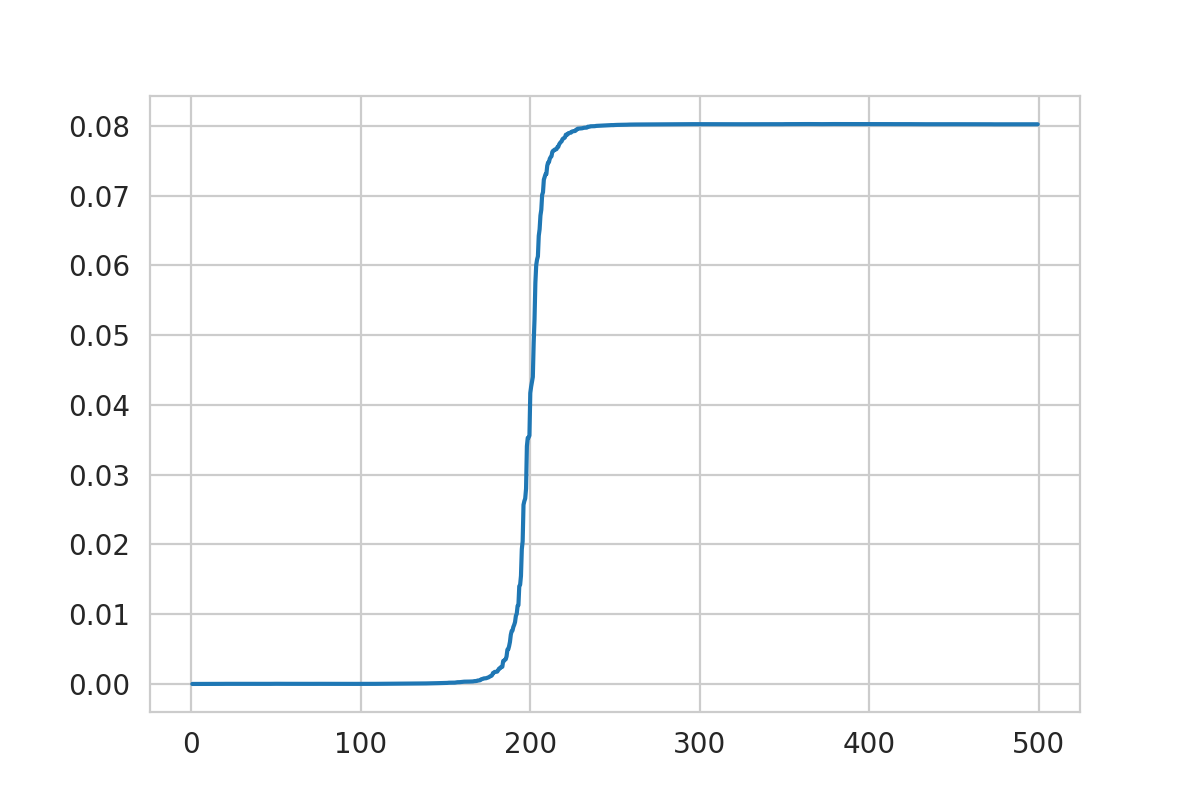

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))


ax.plot(cs_sim.freq, np.cumsum(cs_sim.power))

In [51]:
# store cumulative sum in an array
power_cumsum = np.cumsum(cs_sim.power)

# get the range of the cumulative sum: i.e. what's the smallest/largest value:
power_range = np.max(power_cumsum) - np.min(power_cumsum)

In [52]:
np.sqrt(power_range * cs_sim.df)

0.20032543265348982

Hey, the square root of that range multiplied by the frequency resolution recovers (mostly) the rms amplitude of the QPO. Sweet! Now we can look for percentiles:

In [53]:
percentiles = [0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]

percentile_freq = []

for p in percentiles:
    idx = power_cumsum.searchsorted(power_range*p)
    percentile_freq.append(cs_sim.freq[idx])

<IPython.core.display.Javascript object>


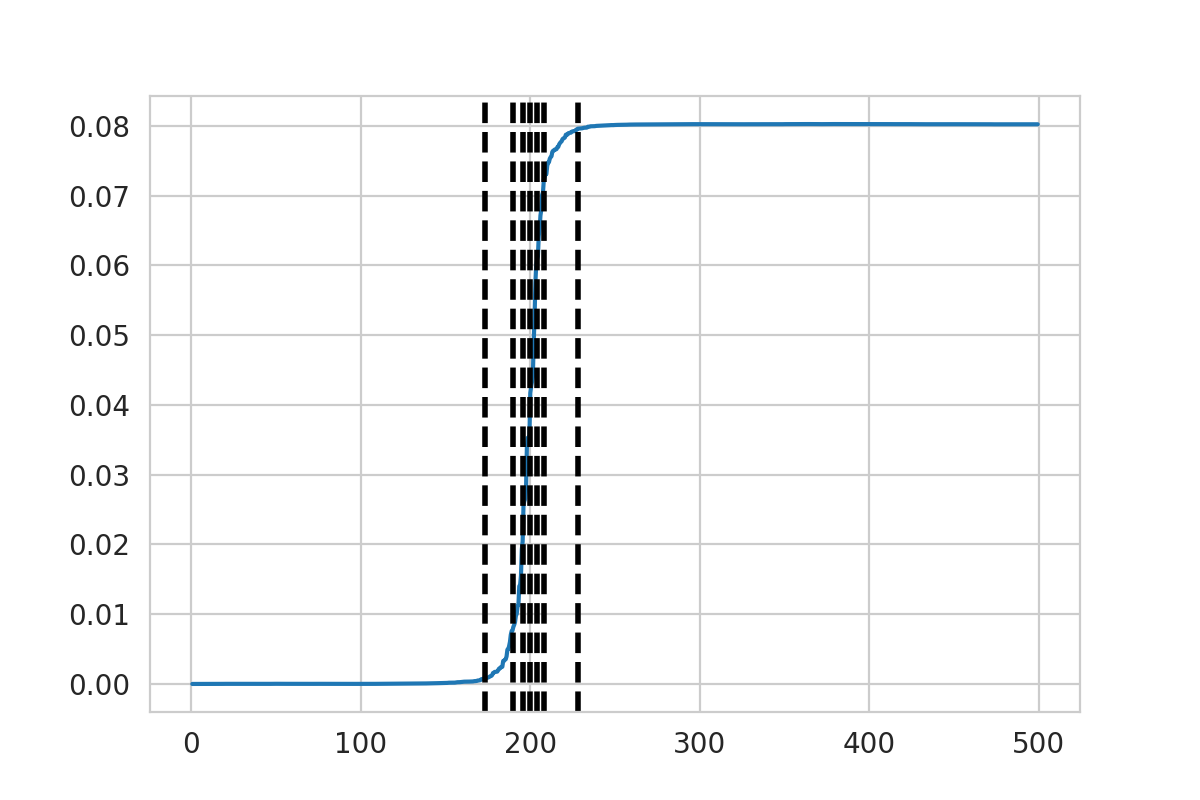

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))


ax.plot(cs_sim.freq, np.cumsum(cs_sim.power))
for pf in percentile_freq:
    ax.axvline(pf, lw=2, color="black", linestyle="dashed")

What's the distance between the 0.25 and 0.75 percentiles?

Let's see whether those percentiles turn up in the actual PSD:

In [55]:
percentile_freq[5] - percentile_freq[1]

18.0

<IPython.core.display.Javascript object>


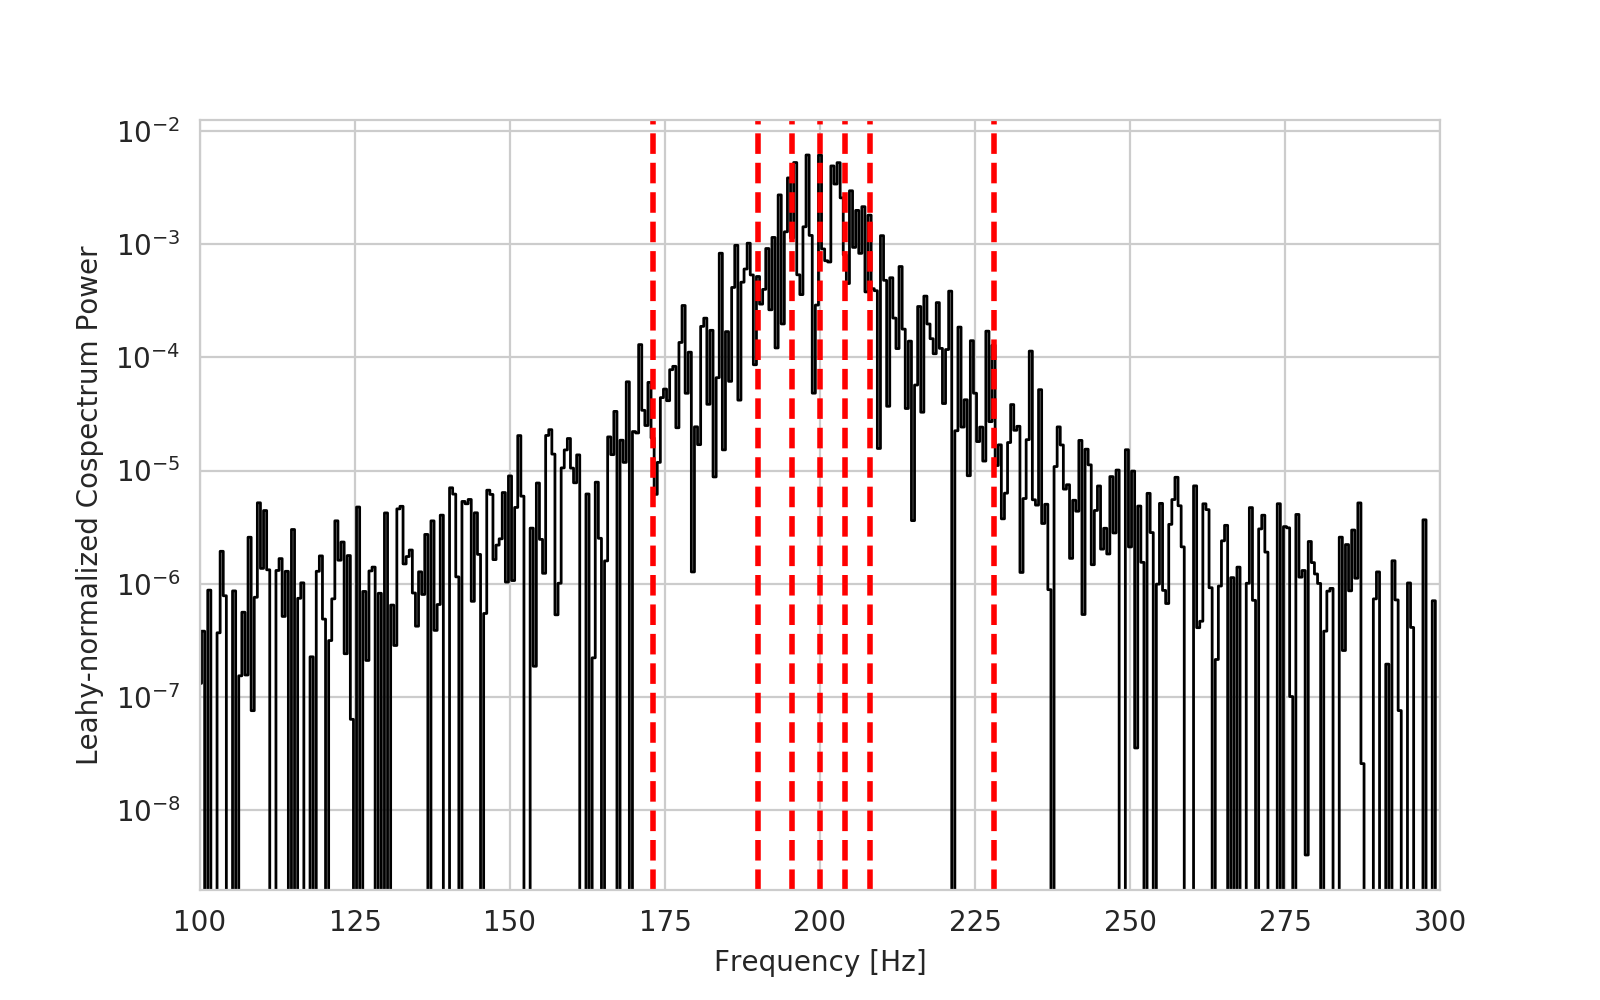

In [56]:
fig, (ax1) = plt.subplots(1, 1, figsize=(8,5), sharey=True, sharex=True)

ax1.semilogy(cs_sim.freq, cs_sim.power, lw=1, color="black", linestyle="steps-mid")
ax1.set_xlabel("Frequency [Hz]")
ax1.set_ylabel("Leahy-normalized Cospectrum Power")

ax1.set_xlim(100, 300)

for pf in percentile_freq:
    ax1.axvline(pf, lw=2, color="red", linestyle="dashed")

Okay, so based on that I think I'm going to include the *distances* between these percentiles as summary statistics.

I.e. I'm going to include the distance between the 0.75 and 0.25 percentile, as well as the distance between the 0.1 and 0.9 percentile, and the distance between the 0.01 and 0.99 percentile. 

Let's write a function that computes the statistics I'm interested in:

In [57]:
def compute_qpo_summaries(cs_sim, rms_boundaries=[100, 300], percentile_pairs=None, nmax=6):
    """
    Compute summary statistics for the QPO model.
    
    Current summary statistics:
        * total rms amplitude of the QPO (calculated as the total rms amplitude between 
          two frequencies given in `rms_boundaries`)
        * the total rms amplitude in the entire periodogram (corresponds to the variance 
          in the light curve)
        * the maximum power in the periodogram (calculated as the mean of the `nmax` highest 
          powers in the periodogram)
        * the frequency at which the maximum occurs (also calculated as the mean of the `nmax` 
          highest powers)
        * the difference between frequencies at which the periodogram contains a fraction 
          of $p$ of the total power (variance) in the light curve. I.e. for a pair of [0.1, 0.9], 
          the function will calculate the frequency at which the periodogram contains 10% of the 
          total variance, then the frequency at which the periodogram contains 90% of the total 
          variance (both counted from the zeroth frequency), and finally subtract the first from 
          the second to generate a difference. This is ideally a measure of the width of the 
          QPO, but crucially relies on there basically being just one QPO. 
    
    Parameters
    ----------
    cs_sim : stingray.Crossspectrum object
        The simulated CSD
        
    pars : iterable
        The list of input paramters that generated the simulated CSD
            
    rms_boundaries: iterable [min_boundary, max_boundary]
        The frequencies between which to integrate to compute the rms 
        of the QPO
    
    percentile_pairs : iterable of tuples, default: [[0.1, 0.9], [0.25, 0.75]]
        These pairs are used to calculate the difference in frequencies at which 
        different percentiles of the total variance are reached. 

    Returns
    -------
    summary : numpy.ndarray
        An array of summary statistics as defined above
    """
    
    
    # compute rms between 100 and 300 Hz. 
    minind = cs_sim.freq.searchsorted(rms_boundaries[0])
    maxind = cs_sim.freq.searchsorted(rms_boundaries[1])
    
    # compute the rms amplitude in QPO:
    rms_amp = np.sqrt(np.sum(cs_sim.power[minind:maxind]) * cs_sim.df )
    
    # compute the total rms amplitude in the PSD
    rms_tot = np.sqrt(np.sum(cs_sim.power) * cs_sim.df)
    
    # index of sorted array of powers
    sort_idx = np.argsort(cs_sim.power)[::-1]
    
    # compute the maximum power and frequency:
    maxpower = np.mean(cs_sim.power[sort_idx[:nmax]])
    maxfreq = np.mean(cs_sim.freq[sort_idx[:nmax]])
    
    # store cumulative sum in an array
    power_cumsum = np.cumsum(cs_sim.power)

    # compute percentiles:
    if percentile_pairs is None:
        percentile_pairs = [[0.1, 0.9], [0.25, 0.75]]

    # get the range of the cumulative sum: i.e. what's the smallest/largest value:
    
    percentile_diff = []
    for perc in percentile_pairs:
        pair = []
        for p in perc:
            idx = power_cumsum.searchsorted(power_range*p)
            if idx == len(cs_sim.freq):
                idx = -1
            pair.append(cs_sim.freq[idx])
        percentile_diff.append(pair[1] - pair[0])    
    
    summaries = np.hstack([maxpower, maxfreq, rms_amp, rms_tot, percentile_diff])

    #summaries = np.hstack([maxpower, maxfreq, rms_amp, percentile_diff])
    
    return summaries

Let's try this out!

In [58]:
cs_sim.power[np.argsort(cs_sim.power)[::-1]][:10]

array([0.00609736, 0.00608757, 0.00523392, 0.0052177 , 0.00488172,
       0.00382784, 0.00337859, 0.00294633, 0.00270935, 0.00255106])

In [59]:
compute_qpo_summaries(cs_sim, true_pars)

array([5.22435213e-03, 1.99000000e+02, 1.44389110e-01, 2.00266177e-01,
       1.80000000e+01, 8.50000000e+00])

I want to check whether my new method of calculating the maximum power and the frequency at which that maximum power is reached works as expected:

<IPython.core.display.Javascript object>


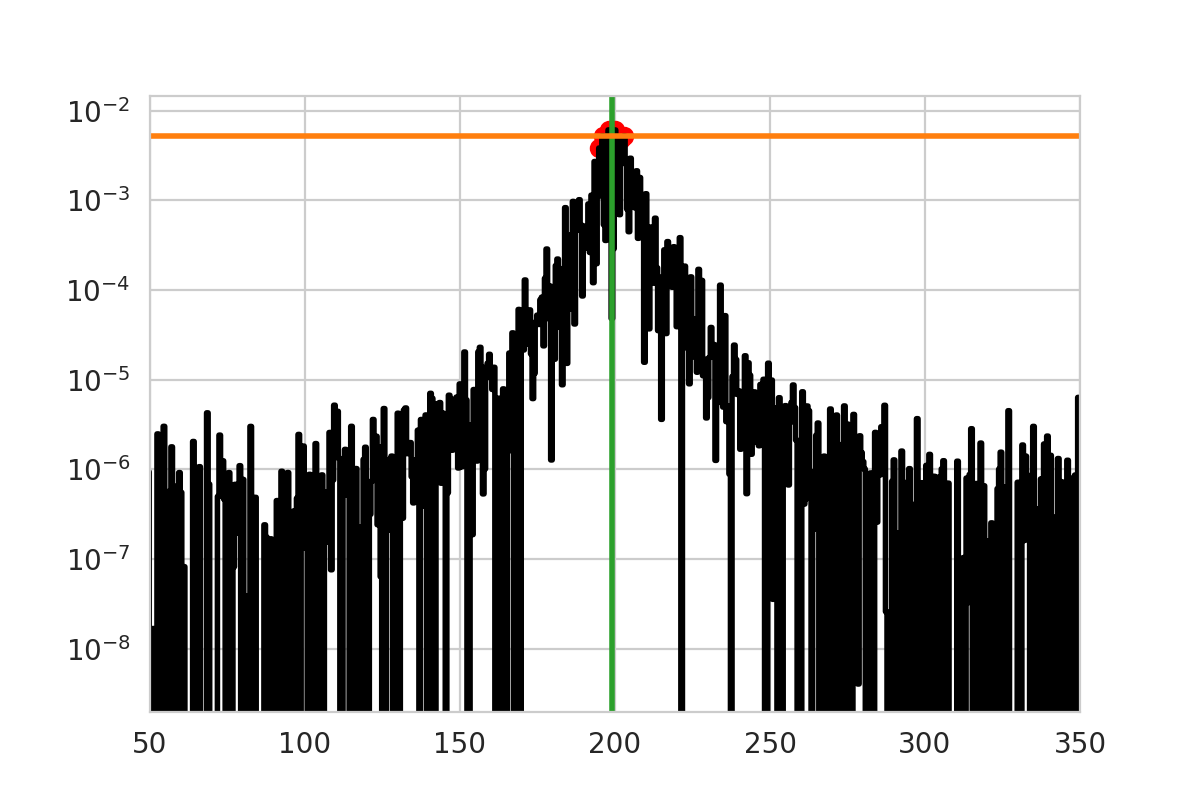

In [60]:
nmax = 6
# index of sorted array of powers
sort_idx = np.argsort(cs_sim.power)[::-1]

# compute the maximum power and frequency:
maxpower = np.mean(cs_sim.power[sort_idx[:nmax]])
maxfreq = np.mean(cs_sim.freq[sort_idx[:nmax]])


fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.semilogy(cs_sim.freq, cs_sim.power, linestyle="steps-mid", lw=2, color="black")
ax.set_xlim(50, 350)
ax.scatter(cs_sim.freq[sort_idx[:nmax]], cs_sim.power[sort_idx[:nmax]], color="red")

ax.axvline(maxfreq, lw=2, color=sns.color_palette()[2])
ax.axhline(maxpower, lw=2, color=sns.color_palette()[1])

Cool! It computes stuff! Let's take a look what the distribution of those summaries are for many simulations from the true parameters:

In [61]:
nsims = 10000

true_summaries = []
ps_sim_true, cs_sim_true = [], []

for i in tnrange(nsims):
    try:
        ps_sim, cs_sim = simulate_csd(sim, mspec_true)
        cs_sim_true.append(cs_sim)
        ps_sim_true.append(ps_sim)
        summaries = compute_qpo_summaries(cs_sim, true_pars)
        true_summaries.append(summaries)

    except ValueError:
        continue

In [62]:
true_summaries = np.array(true_summaries)

In [63]:
true_summaries.shape

(10000, 6)

<IPython.core.display.Javascript object>


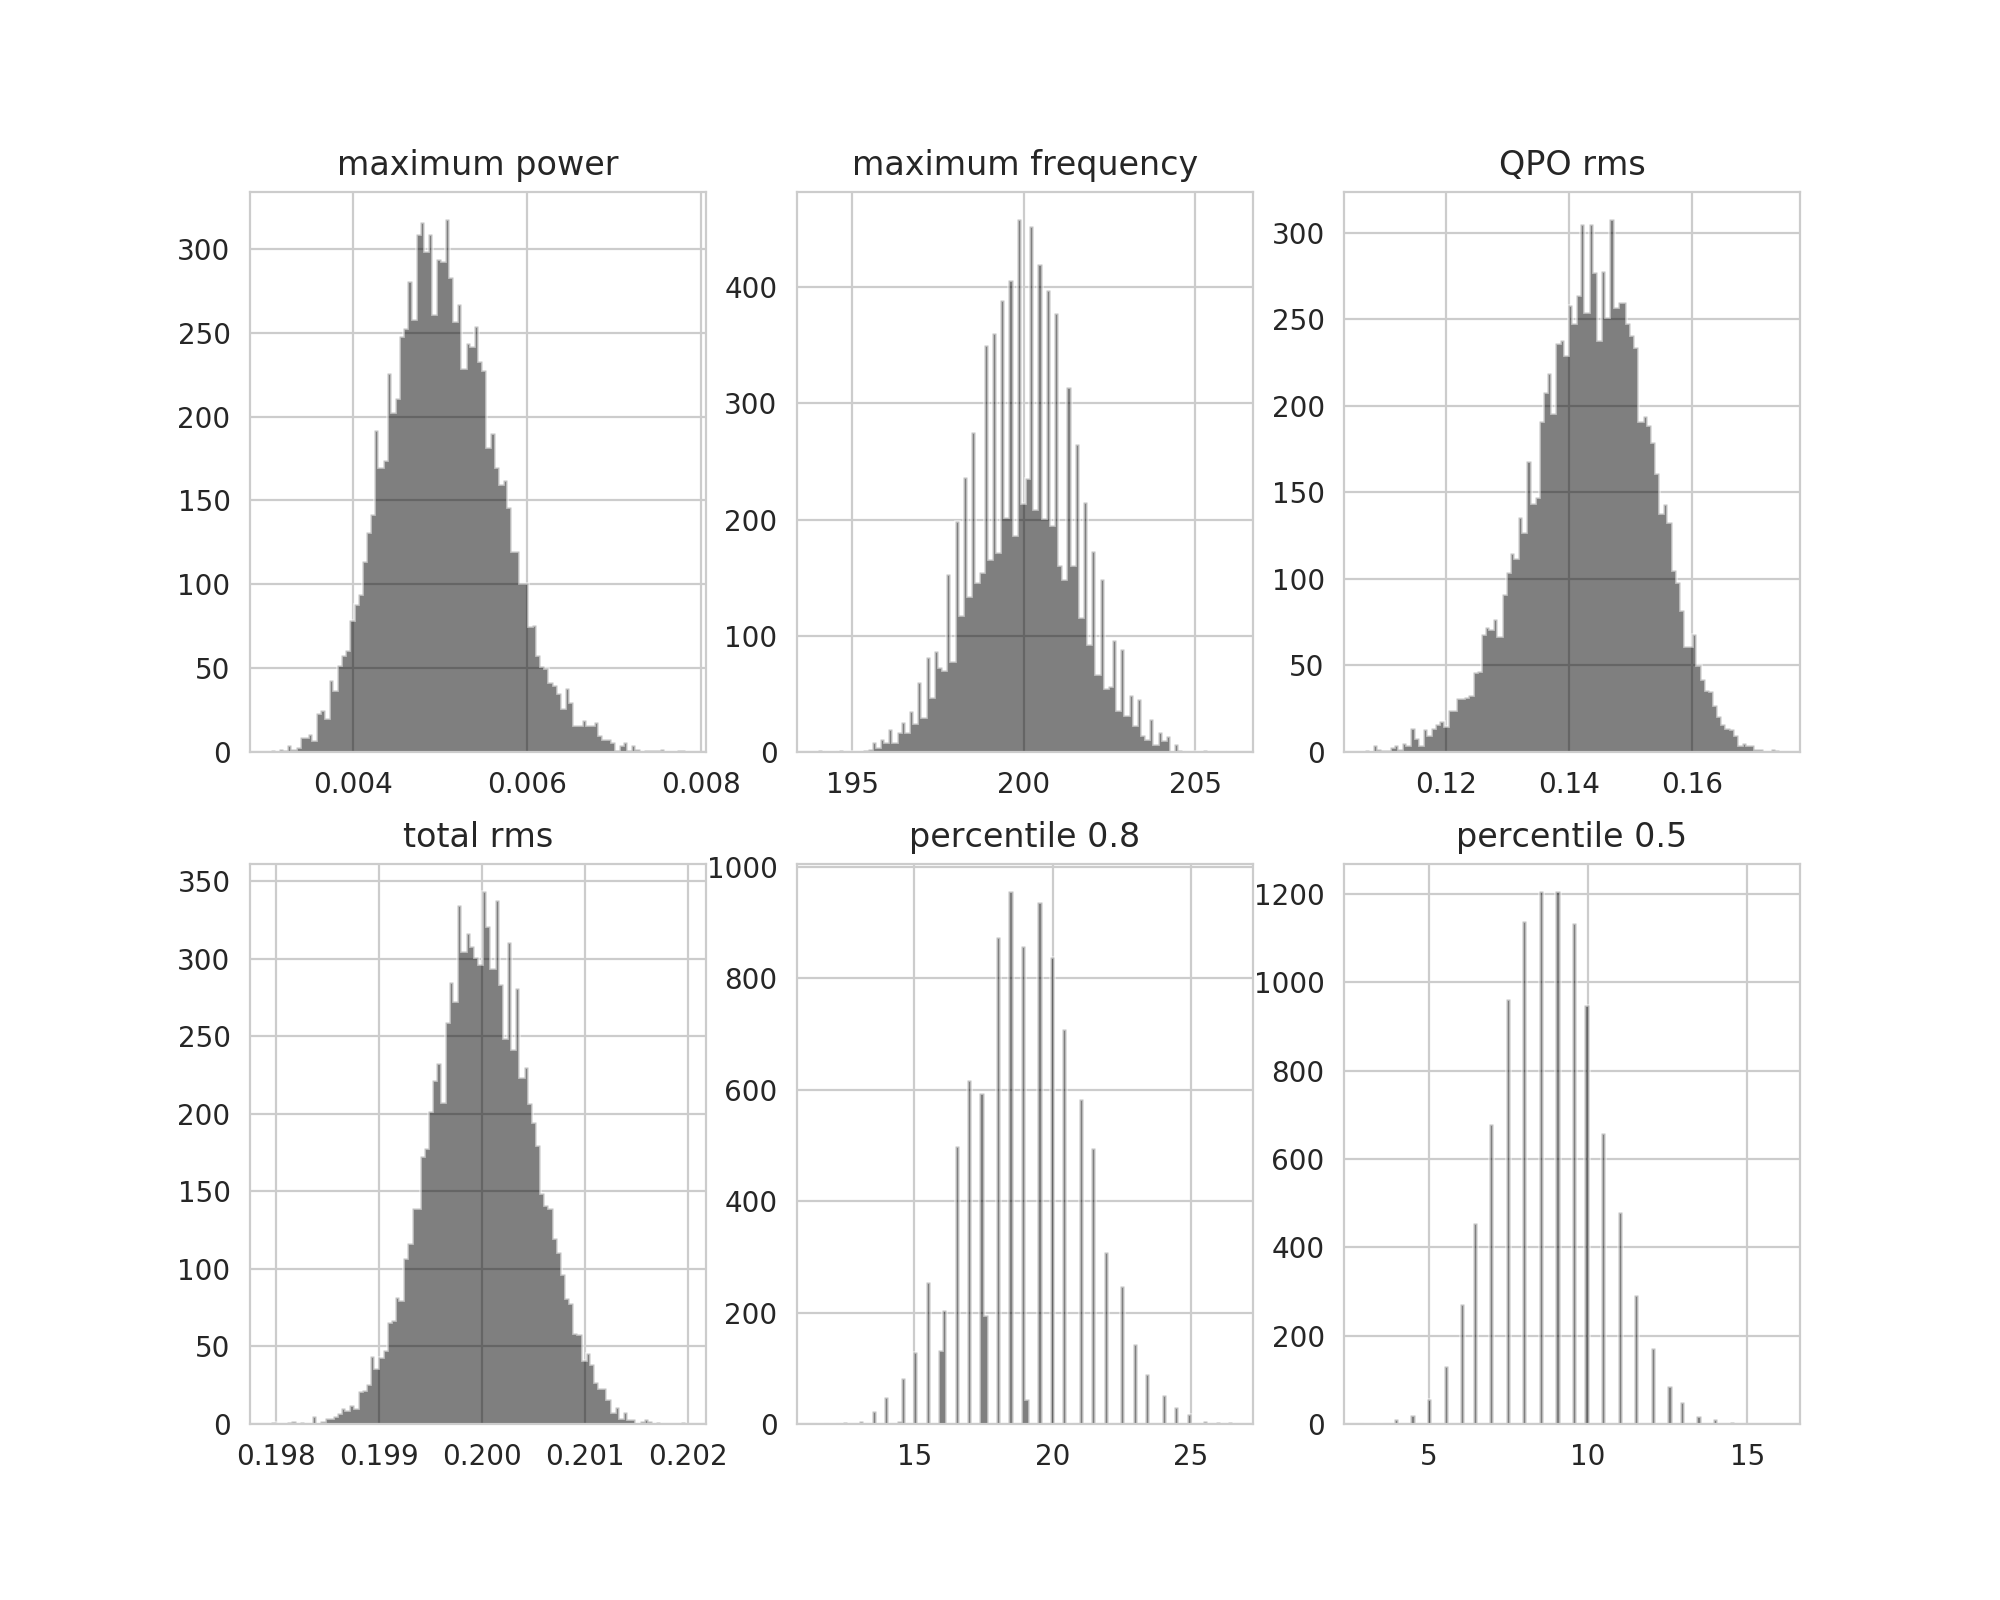

In [64]:
fig, axes = plt.subplots(2, 3, figsize=(10, 8))

axes = np.hstack(axes)

labels = ["maximum power", "maximum frequency", "QPO rms", "total rms", "percentile 0.8", "percentile 0.5"]

for i in range(true_summaries.shape[1]):
    axes[i].hist(true_summaries[:,i], bins=100, histtype="stepfilled", alpha=0.5, color="black")
    axes[i].set_title(labels[i])

What is the Euclidean distance between my true and simulated CSDs, based on the summaries here:

In [65]:
summary_obs = compute_qpo_summaries(cs_true, true_pars)

In [66]:
euclid_true = []

for s in true_summaries:
    euclid_true.append(euclidean_distance(summary_obs, s))
    

<IPython.core.display.Javascript object>


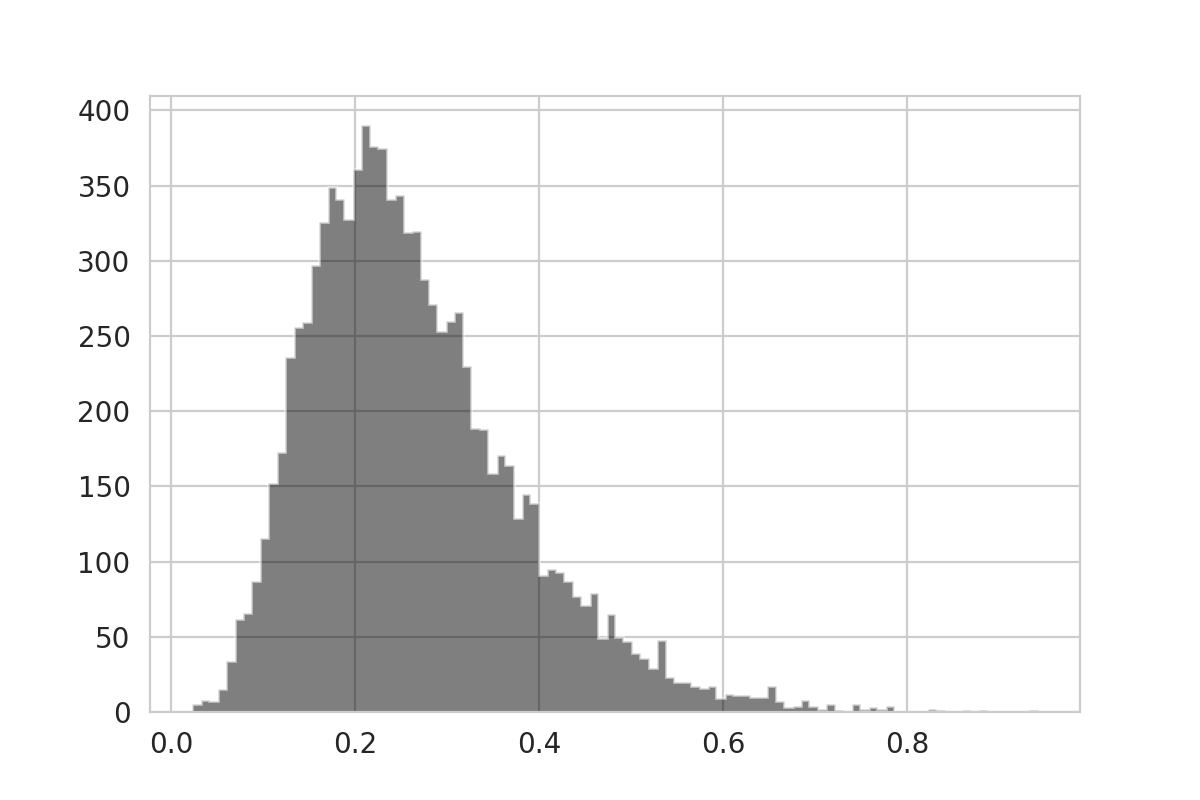

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.hist(euclid_true, bins=100, histtype="stepfilled", alpha=0.5, color="black");

Okay, cool. Now we need to simulate from the prior. 

For this, I first need to figure out what my relevant parameters are. 

I *think* my parameters should be: 
* (the mean of the light curve; let's include this later)
* the total rms in the QPO
* the position of the QPO
* the quality factor of the QPO. This corresponds to position/fwhm, so that I can use it to compute the FWHM

Let's define uniform priors to draw from for those:

In [68]:
def draw_qpo_pars(size=1):
    rms_limits = [0.1, 0.5]
    x0_limits = [100, 300]
    qual_limits = [3, 50]
    
    rms = np.random.uniform(*rms_limits, size=size)
    x0 = np.random.uniform(*x0_limits, size=size)
    qual = np.random.uniform(*qual_limits, size=size)
    return np.array([rms, x0, qual]).T
    

In [69]:
prior_params = draw_qpo_pars(size=1)

In [70]:
prior_params

array([[  0.42789956, 215.03728339,  41.9611984 ]])

In [71]:
prior_params = draw_qpo_pars(size=50000)

Let's just make sure they look sensible:

<IPython.core.display.Javascript object>


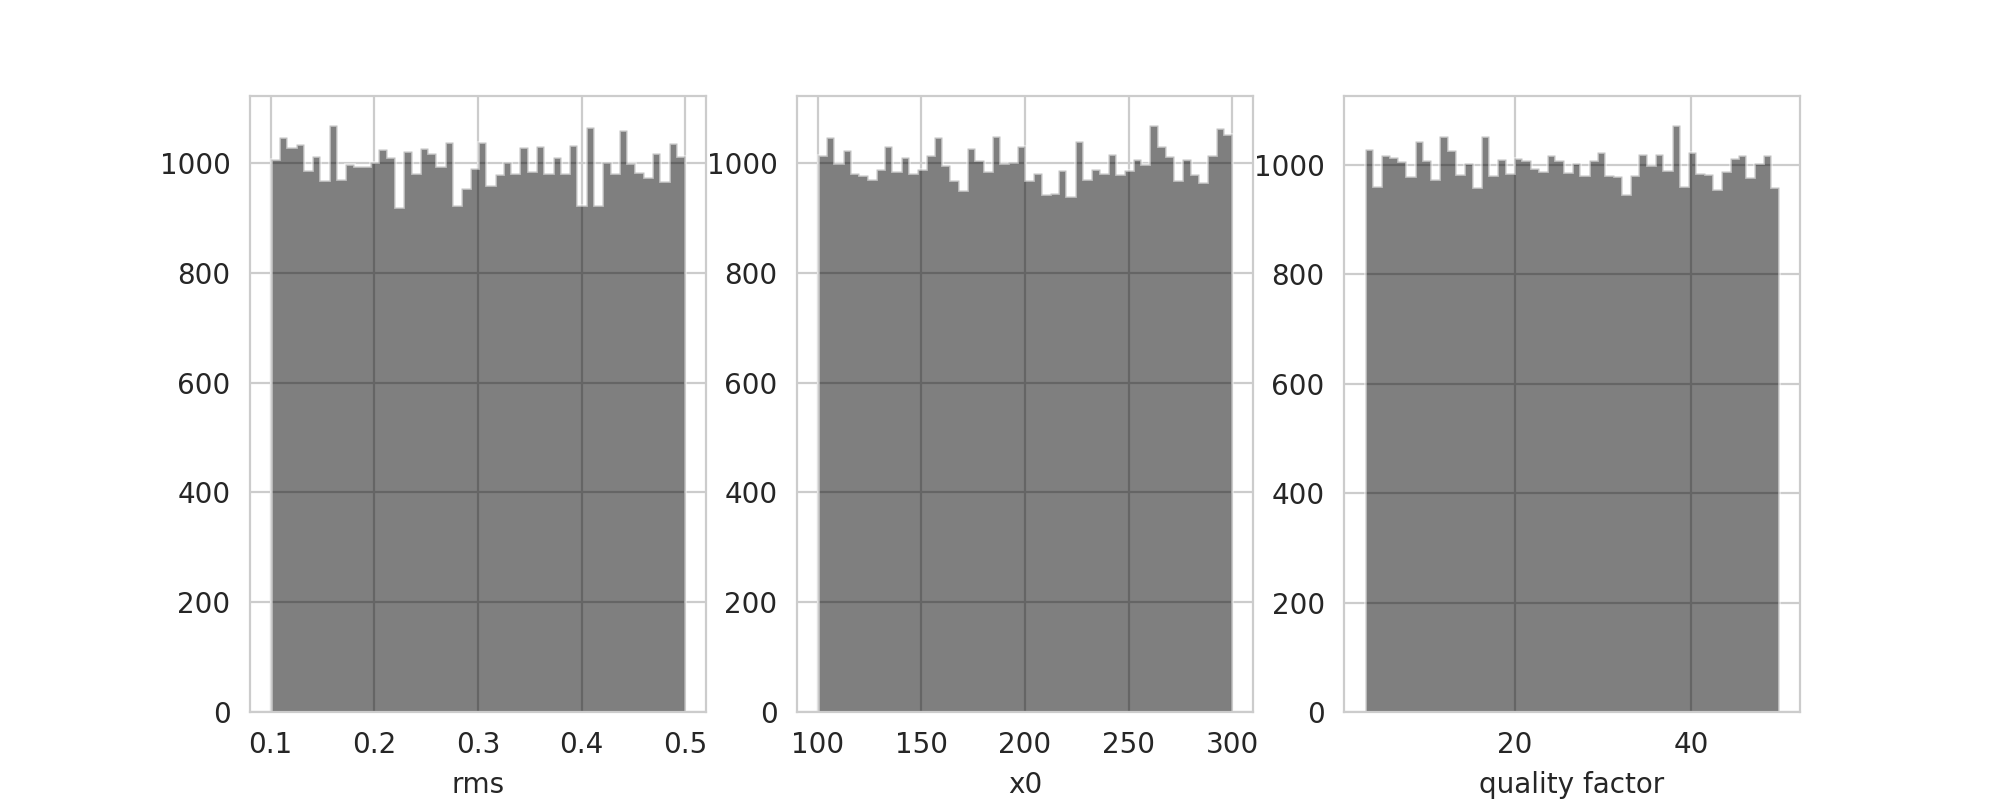

Text(0.5, 0, 'quality factor')

In [72]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4))

ax1.hist(prior_params[:,0], bins=50, histtype="stepfilled", alpha=0.5, color="black")
ax1.set_xlabel("rms")
ax2.hist(prior_params[:,1], bins=50, histtype="stepfilled", alpha=0.5, color="black")
ax2.set_xlabel("x0")
ax3.hist(prior_params[:,2], bins=50, histtype="stepfilled", alpha=0.5, color="black")
ax3.set_xlabel("quality factor")

Okay, that looks reasonable. Now I want to simulate a bunch of parameters and associated spectra, then 
look at the summaries and distances:

In [82]:
nsims = 1000

# generate prior parameters
prior_params = draw_qpo_pars(size=nsims)

# make sure my frequency array is defined correctly
freq = np.linspace(df, fmax, num=npoints//2)

# empty lists for results
cs_sim_prior = []
ps_sim_prior = []
summaries_prior = []
euclid_prior = []

for i, p in tqdm_notebook(enumerate(prior_params)):
    # make sure all the parameters are defined 
    rms = p[0] # rms is defined in first element of parameter vector
    x0 = p[1] # centroid position is defined in second element of parameter vector
    qual = p[2] # quality factor is defined in third element of parameter vector
    fwhm = x0/qual # fwhm is defined as the centroid/quality factor
    amp = 1.0 # the amplitude for the power spectrum is 1
    
    # set parameters in QPO model
    qpo.amplitude = amp
    qpo.x_0 = x0
    qpo.fwhm = fwhm
    
    # calculate the model spectrum
    mspec = qpo(freq)
    
    sim = Simulator(dt=dt, N=npoints, mean=true_mean, rms=rms)

    # get a simulated cross spectrum with noise
    ps_sim, cs_sim = simulate_csd(sim, mspec)
    cs_sim_prior.append(cs_sim)
    ps_sim_prior.append(ps_sim)

    # compute summaries
    s = compute_qpo_summaries(cs_sim, p)
    summaries_prior.append(s)
    
    # compute distance:
    d = euclidean_distance(summary_obs, s)
    euclid_prior.append(d)

summaries_prior = np.array(summaries_prior)

Let's make plots that compare the distribution of summaries:

In [52]:
labels = ["maxpower", "maxfreq", "rms_amp", "rms_tot", "percentile_diff_90", "percentile_diff_50"]

<IPython.core.display.Javascript object>


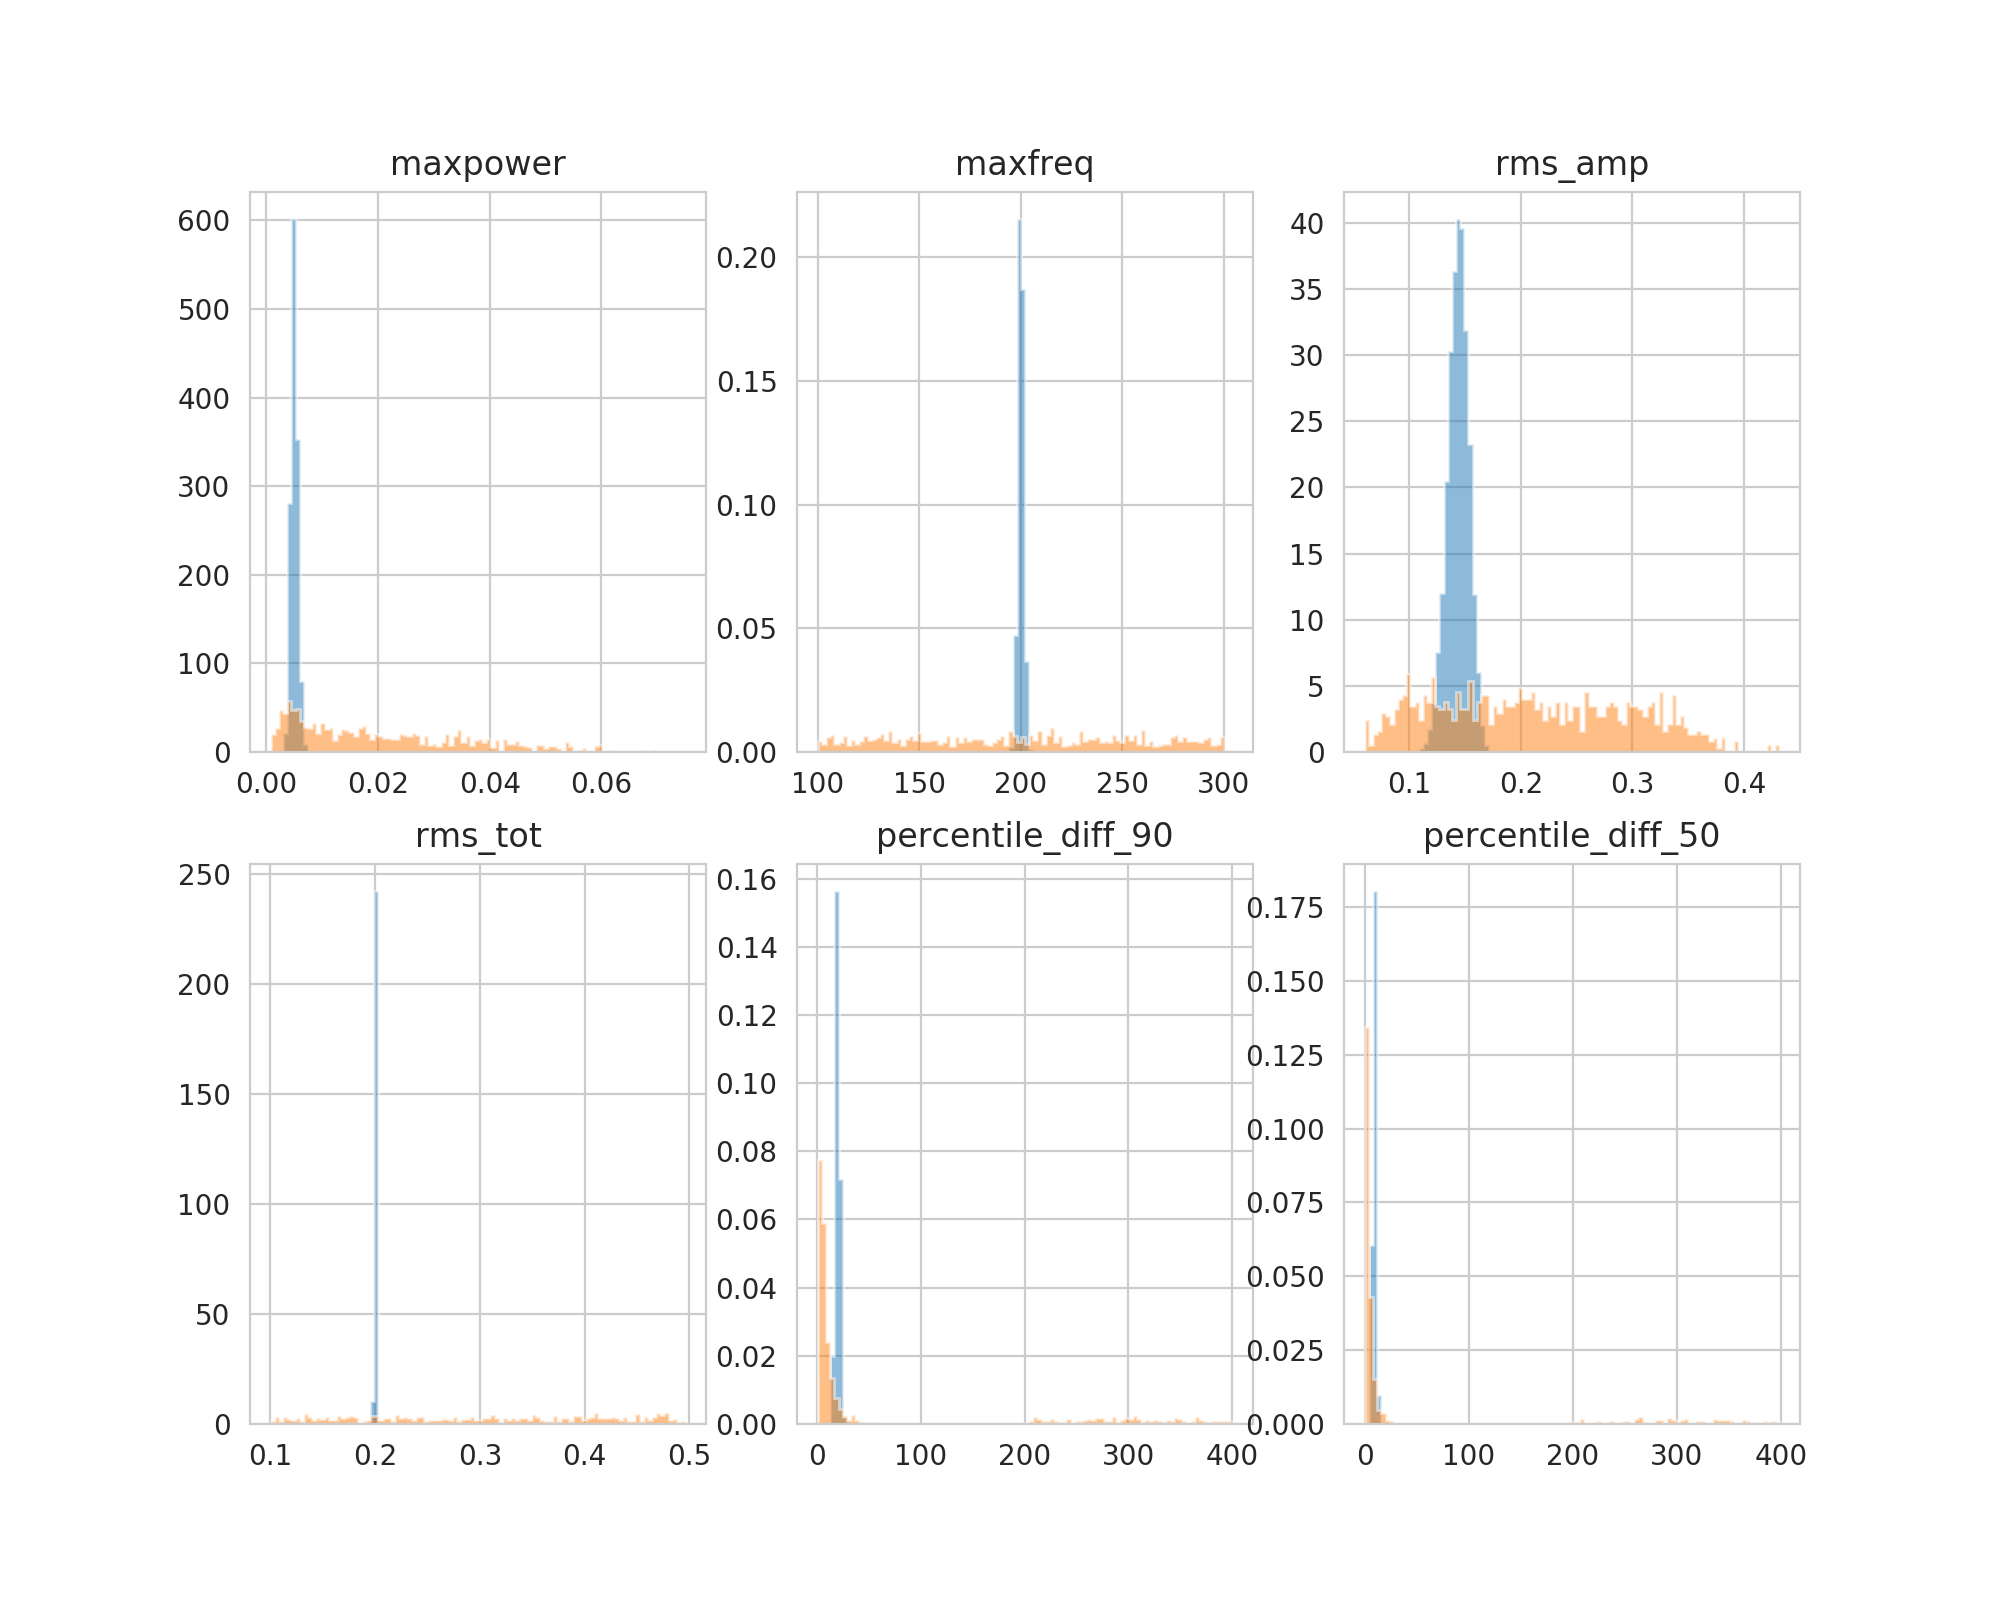

In [84]:
fig, axes = plt.subplots(2, 3, figsize=(10, 8))

axes = np.hstack(axes)

for i in range(true_summaries.shape[1]):
    all_summaries = np.hstack([true_summaries[:,i], summaries_prior[:,i]])
    histrange = [np.min(all_summaries), np.max(all_summaries)]
    
    axes[i].hist(true_summaries[:,i], bins=100, histtype="stepfilled", 
                 alpha=0.5, label="true params", range=histrange, density=True)
    axes[i].hist(summaries_prior[:,i], bins=100, histtype="stepfilled", 
                 alpha=0.5, label="prior params", range=histrange, density=True)
    
    axes[i].set_title(labels[i])



Let's look at the distance measure:

In [85]:
euclid_prior = np.array(euclid_prior)
summaries_prior = np.array(summaries_prior)

<IPython.core.display.Javascript object>


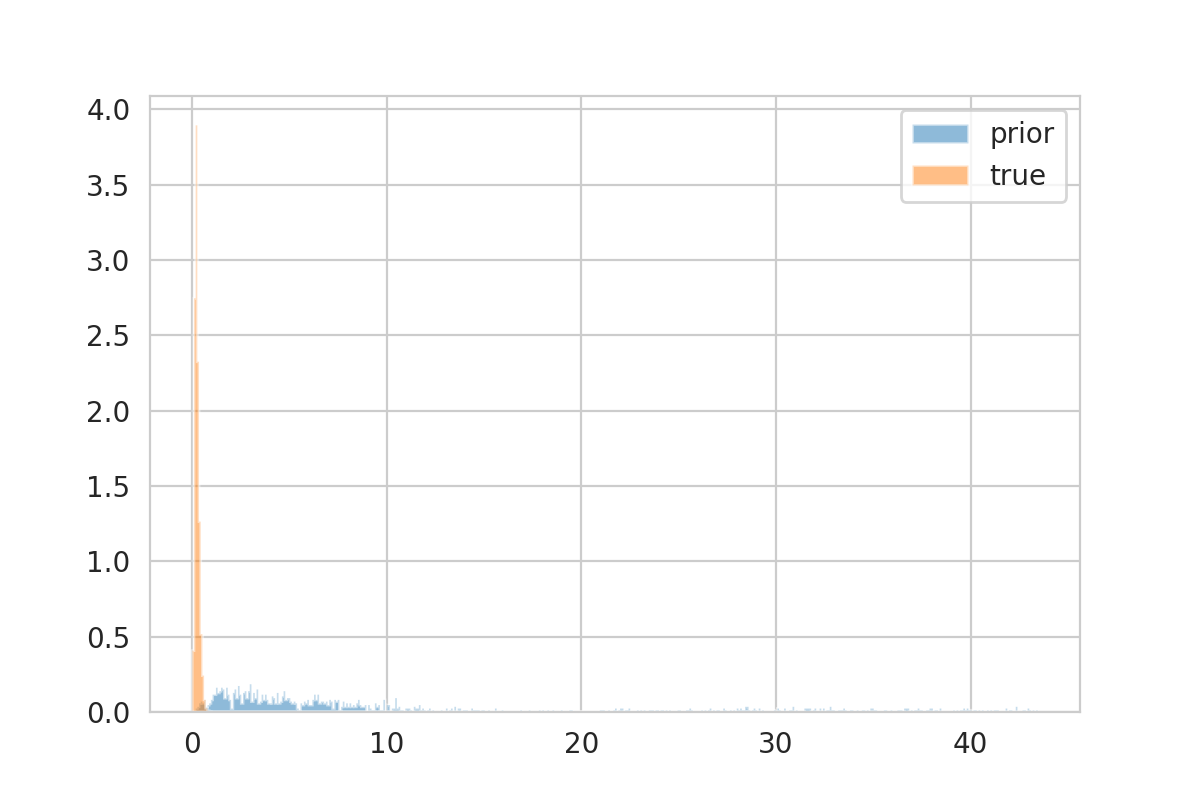

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

dist_range = [np.min(np.hstack([euclid_prior, euclid_true])), np.max(np.hstack([euclid_prior, euclid_true]))]
ax.hist(euclid_prior, bins=500, histtype="stepfilled", alpha=0.5, range=dist_range, label="prior", density=True)
ax.hist(euclid_true, bins=500, histtype="stepfilled", alpha=0.5, range=dist_range, label="true", density=True);

ax.legend()

Let's take a look at the means and standard deviations of those distributions:

In [93]:
print("Mean of distribution of distances for true parameters: "+ str(np.mean(euclid_true)))
print("Standard deviation of the distribution of distances for true parameters: " + str(np.std(euclid_true)))
print()
print("Mean of distribution of distances for prior parameters: "+ str(np.mean(euclid_prior)))
print("Standard deviation of the distribution of distances for prior parameters: " + str(np.std(euclid_prior)))

Mean of distribution of distances for true parameters: 0.2601203163801495
Standard deviation of the distribution of distances for true parameters: 0.11712929525720918

Mean of distribution of distances for prior parameters: 10.157008825044777
Standard deviation of the distribution of distances for prior parameters: 11.315390755102149


Okay, that looks like all my values for the true parameters are *much* smaller than the distance values for the prior.

How many samples are low enough to be similar to my real data?

In [94]:
print(euclid_prior[euclid_prior < np.max(euclid_true)])
print(len(euclid_prior[euclid_prior < np.max(euclid_true)]))

[0.57959166 0.3605739  0.92665448 0.7733969  0.3931352  0.33943933
 0.66914836 0.68909362 0.57503    0.26379987 0.6044887  0.22356458
 0.34713247 0.64674361 0.80730599 0.42407451 0.91127352 0.45357849
 0.42470775 0.63006408 0.52751627 0.5864244  0.78968536 0.84962923
 0.60419454 0.43743574 0.48724414 0.91579404 0.66627484 0.72182579
 0.44859546 0.91107471 0.31458482 0.45009779 0.63696437 0.80360555
 0.81154048 0.47505663 0.69485466]
39


Okay, so out of the 1000 simulations above, a few are in the expected range. Let's run some more simulations:

In [95]:
nsims = 10000

# generate prior parameters
prior_params = draw_qpo_pars(size=nsims)

# make sure my frequency array is defined correctly
freq = np.linspace(df, fmax, num=npoints//2)

# empty lists for results
cs_sim_prior = []
summaries_prior = []
euclid_prior = []

# set the random state for reproducibility
rng = np.random.RandomState(3000) 

for i, p in tqdm_notebook(enumerate(prior_params)):
    # make sure all the parameters are defined 
    rms = p[0] # rms is defined in first element of parameter vector
    x0 = p[1] # centroid position is defined in second element of parameter vector
    qual = p[2] # quality factor is defined in third element of parameter vector
    fwhm = x0/qual # fwhm is defined as the centroid/quality factor
    amp = 1.0 # the amplitude for the power spectrum is 1
    
    # set parameters in QPO model
    qpo.amplitude = amp
    qpo.x_0 = x0
    qpo.fwhm = fwhm
    
    # calculate the model spectrum
    mspec = qpo(freq)
    
    try:
        # set up the Simulator object.
        sim = Simulator(dt=dt, N=npoints, mean=true_mean, rms=rms, random_state=rng)

        # get a simulated cross spectrum with noise
        ps_sim, cs_sim = simulate_csd(sim, mspec)
        cs_sim_prior.append(cs_sim)

        # compute summaries
        s = compute_qpo_summaries(cs_sim, p)
        summaries_prior.append(s)

        # compute distance:
        d = euclidean_distance(summary_obs, s)
        euclid_prior.append(d)

    except ValueError:
        euclid_prior.append(-1000)
        continue


In [96]:
euclid_prior = np.array(euclid_prior)
summaries_prior = np.array(summaries_prior)

The [Ishida et al (2015)](https://ui.adsabs.harvard.edu/abs/2015A%26C....13....1I/abstract) suggests to plot the parameter values against the distance function, so let's try that:

<IPython.core.display.Javascript object>


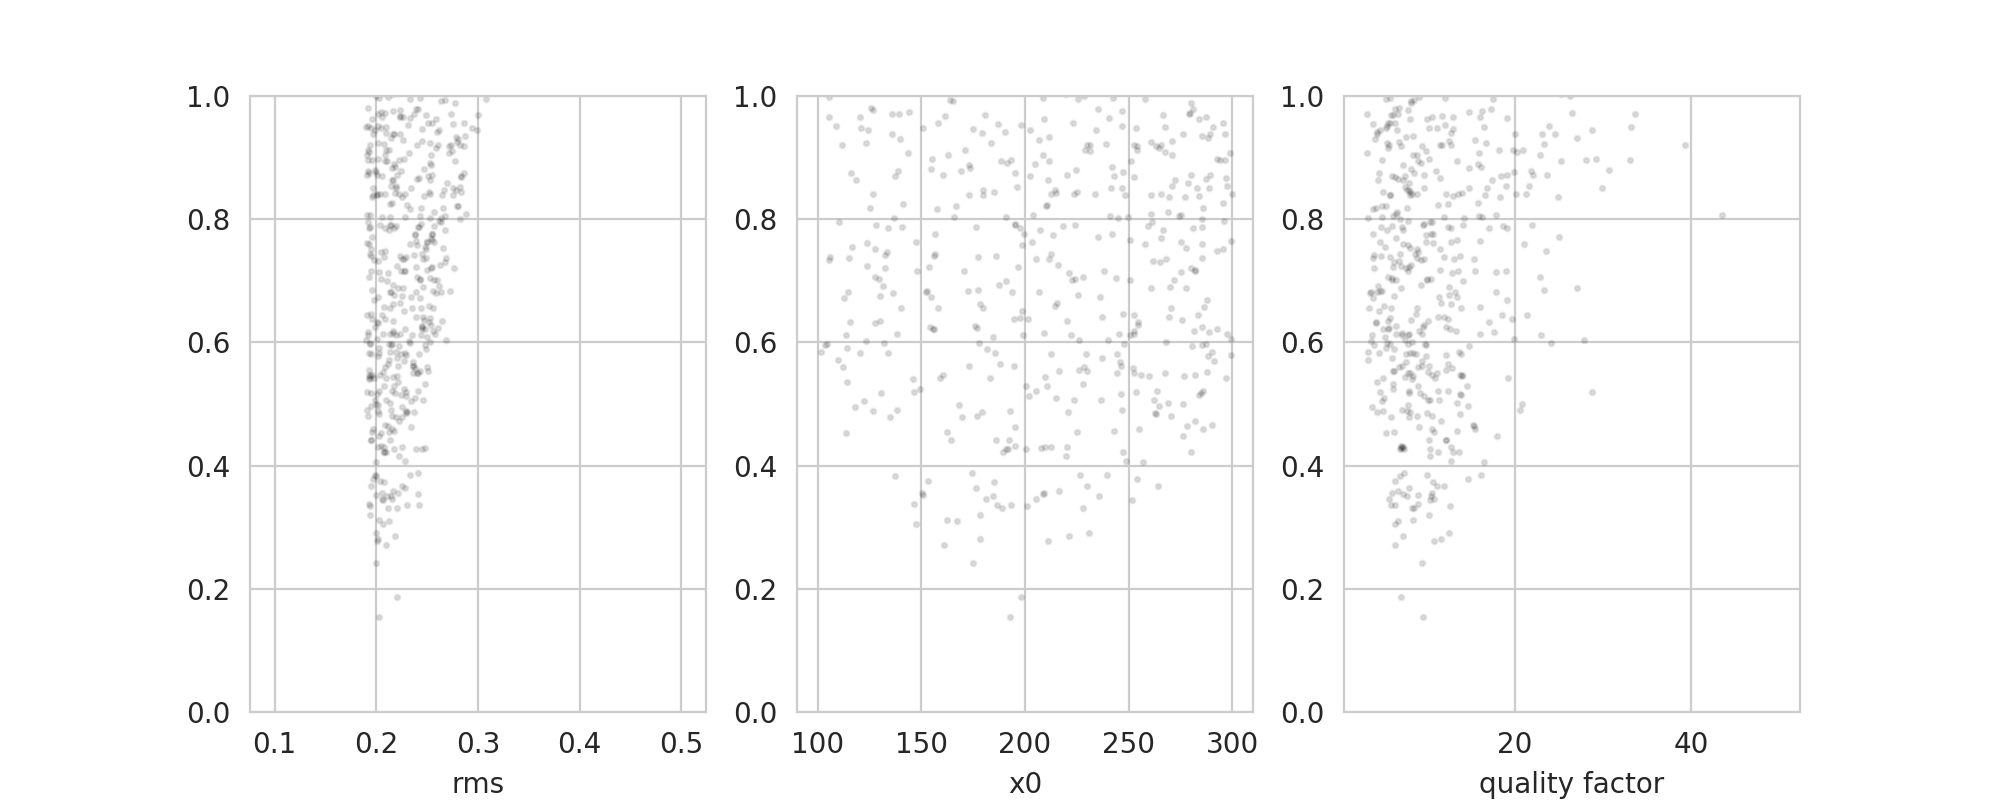

(0, 1)

In [100]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4))

ylim = [0, 1]

ax1.scatter(prior_params[euclid_prior >= 0,0], euclid_prior[euclid_prior >= 0], s=3, c="black", alpha=0.1)
ax1.set_xlabel("rms")
ax1.set_ylim(*ylim)

ax2.scatter(prior_params[euclid_prior >= 0,1], euclid_prior[euclid_prior >= 0], s=3, c="black", alpha=0.1)
ax2.set_xlabel("x0")
ax2.set_ylim(*ylim)

ax3.scatter(prior_params[euclid_prior >= 0,2], euclid_prior[euclid_prior >= 0], s=3, c="black", alpha=0.1)
ax3.set_xlabel("quality factor")
ax3.set_ylim(*ylim)

That looks  not bad.

I guess we're now ready to give it a try with PMC?

In [57]:
import astroabc

Let's first define our distance metric:

In [37]:
def my_dist(data, sim):
    """
    Distance between observed `data` and simulated data points `sim`
    
    Parameters
    -----------
    data : numpy.ndarray
        Observed data points
        
    sim : numpy.ndarray, of same shape as `data`
        Simulated data points
        
    Returns
    -------
    was : float
        The distance between `data` and `sim`
    """
    return euclidean_distance(data, sim)

Now we need to define the priors in a format that AstroABC will understand:

In [49]:
priors = [("uniform", [0.1, 0.5]),
          ("uniform", [100, 300]),
          ("uniform", [3, 50])    
          ]

In [50]:
def simulation(param):
    """
    Generate a simulated data set with a single QPO given a parameter set.
    
    Parameters
    ----------
    param : iterable
        A list of parameters
        
    Returns
    -------
    summary : np.ndarray
        An array of summary statistics
    
    """
    # make sure all the parameters are defined 
    rms = param[0] # rms is defined in first element of parameter vector
    x0 = param[1] # centroid position is defined in second element of parameter vector
    qual = param[2] # quality factor is defined in third element of parameter vector
    fwhm = x0/qual # fwhm is defined as the centroid/quality factor
    amp = 1.0 # the amplitude for the power spectrum is 1

    # set parameters in QPO model
    qpo.amplitude = amp
    qpo.x_0 = x0
    qpo.fwhm = fwhm

    # calculate the model spectrum
    mspec = qpo(freq)

    # set up the Simulator object.
    sim = Simulator(dt=dt, N=npoints, mean=true_mean, rms=rms, random_state=rng)

    # get a simulated cross spectrum with noise
    ps_sim, cs_sim = simulate_csd(sim, mspec)

    # compute summaries
    summary = compute_qpo_summaries(cs_sim, param)
    
    return summary


Let's now set up the sampling.

In [56]:
nparam = 3 # problem currently has 3 parameters: QPO rms, centroid position, fwhm
npart = 200 # number of particles/walkers
niter = 50 # the number of iterations
tlevels = [50, 0.01]

prop = {"tol_type":'exp', "verbose":1, "adapt_t":True, 
        "threshold":75 , "pert_kernel": 2, "variance_method": 0,
        "dist_type":'user', "dfunc": my_dist, "restart": "restart_test.txt",
        "outfile": "abc_pmc_output_qpo_test_param.txt", "mpi":False, 
        "mp":True, "num_proc":12, "from_restart":False}

In [120]:
sampler = astroabc.ABC_class(nparam,npart,summary_obs,tlevels,niter,priors,**prop)

	 	
	 ########################     astroABC     ########################	
	 	
	 Npart=200 	 numt=50 	 tol=[50.0000,0.0100] exp
	 Priors= [('uniform', [0.1, 0.5]), ('uniform', [100, 300]), ('uniform', [3, 50])]


Process ForkPoolWorker-20:
Process ForkPoolWorker-17:
Process ForkPoolWorker-21:
Process ForkPoolWorker-23:
Process ForkPoolWorker-15:
Process ForkPoolWorker-13:
Process ForkPoolWorker-22:
Process ForkPoolWorker-14:
Process ForkPoolWorker-19:
Process ForkPoolWorker-16:
Process ForkPoolWorker-24:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/astro/users/dhuppenk/.conda/envs/dataviz/lib/pytho

  File "/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/crossspectrum.py", line 193, in _make_auxil_pds
    self.pds2 = Crossspectrum(lc2, lc2, norm='none')
  File "<ipython-input-104-61808b32da4d>", line 35, in simulation
    ps_sim, cs_sim = simulate_csd(sim, mspec)
  File "<ipython-input-36-9366eb11b086>", line 29, in simulate_csd
    ps2 = Powerspectrum(lc2, norm="frac")
  File "<ipython-input-104-61808b32da4d>", line 35, in simulation
    ps_sim, cs_sim = simulate_csd(sim, mspec)
  File "<ipython-input-46-2fd374728f05>", line 63, in compute_qpo_summaries
    power_cumsum = np.cumsum(cs_sim.power)
  File "/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/astroabc-1.3.2-py3.6.egg/astroabc/abc_class.py", line 393, in classstep
    x = self.model(trial_t)
  File "/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
  File "/astro/users/dhuppenk/.conda/envs/da

  File "/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/numpy/core/fromnumeric.py", line 988, in sort
    a = asanyarray(a).copy(order="K")
KeyboardInterrupt
  File "/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/stingray/gti.py", line 252, in create_gti_mask
    gtis_to_mask[:, 1] = gtis_new[:, 1] + epsilon * dt - dt / 2
  File "/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/site-packages/numpy/core/fromnumeric.py", line 61, in _wrapfunc
    return bound(*args, **kwds)
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
Traceback (most recent call last):
Traceback (most recent call last):
  File "/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/astro/users/dhuppenk/.conda/envs/dataviz/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/astro/users/dhuppenk/.conda/envs/dataviz/lib/python

In [121]:
sampler.sample(simulation)

	 Step: 0 	 tol: 49.99999999999999 	 Params: [0.29860151712863486, 210.36301085111393, 26.178111749649133]
	 Step: 1 	 tol: 12.398105346883344 	 Params: [0.30905407071338153, 217.43240151063918, 24.661307747925253]
	 Step: 2 	 tol: 7.221749077702756 	 Params: [0.30307493179485306, 201.3657958349275, 22.942992047826937]
	 Step: 3 	 tol: 4.5816184547586545 	 Params: [0.28637961730314454, 209.1378309408994, 22.675696365907992]
	 Step: 4 	 tol: 3.345902643899239 	 Params: [0.2640993083474731, 234.57305589176525, 20.335963920298138]
	 Step: 5 	 tol: 2.453440381351313 	 Params: [0.241500345450891, 209.81271280628786, 20.76019940074048]
	 Step: 6 	 tol: 2.1408433600299124 	 Params: [0.24589792137302435, 231.25406477320502, 17.7916435510323]
	 Step: 7 	 tol: 1.809705466284477 	 Params: [0.25404592876274457, 242.62896873874118, 14.705729255898637]
	 Step: 8 	 tol: 1.5781166367425945 	 Params: [0.24076755635902727, 239.97695907669134, 13.820529751940294]
	 Step: 9 	 tol: 1.3498943337824132 	 Par

KeyboardInterrupt: 

Let's take a look at the results:

In [123]:
samp = pd.read_csv("abc_pmc_output_qpo_test_param.txt", sep="\t", 
                   names=["rms", "x0", "fwhm", "dist", "weight"], skiprows=1, index_col=False)

In [124]:
samp.shape

(9600, 5)

In [125]:
niter_post = samp.shape[0] // npart

In [126]:
niter_post

48

Let's plot the samples at several iterations:

[ 0  5 10 15 20 25 30 35 40 45 47]


<IPython.core.display.Javascript object>


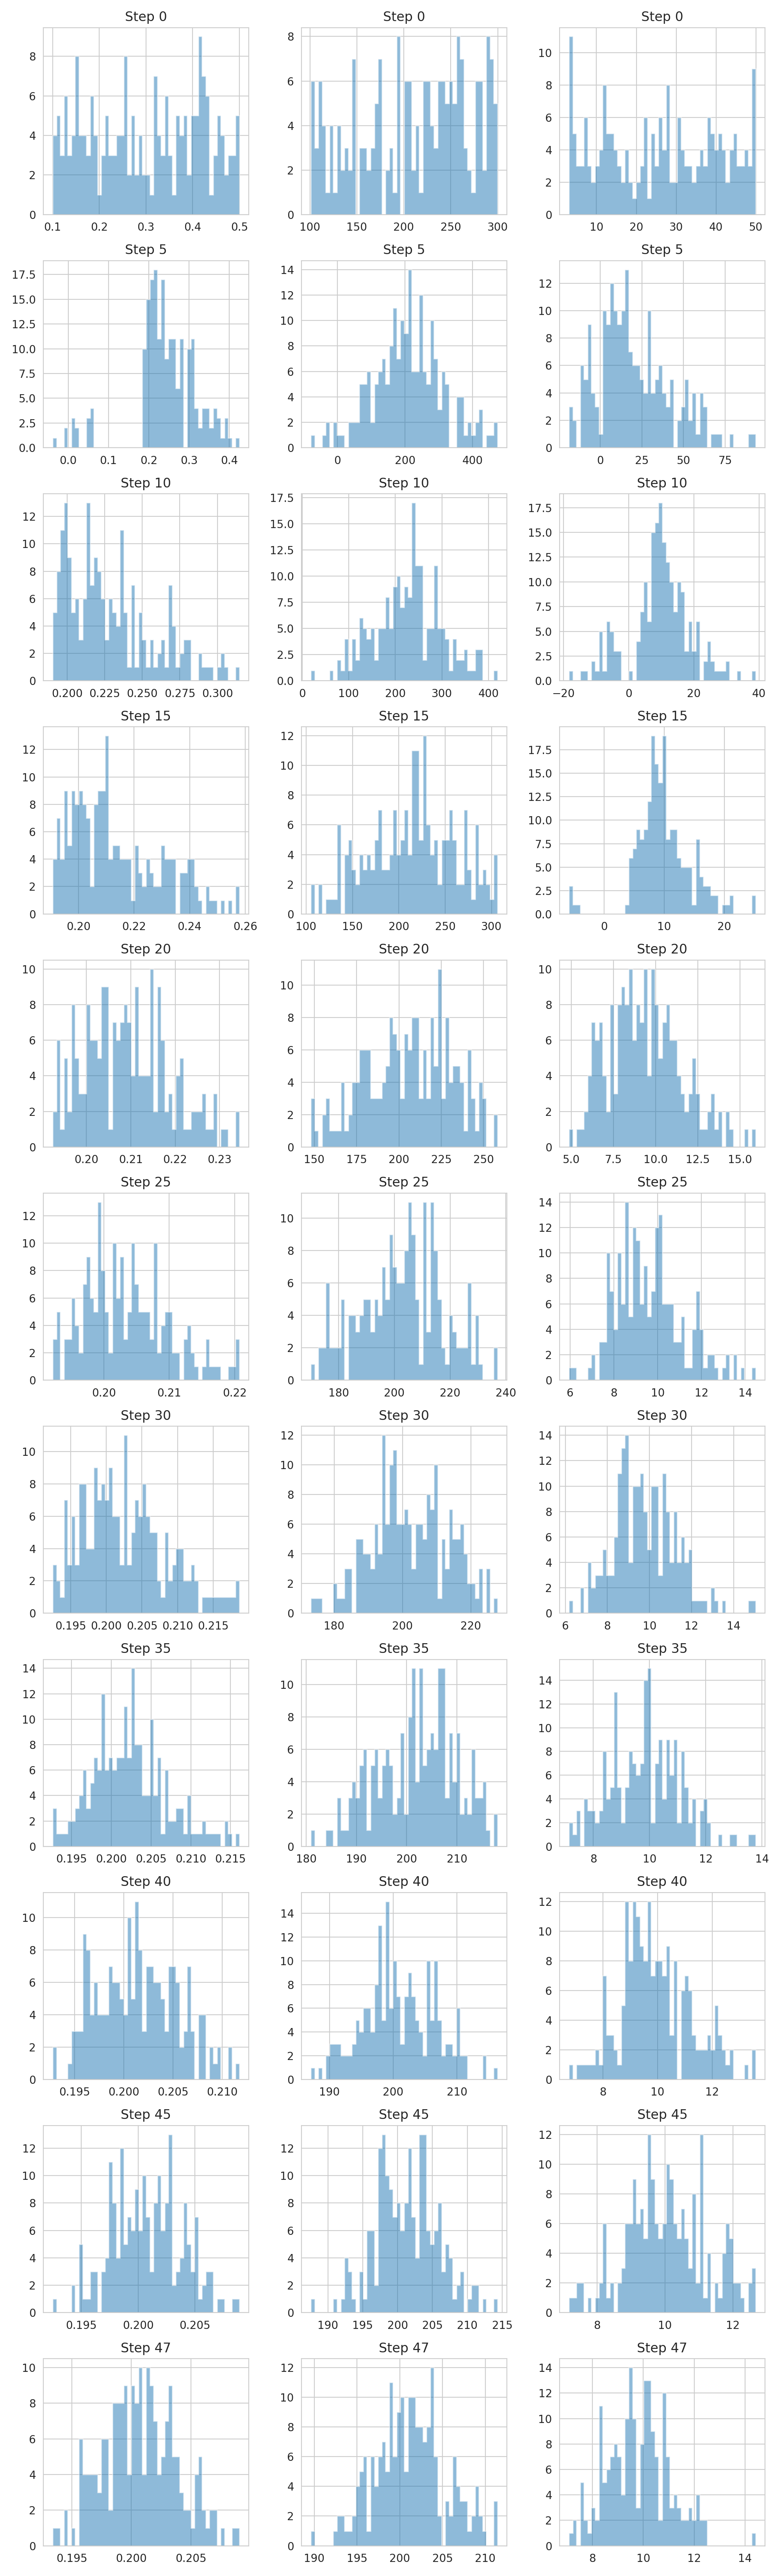

In [128]:
idx = np.arange(0, niter_post, 5)

idx = np.hstack([idx, (niter_post)-1])
print(idx)

fig, axes = plt.subplots(len(idx), 3, figsize=(10, 3*len(idx)))

for i, ax in zip(idx, axes):
    minind = 200*i
    maxind = 200*(i+1)
    samp_iter = samp.loc[minind:maxind]
    for j, par in enumerate(["rms", "x0", "fwhm"]):
        ax[j].hist(samp_iter[par], bins=50, histtype="stepfilled", alpha=0.5)
        ax[j].set_title("Step %i"%i)
        
plt.tight_layout()

I *think* we can now resample the posterior using the entire sample along with the relevant probabilities:

In [129]:
samp.head()

rms          x0       fwhm       dist  weight
0  0.225282  236.973473  20.821844   0.975656   0.005
1  0.152060  146.505421  13.749138  38.431694   0.005
2  0.353888  186.020062  28.611408   6.013818   0.005
3  0.457833  295.345758  24.329947   6.588712   0.005
4  0.400185  194.490082  11.555953   3.611361   0.005

In [135]:
post = samp.sample(n=200,weights="weight")

<IPython.core.display.Javascript object>


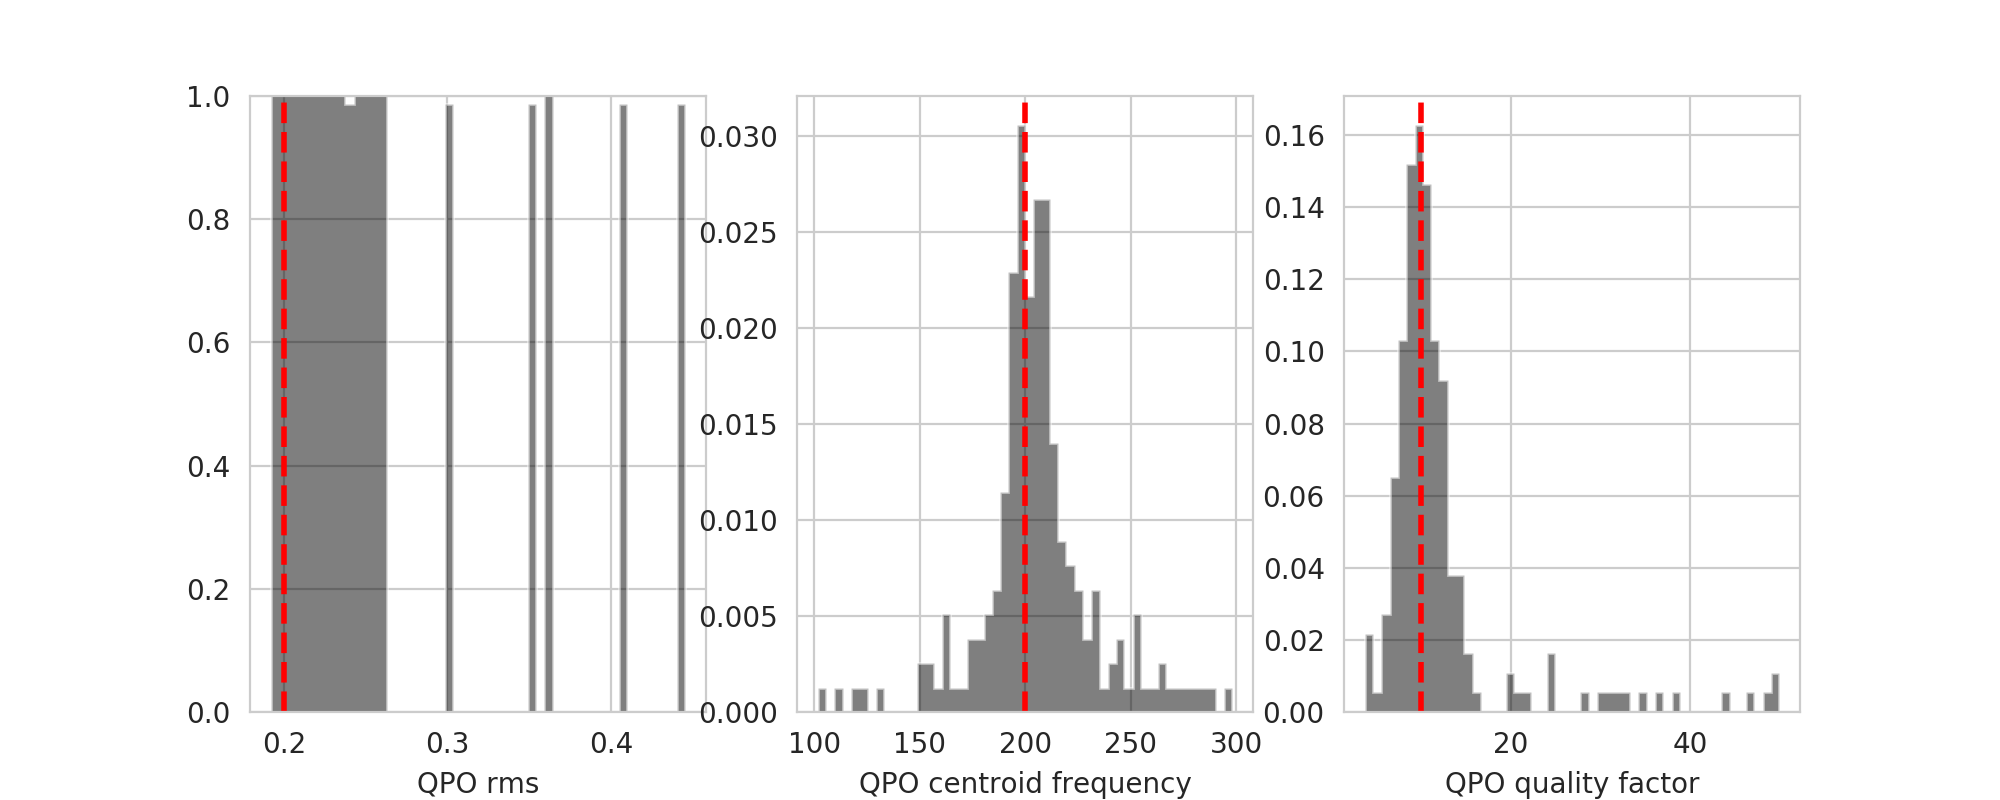

In [138]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10,4))

ax1.hist(post["rms"], bins=50, histtype="stepfilled", alpha=0.5, color="black", density=True)
ax1.set_xlabel("QPO rms")
ax1.axvline(true_rms, lw=2, color="red", linestyle="dashed")

ax2.hist(post["x0"], bins=50, histtype="stepfilled", alpha=0.5, color="black", density=True)
ax2.set_xlabel("QPO centroid frequency")
ax2.axvline(true_pars[1], lw=2, color="red", linestyle="dashed")


ax3.hist(post["fwhm"], bins=50, histtype="stepfilled", alpha=0.5, color="black", density=True)
ax3.set_xlabel("QPO quality factor")
ax3.axvline(true_pars[1]/true_pars[2], lw=2, color="red", linestyle="dashed")



## Including the mean in the model

I should also include the mean in the model, since that will turn out to be important for the dead time issue. 

Let's do that, then:

In [177]:
def simulation(param):
    """
    Generate a simulated data set with a single QPO given a parameter set.
    
    Parameters
    ----------
    param : iterable
        A list of parameters
        
    Returns
    -------
    summary : np.ndarray
        An array of summary statistics
    
    """
    #print(param)
    
    # make sure all the parameters are defined 
    rms = param[0] # rms is defined in first element of parameter vector
    x0 = param[1] # centroid position is defined in second element of parameter vector
    qual = param[2] # quality factor is defined in third element of parameter vector
    lcmean = param[3]
    fwhm = x0/qual # fwhm is defined as the centroid/quality factor
    amp = 1.0 # the amplitude for the power spectrum is 1

    # set parameters in QPO model
    qpo.amplitude = amp
    qpo.x_0 = x0
    qpo.fwhm = fwhm

    # calculate the model spectrum
    mspec = qpo(freq)

    # set up the Simulator object.
    sim = Simulator(dt=dt, N=npoints, mean=lcmean, rms=rms, random_state=rng)

    # get a simulated cross spectrum with noise
    data_sim = simulate_csd(sim, mspec)

    # compute summaries
    summary = compute_qpo_summaries(data_sim)
    
    return summary

def simulate_csd(sim, mspec):
    """
    Function to simulate cospectra, given a 
    Simulator object and a power law index.
    
    Parameters
    ----------
    pl_idx : float
        The power law index for the model
        
    sim : stingray.simulation.Simulator object
        A simulator object to simulate the periodogram
    """
    lc = sim.simulate(mspec)
    
    mask = (lc.counts < 0.0)
    lc.counts[mask] = 0.0

    counts1 = rng.poisson(lc.counts)
    counts2 = rng.poisson(lc.counts)

    lc1 = Lightcurve(lc.time, counts1)
    lc2 = Lightcurve(lc.time, counts2)
    
    #print('np.mean(lc1): ' + str(np.mean(lc1.counts)))
    #print('np.mean(lc2): ' + str(np.mean(lc2.counts)))

    lc_sum = lc1 + lc2
    #print('np.mean(lc_sum): ' + str(np.mean(lc_sum.counts)))

    ps_sum = Powerspectrum(lc_sum, norm="frac")
    ps1 = Powerspectrum(lc1, norm="frac")
    ps2 = Powerspectrum(lc2, norm="frac")

    cs_sim = Crossspectrum(lc1, lc2, norm="frac")
    
    return [lc_sum, ps_sum, cs_sim]

def draw_qpo_pars(size=1):
    """
    Draw parameters from the prior, assuming 
    the (uniform) priors defined below.
    
    Parameters
    ----------
    size : int
        The number of draws from the prior
        
    Returns
    -------
    psample : numpy.ndarray of shape (size, npars)
        The draw(s) from the prior as an array of shape 
        (number of draws, number of parameters)
    """
    rms_limits = [0.1, 0.5]
    x0_limits = [100, 300]
    qual_limits = [3, 50]
    mean_limits = [0, 2000]
    
    rms = np.random.uniform(*rms_limits, size=size)
    x0 = np.random.uniform(*x0_limits, size=size)
    qual = np.random.uniform(*qual_limits, size=size)
    lcmean = np.random.uniform(*mean_limits, size=size)
    return np.array([rms, x0, qual, lcmean]).T
    

def compute_qpo_summaries(data, rms_boundaries=[100, 300], percentile_pairs=None, nmax=10):
    """
    Compute summary statistics for the QPO model.
    
    Current summary statistics:
        * total rms amplitude of the QPO (calculated as the total rms amplitude between 
          two frequencies given in `rms_boundaries`)
        * the total rms amplitude in the entire periodogram (corresponds to the variance 
          in the light curve)
        * the maximum power in the periodogram (calculated as the mean of the `nmax` highest 
          powers in the periodogram)
        * the frequency at which the maximum occurs (also calculated as the mean of the `nmax` 
          highest powers)
        * the difference between frequencies at which the periodogram contains a fraction 
          of $p$ of the total power (variance) in the light curve. I.e. for a pair of [0.1, 0.9], 
          the function will calculate the frequency at which the periodogram contains 10% of the 
          total variance, then the frequency at which the periodogram contains 90% of the total 
          variance (both counted from the zeroth frequency), and finally subtract the first from 
          the second to generate a difference. This is ideally a measure of the width of the 
          QPO, but crucially relies on there basically being just one QPO. 
    
    Parameters
    ----------
    data : list of [stingray.Lightcurve, stingray.Powerspectrum, stingray.Crossspectrum]
        Simulated light curve, PSD and CSD
    
    pars : iterable
        The list of input paramters that generated the simulated CSD
            
    rms_boundaries: iterable [min_boundary, max_boundary]
        The frequencies between which to integrate to compute the rms 
        of the QPO
    
    percentile_pairs : iterable of tuples, default: [[0.1, 0.9], [0.25, 0.75]]
        These pairs are used to calculate the difference in frequencies at which 
        different percentiles of the total variance are reached. 

    Returns
    -------
    summary : numpy.ndarray
        An array of summary statistics as defined above
    """
    
    lc_sim = data[0]
    ps_sim = data[1]
    cs_sim = data[2]

    # compute mean of the light curve
    lc_mean = np.mean(lc_sim.counts)
    #lc_median = np.median(lc_sim.counts)
    
    # compute rms between 100 and 300 Hz. 
    minind = cs_sim.freq.searchsorted(rms_boundaries[0])
    maxind = cs_sim.freq.searchsorted(rms_boundaries[1])
    
    # compute the rms amplitude in QPO:
    rms_amp = np.sqrt(np.sum(cs_sim.power[minind:maxind]) * cs_sim.df )
    
    # compute the total rms amplitude in the PSD
    rms_tot = np.sqrt(np.sum(cs_sim.power) * cs_sim.df)
    
    # index of sorted array of powers
    sort_idx = np.argsort(cs_sim.power)[::-1]
    
    # compute the maximum power and frequency:
    maxpower = np.mean(cs_sim.power[sort_idx[:nmax]])
    maxfreq = np.mean(cs_sim.freq[sort_idx[:nmax]])
    
    # store cumulative sum in an array
    power_cumsum = np.cumsum(cs_sim.power)

    # compute percentiles:
    if percentile_pairs is None:
        percentile_pairs = [[0.1, 0.9], [0.25, 0.75]]

    # get the range of the cumulative sum: i.e. what's the smallest/largest value:
    
    percentile_diff = []
    for perc in percentile_pairs:
        pair = []
        for p in perc:
            idx = power_cumsum.searchsorted(power_range*p)
            if idx == len(cs_sim.freq):
                idx = -1
            pair.append(cs_sim.freq[idx])
        percentile_diff.append(pair[1] - pair[0])    
    
    summaries = np.hstack([lc_mean, maxfreq, rms_tot, percentile_diff])

    #summaries = np.hstack([maxpower, maxfreq, rms_amp, percentile_diff])
    
    return summaries


def euclidean_distance(x, y, weights="obs"):
    """
    Euclidean distance between the summaries of an observed 
    data set and a simulated data set. Because these summaries 
    can be on very different scales, and some of these summaries 
    might be tied to different parameters, it is possible that the 
    unweighted Euclidean distance allows certain parameters to be 
    better estimated than others (because the summary that helps 
    constrain the parameter has a much larger scale than the summary 
    tied to another parameter).
    
    In this case, re-weighting is useful. 
    
    Parameters
    ----------
    x : iterable
        The summaries of the observed data
        
    y : iterable
        The summaries of the simulated data
        
    weights : {None, "obs", or iterable of length x.shape}
        The weights to use in the Euclidean distance. If None, 
        no weights are applied. If "obs" (default), then the 
        difference between each summary is re-weighted by the 
        value of the summaries of the observed data. 
        If an iterable, assume that the input is a list or array 
        of weights to apply directly.
    
    """
    if weights is None:
        weights = np.ones_like(x)
    elif weights == "obs":
        weights = x
    elif isinstance(weights, list) or isinstance(weights, np.ndarray):
        weights = np.array(weights)
    else:
        raise ValueError("weights are not of a recognized type.")
        
    return np.sqrt(np.sum(((x - y)/weights)**2.))


Here are the summaries for the observed data:

In [152]:
data_true = [lc_sum_true, ps_true, cs_true]

# summaries for the true data
summary_obs = compute_qpo_summaries(data_true)

In [153]:
summary_obs

array([1.99972050e+03, 2.01050000e+02, 2.00238786e-01, 1.90000000e+01,
       1.00000000e+01])

Let's simulate the summaries and take a look at them for the true and the prior draws.

First, draws from the true parameters:

In [126]:
nsims = 1000

true_summaries = []
lc_sim_true, ps_sim_true, cs_sim_true = [], [], []

for i in tnrange(nsims):
    try:
        data_sim = simulate_csd(sim, mspec_true)
        cs_sim_true.append(data_sim[2])
        ps_sim_true.append(data_sim[1])
        lc_sim_true.append(data_sim[0])
        summaries = compute_qpo_summaries(data_sim, true_pars)
        true_summaries.append(summaries)

    except ValueError:
        continue
        
true_summaries = np.array(true_summaries)

What do these distributions look like?

<IPython.core.display.Javascript object>


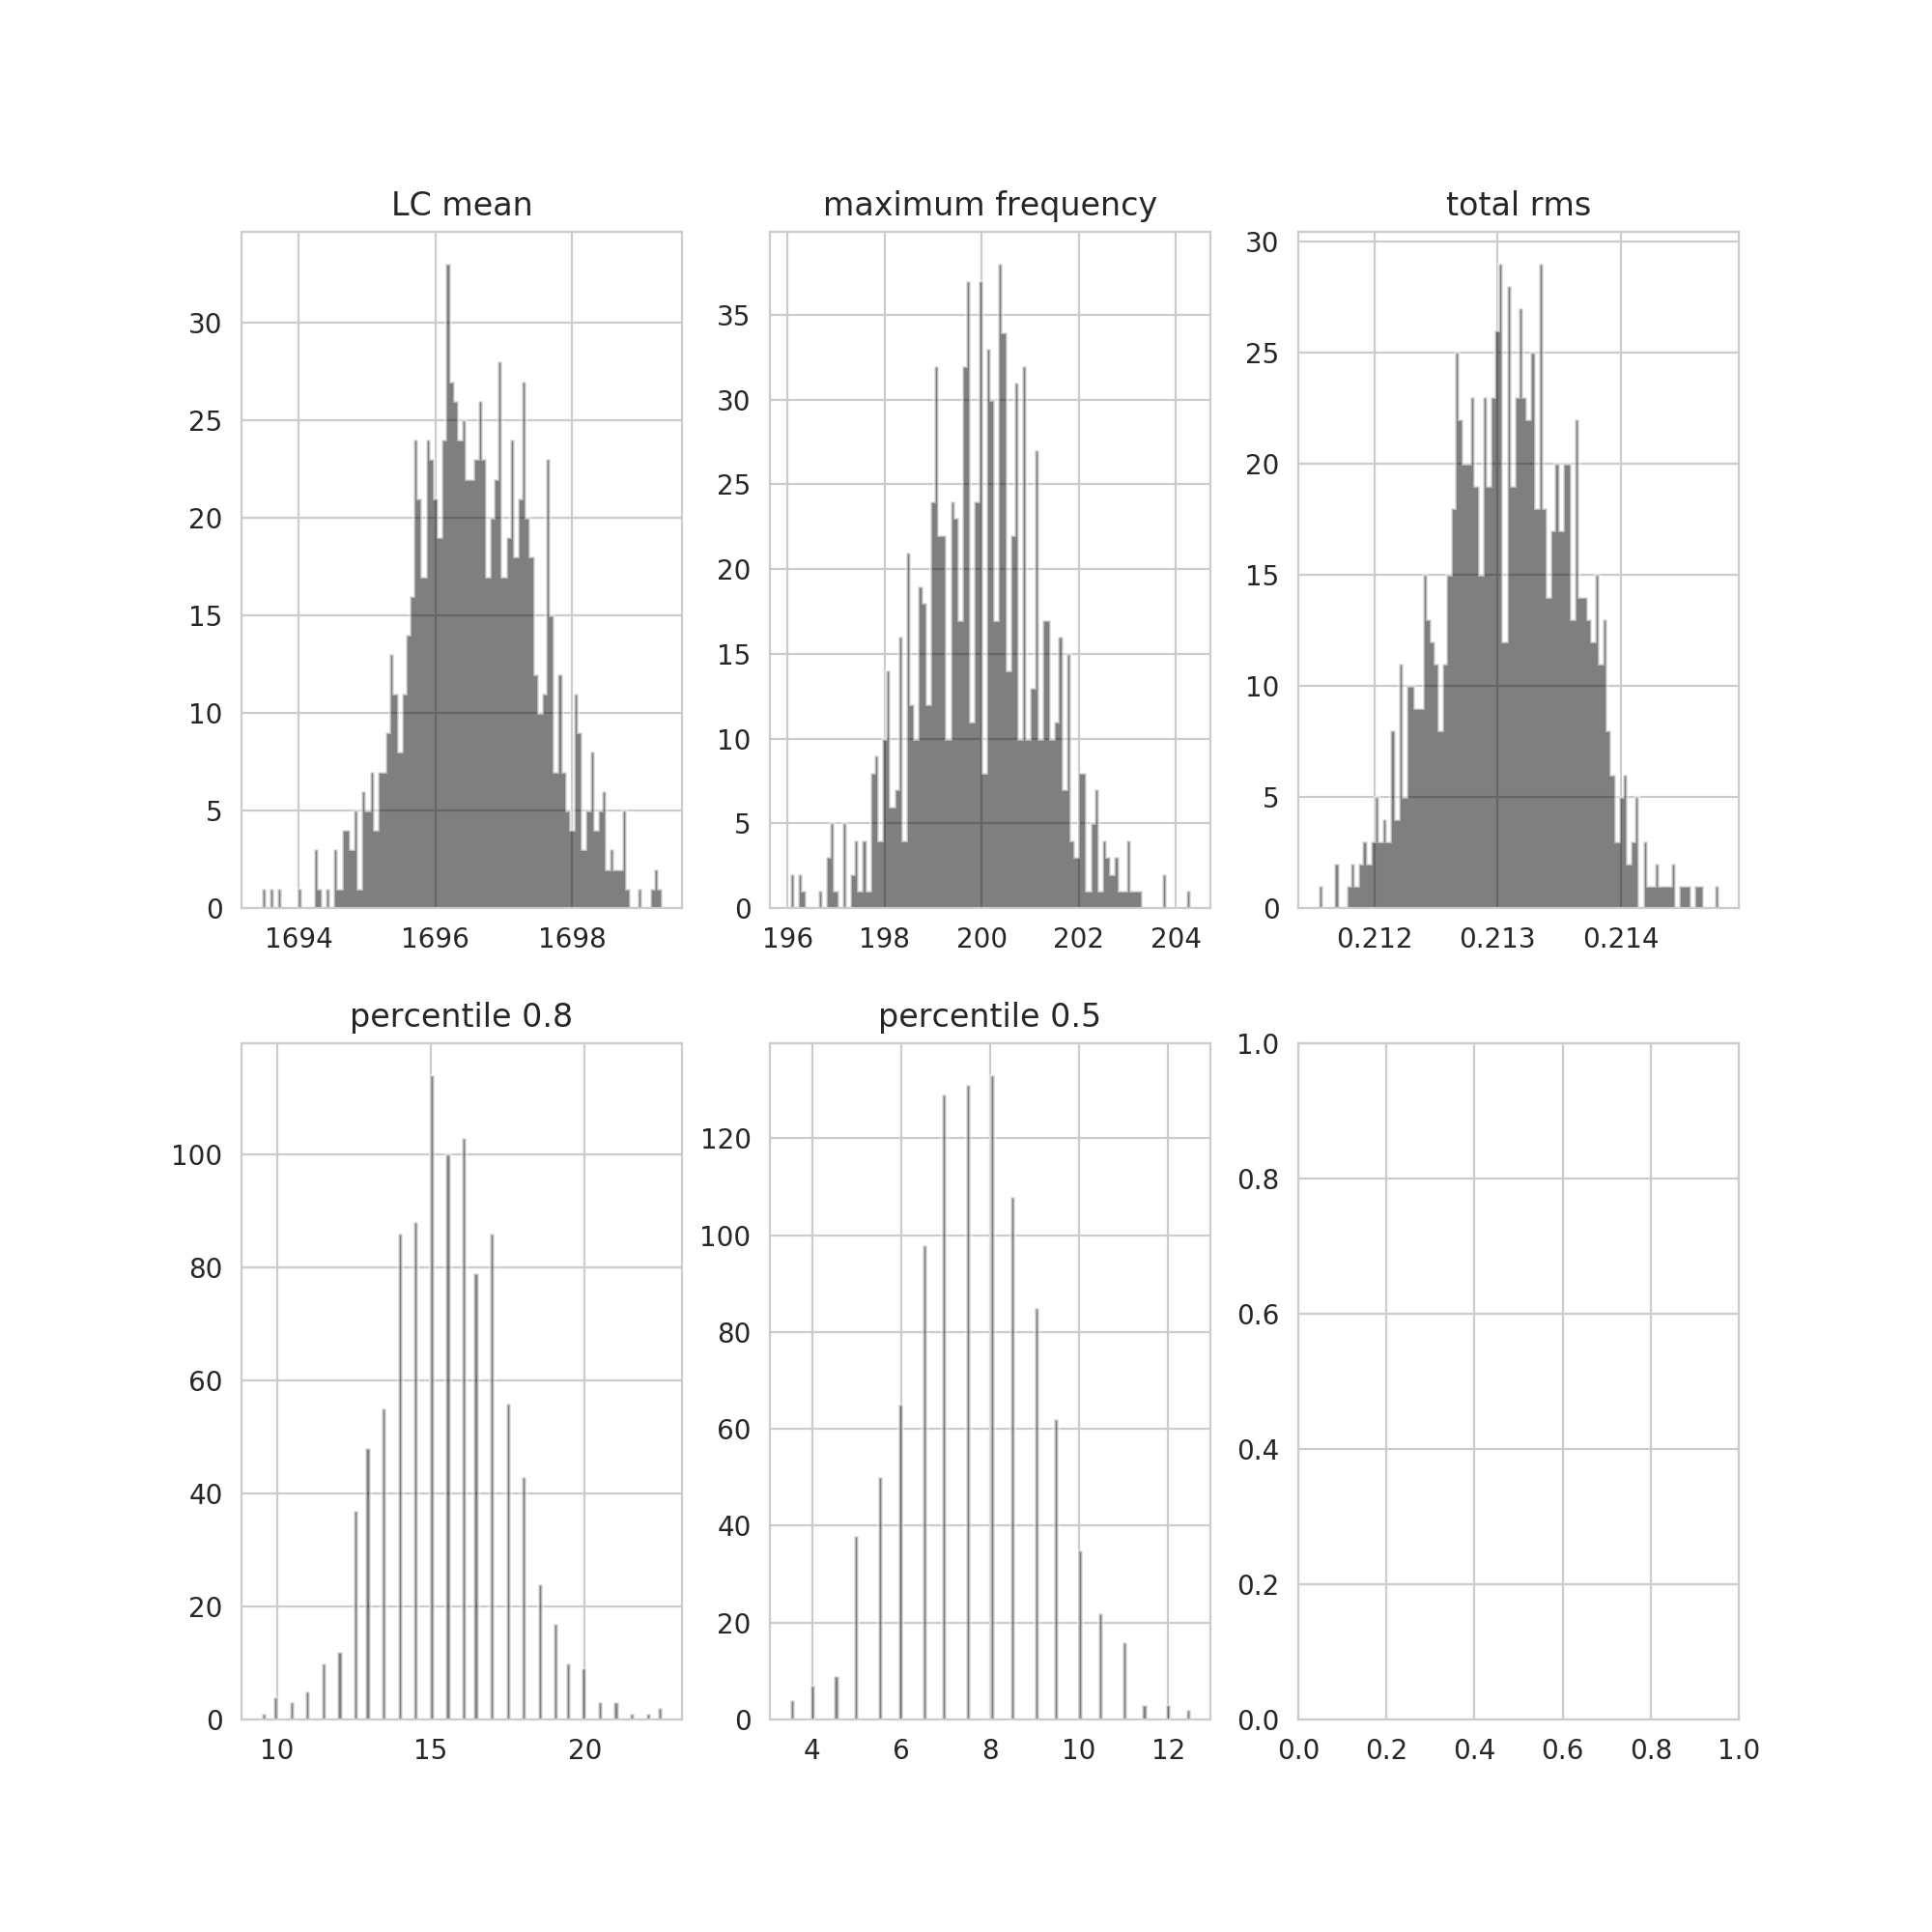

In [127]:
fig, axes = plt.subplots(2, 3, figsize=(10, 10))

axes = np.hstack(axes)

labels = ["LC mean", "maximum frequency",
          "total rms", "percentile 0.8", "percentile 0.5"]

for i in range(true_summaries.shape[1]):
    axes[i].hist(true_summaries[:,i], bins=100, histtype="stepfilled", alpha=0.5, color="black")
    axes[i].set_title(labels[i])

And also plot the distribution of distances:

In [151]:
summary_obs

array([1.99972050e+003, 1.87632651e-299, 2.00238786e-001, 1.90000000e+001,
       1.00000000e+001])

In [154]:
import copy

[1.99972050e+03 2.01050000e+03 2.00238786e-01 1.90000000e+01
 1.00000000e+01]


<IPython.core.display.Javascript object>


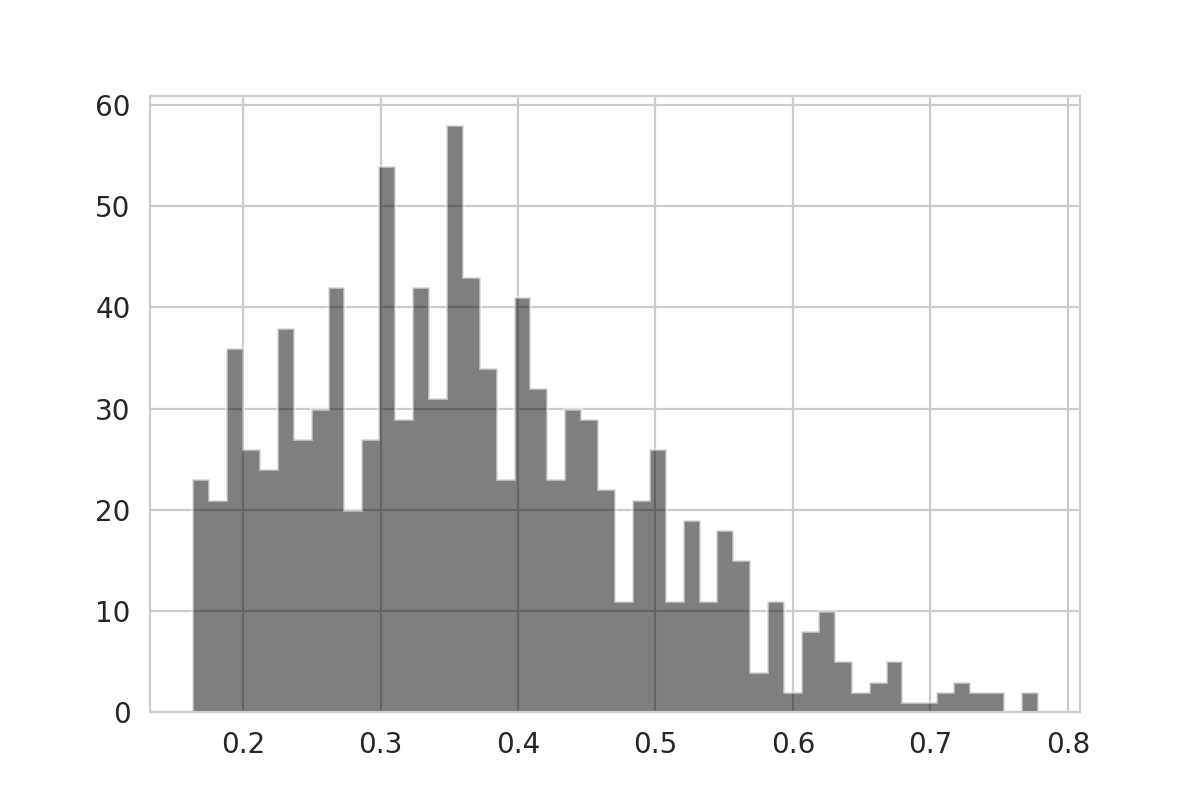

In [162]:

# summaries for the distribution of CSDs generated from the true parameters
euclid_true = []

weights = copy.deepcopy(summary_obs)
weights[1] *= 10

print(weights)

for s in true_summaries:
    euclid_true.append(euclidean_distance(summary_obs, s, weights))

euclid_true = np.array(euclid_true)

# plot the distribution
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.hist(euclid_true, bins=50, histtype="stepfilled", alpha=0.5, color="black");

Let's look at the distributions when the distance is small:

<IPython.core.display.Javascript object>


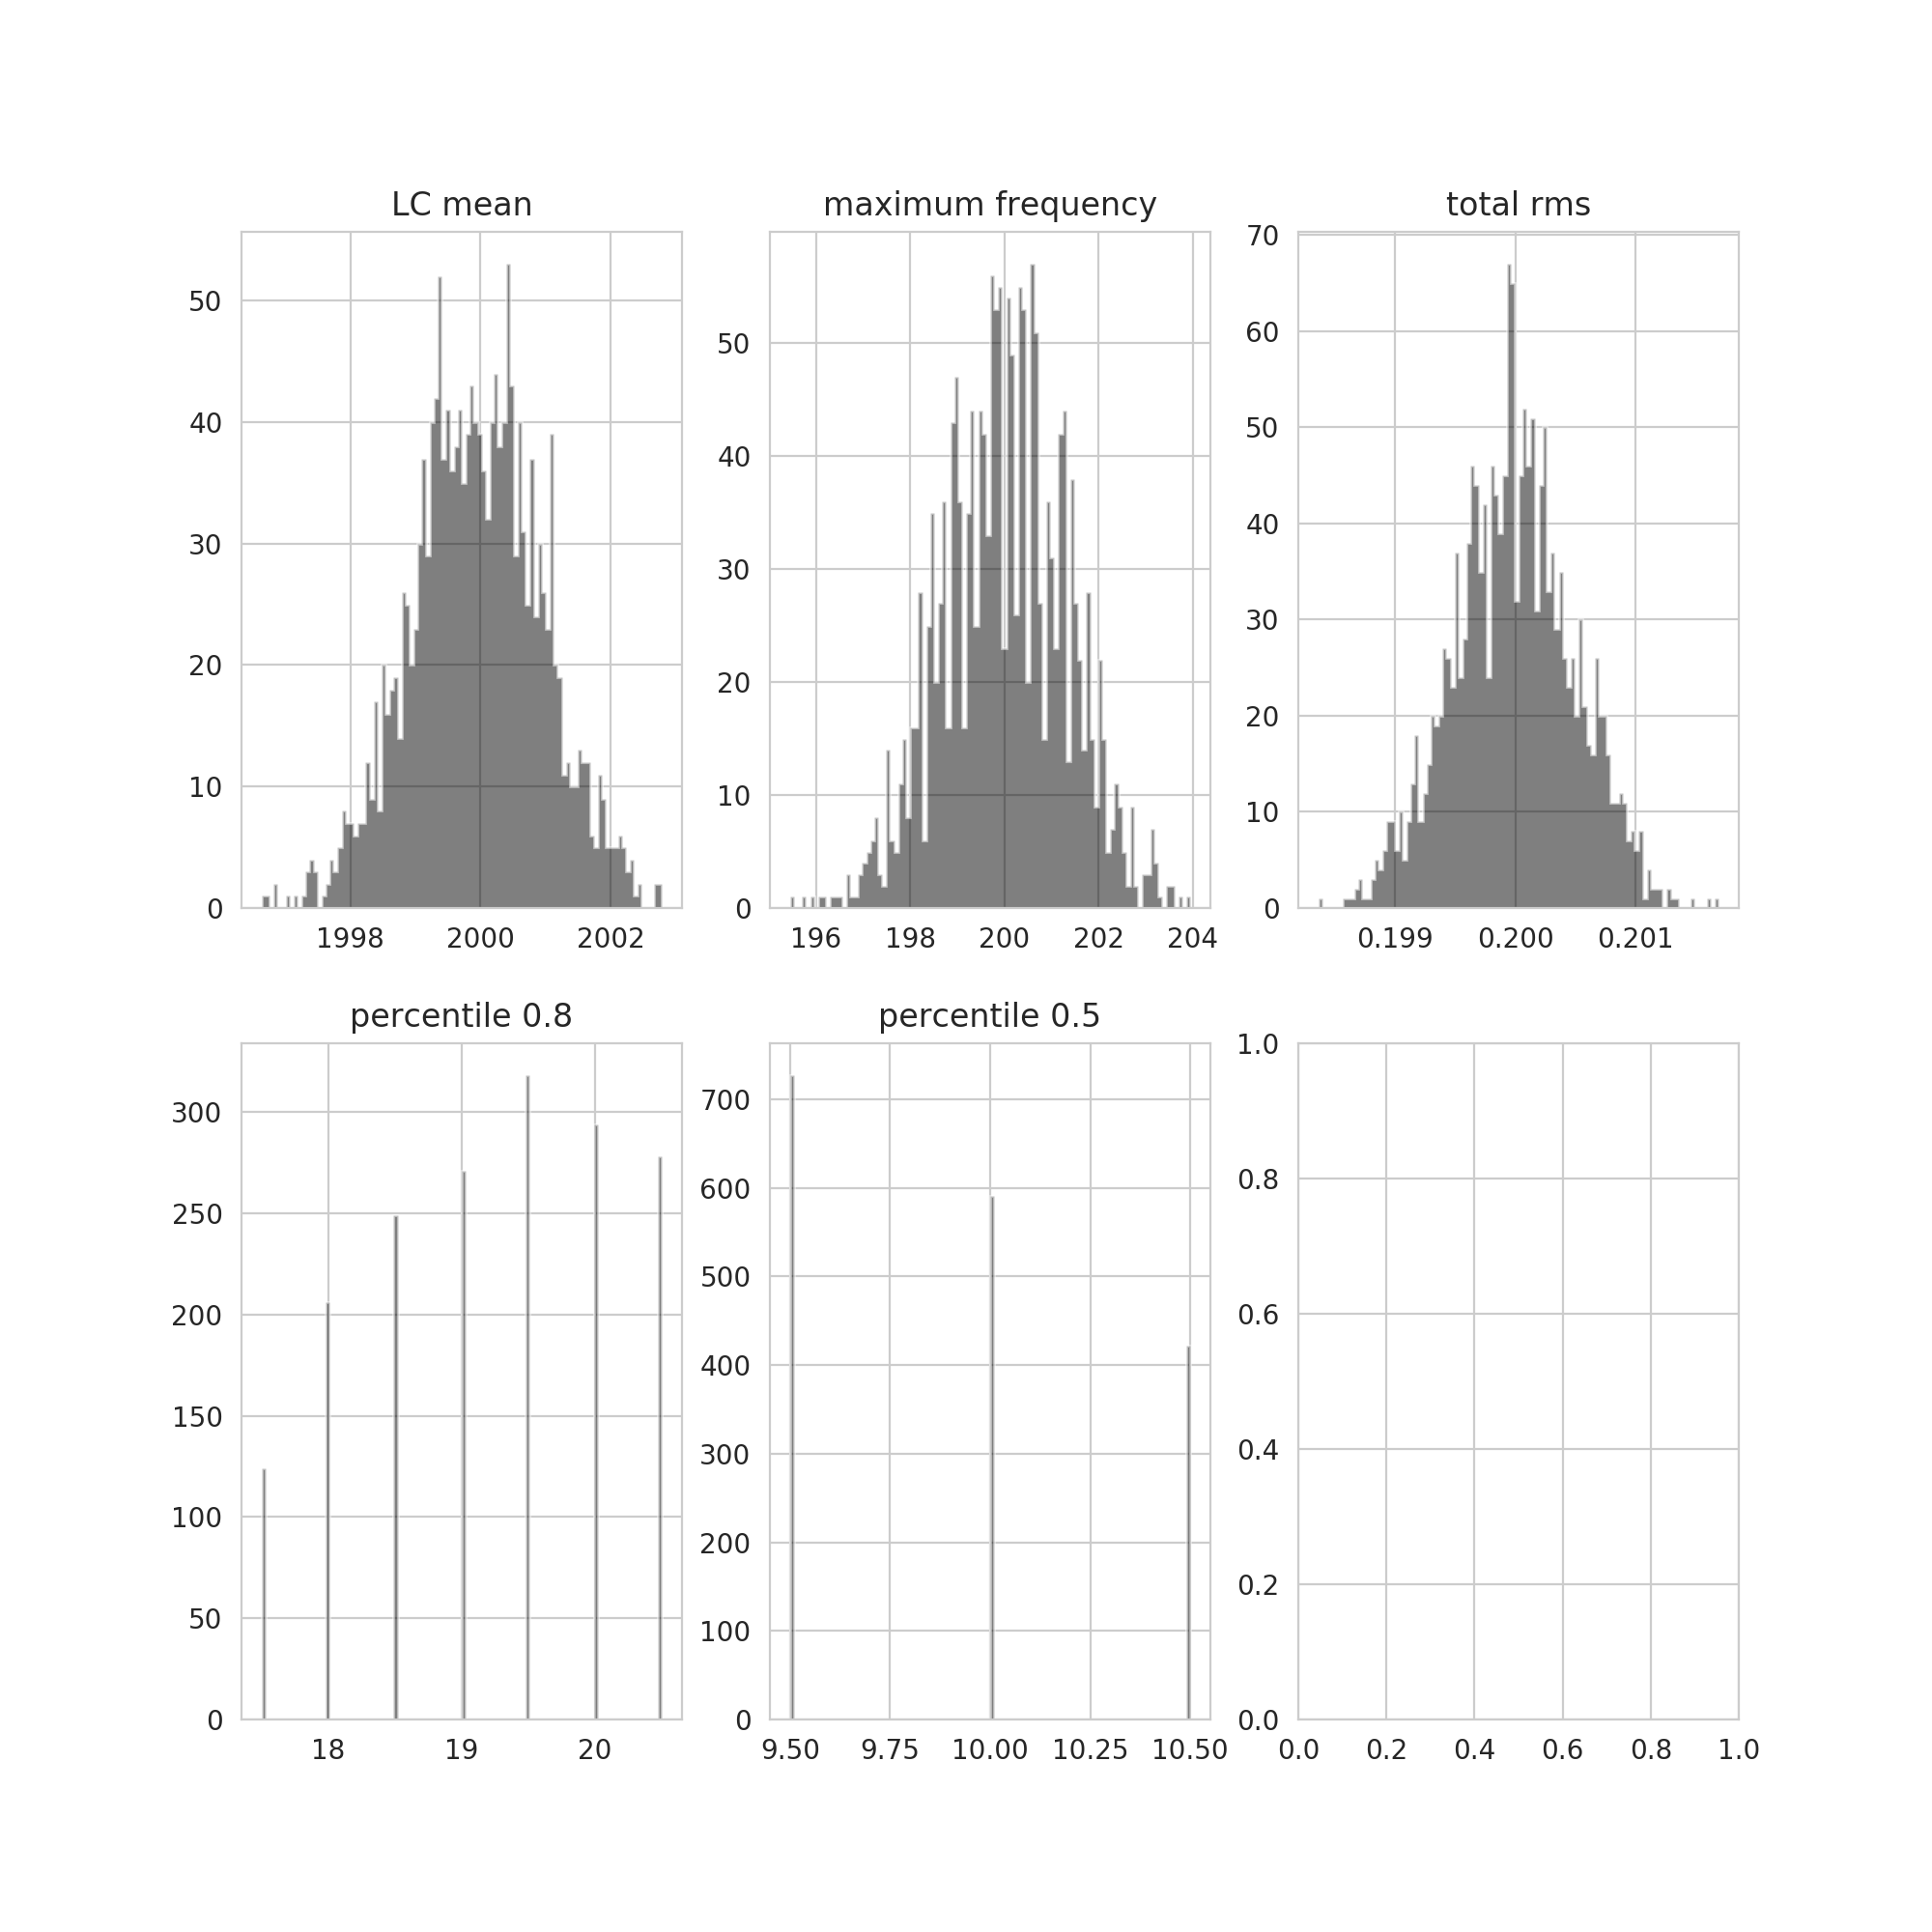

In [91]:
fig, axes = plt.subplots(2, 3, figsize=(10, 10))

axes = np.hstack(axes)

labels = ["LC mean", "maximum frequency",
          "total rms", "percentile 0.8", "percentile 0.5"]

for i in range(true_summaries.shape[1]):
    axes[i].hist(true_summaries[euclid_true <= 0.1,i], bins=100, histtype="stepfilled", alpha=0.5, color="black")
    axes[i].set_title(labels[i])

Now we can do the same for draws from the prior:

In [104]:
nsims = 10000

# generate prior parameters
prior_params = draw_qpo_pars(size=nsims)

# make sure my frequency array is defined correctly
freq = np.linspace(df, fmax, num=npoints//2)

# empty lists for results
lc_sim_prior, ps_sim_prior, cs_sim_prior = [], [], []
summaries_prior = []
euclid_prior = []

# set the random state for reproducibility
rng = np.random.RandomState(3000) 

for i, p in tqdm_notebook(enumerate(prior_params)):
    # make sure all the parameters are defined 
    rms = p[0] # rms is defined in first element of parameter vector
    x0 = p[1] # centroid position is defined in second element of parameter vector
    qual = p[2] # quality factor is defined in third element of parameter vector
    lcmean = p[3]
    fwhm = x0/qual # fwhm is defined as the centroid/quality factor
    amp = 1.0 # the amplitude for the power spectrum is 1
    
    # set parameters in QPO model
    qpo.amplitude = amp
    qpo.x_0 = x0
    qpo.fwhm = fwhm
    
    # calculate the model spectrum
    mspec = qpo(freq)
    
    try:
        # set up the Simulator object.
        sim = Simulator(dt=dt, N=npoints, mean=lcmean, rms=rms, random_state=rng)

        # get a simulated cross spectrum with noise
        data_sim = simulate_csd(sim, mspec)
        
        lc_sim_prior.append(data_sim[0])
        ps_sim_prior.append(data_sim[1])
        cs_sim_prior.append(data_sim[2])

        # compute summaries
        s = compute_qpo_summaries(data_sim)
        summaries_prior.append(s)

        # compute distance:
        d = euclidean_distance(summary_obs, s)
        euclid_prior.append(d)

    except ValueError:
        euclid_prior.append(-1000)
        continue



I want to recalculate the distance with new weights:

In [171]:
# summaries for the distribution of CSDs generated from the true parameters
euclid_prior = []

weights = copy.deepcopy(summary_obs)
weights[1] /= 10
weights[0] /= 10

print(weights)

for s in summaries_prior:
    euclid_prior.append(euclidean_distance(summary_obs, s, weights))

euclid_prior = np.array(euclid_prior)

[199.97205     20.105        0.20023879  19.          10.        ]


In [172]:
euclid_prior = np.array(euclid_prior)
summaries_prior = np.array(summaries_prior)

What do the summaries look like for the prior?

<IPython.core.display.Javascript object>


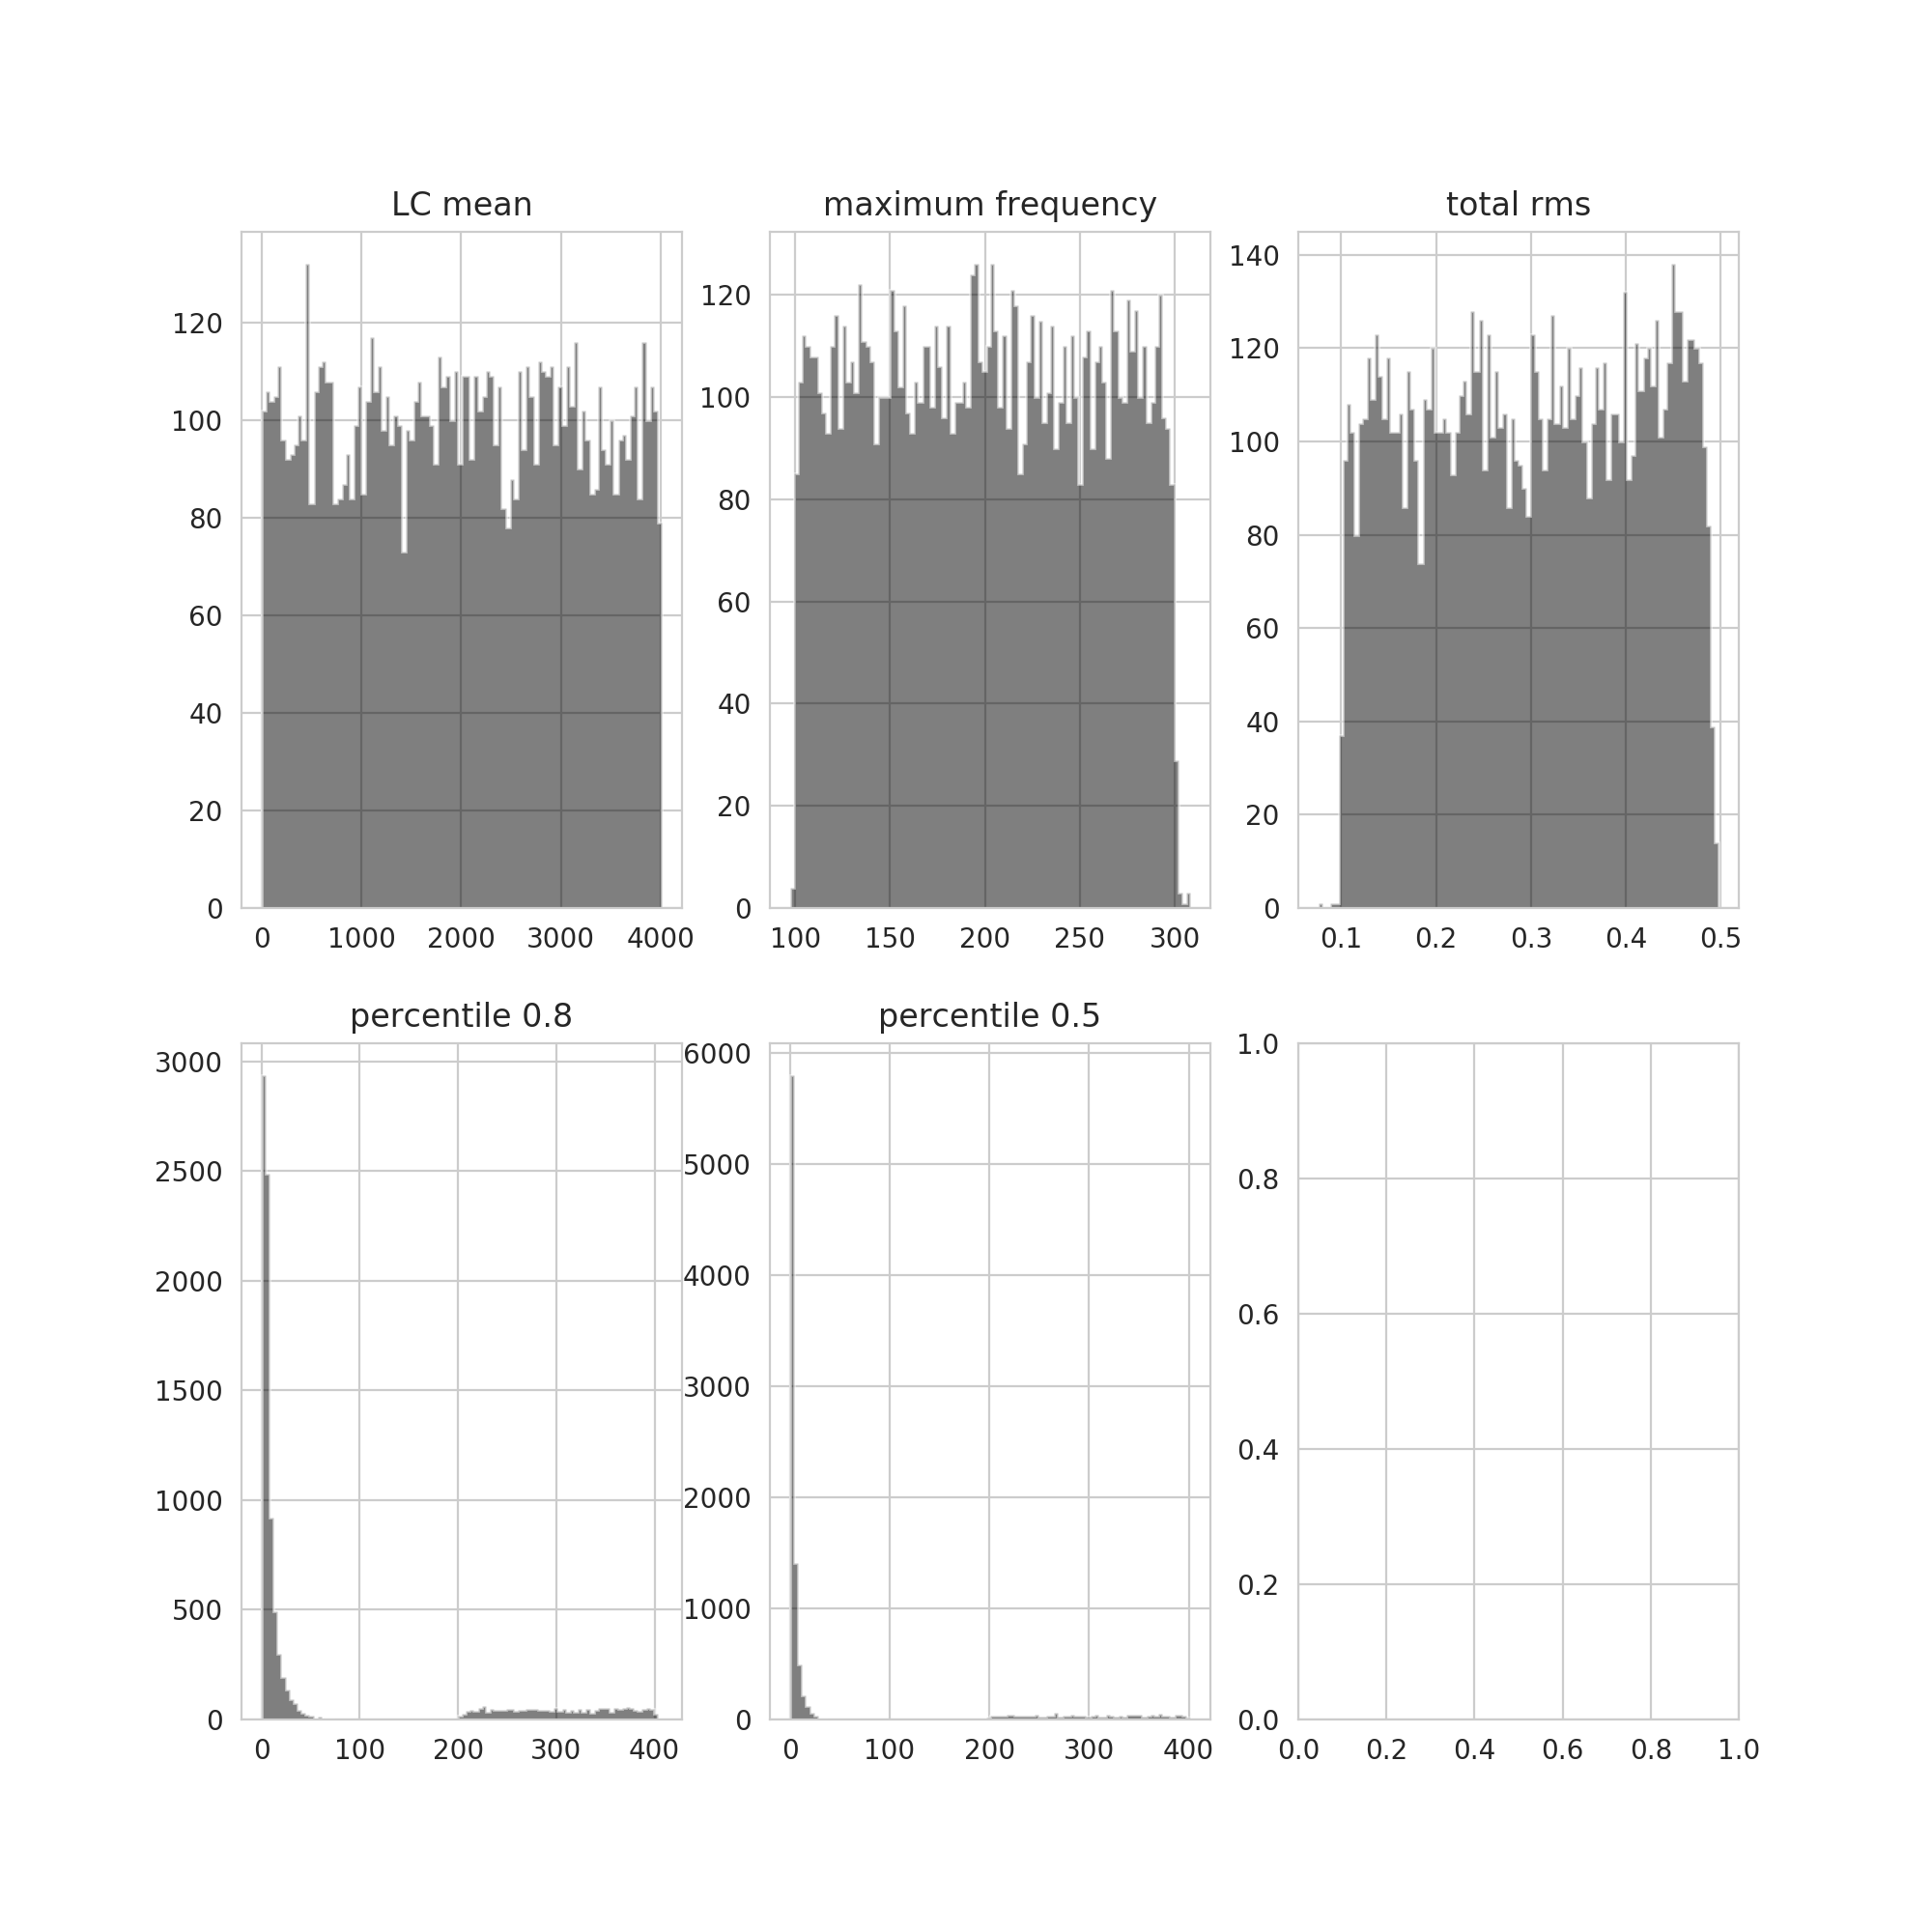

In [173]:
fig, axes = plt.subplots(2, 3, figsize=(10, 10))

axes = np.hstack(axes)

labels = ["LC mean", "maximum frequency",
          "total rms", "percentile 0.8", "percentile 0.5"]

for i in range(summaries_prior.shape[1]):
    axes[i].hist(summaries_prior[:,i], bins=100, histtype="stepfilled", alpha=0.5, color="black")
    axes[i].set_title(labels[i])

Now I can look at the distance versus the values of the parameters:

<IPython.core.display.Javascript object>


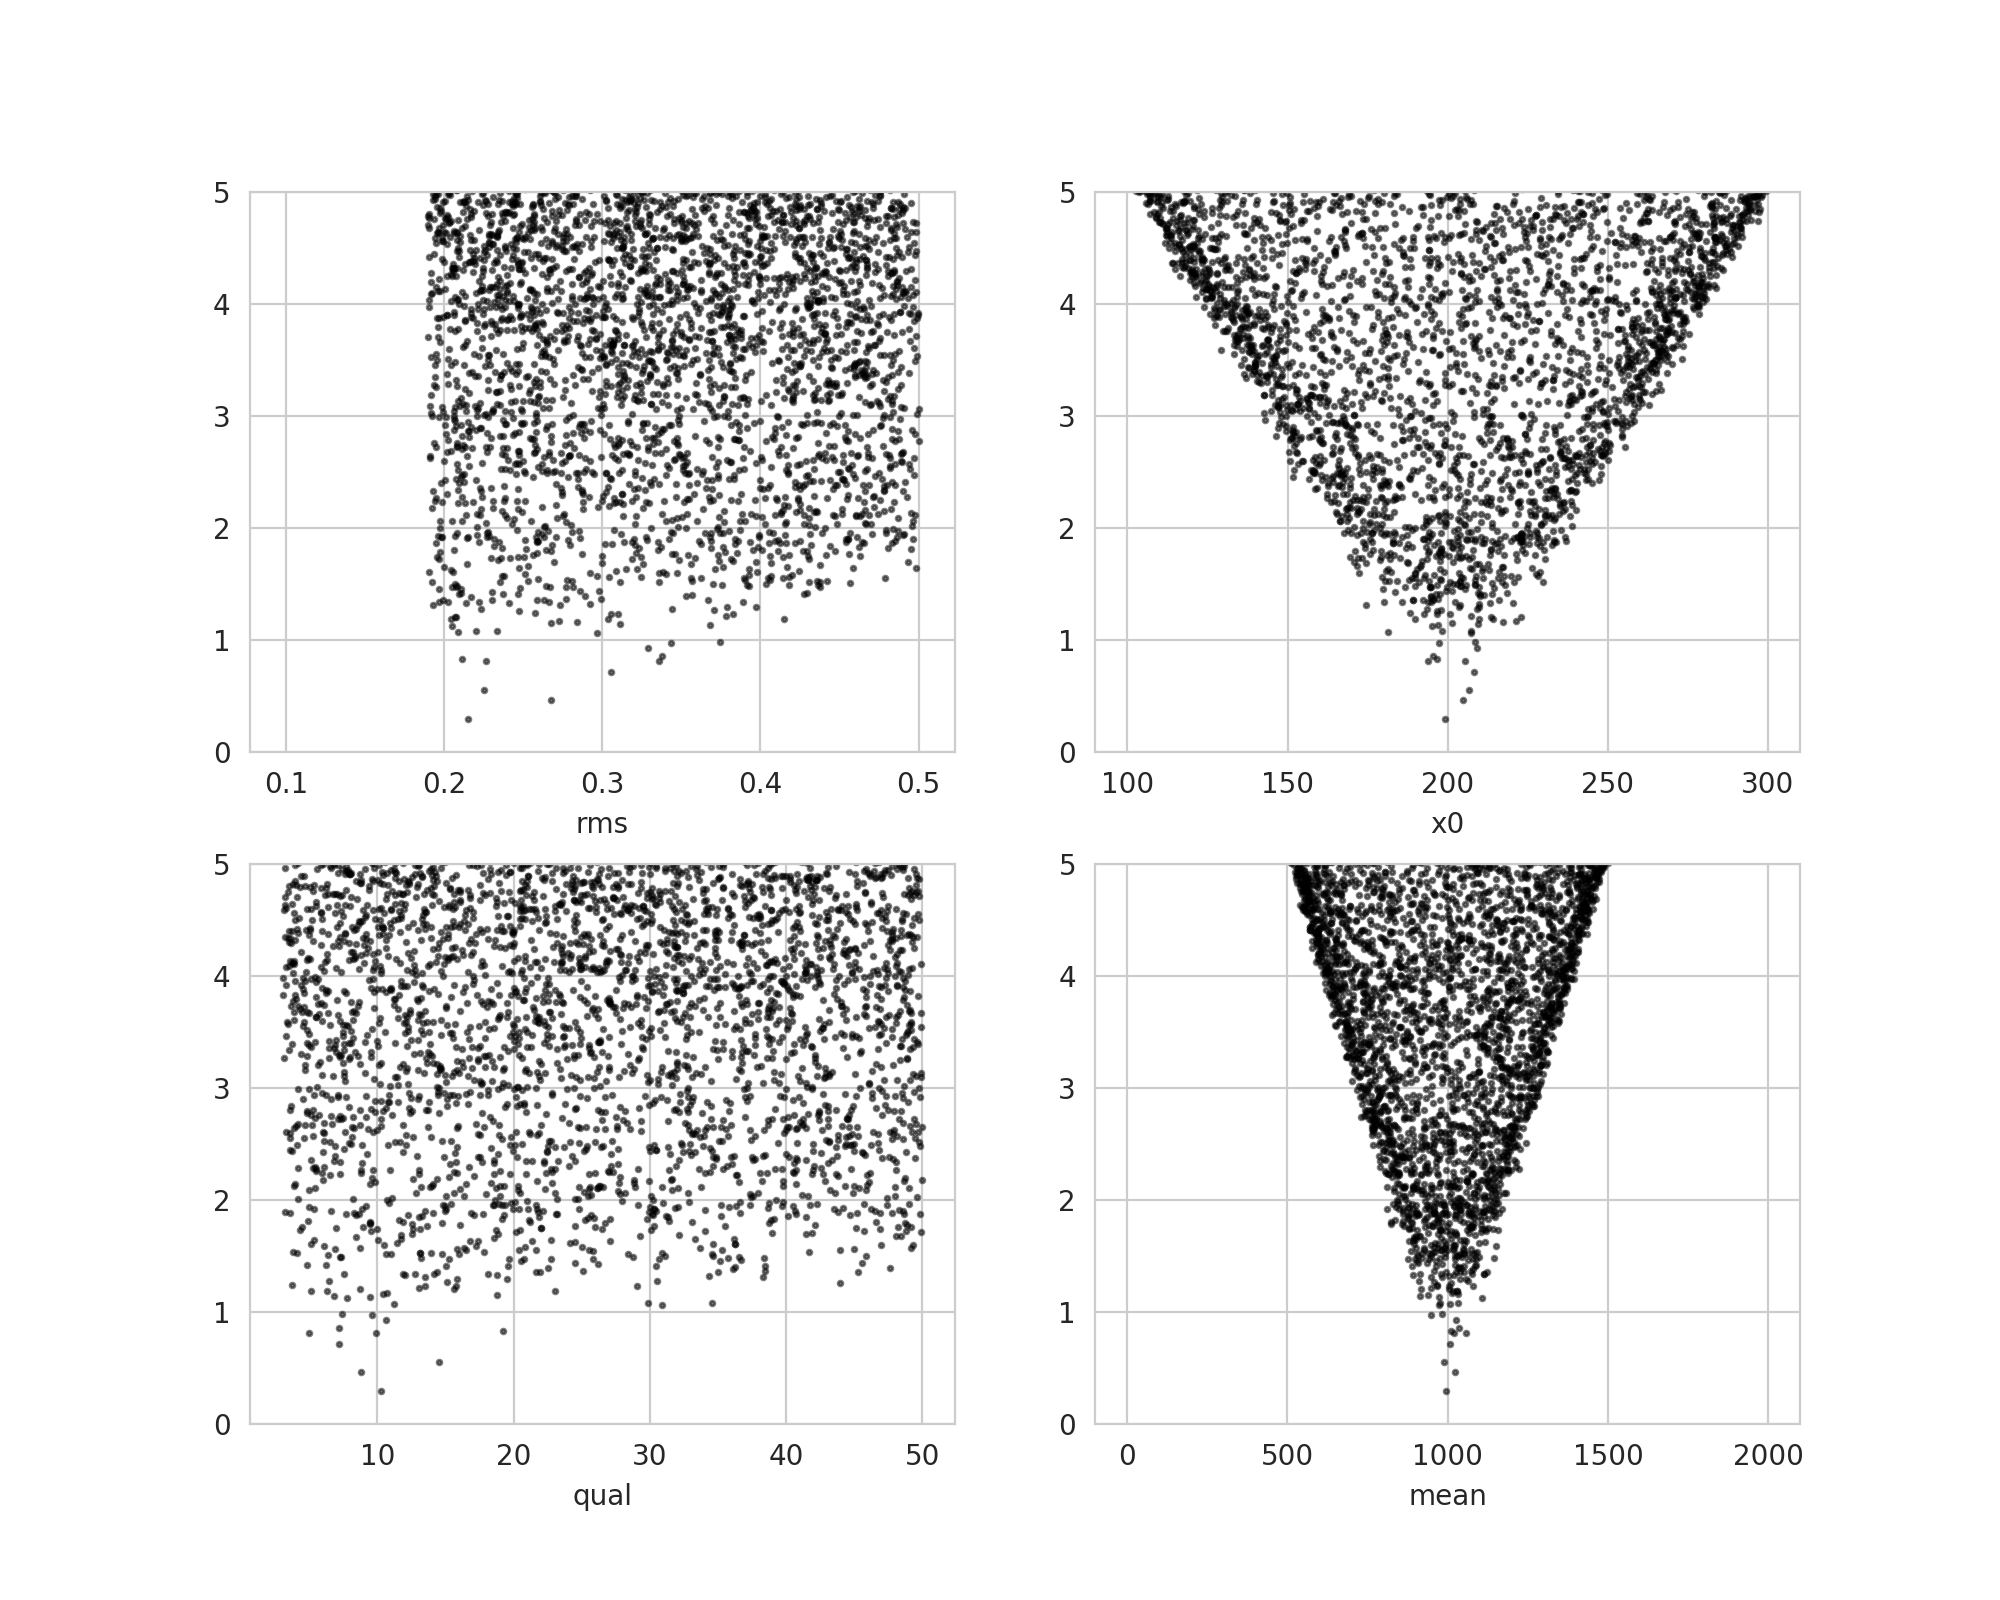

In [176]:
fig, axes= plt.subplots(2, 2, figsize=(10,8))
axes = np.hstack(axes)

# name of the parameters
param_labels = ["rms", "x0", "qual", "mean"]

# limits on y-axis for visibility of important features
ylim = [0, 5]

# plot all parameters
for i in range(4):
    axes[i].scatter(prior_params[euclid_prior >= 0,i], euclid_prior[euclid_prior >= 0], s=3, c="black", alpha=0.5)
    axes[i].set_xlabel(param_labels[i])
    axes[i].set_ylim(*ylim)


Okay, let's redo the sampling, with new weights:

In [197]:
def my_dist(data, sim):
    """
    Distance between observed `data` and simulated data points `sim`
    
    Parameters
    -----------
    data : numpy.ndarray
        Observed data points
        
    sim : numpy.ndarray, of same shape as `data`
        Simulated data points
        
    Returns
    -------
    was : float
        The distance between `data` and `sim`
    """
    weights = copy.deepcopy(data)
    weights[1] /= 10
    weights[0] /= 10
    weights[2] /= 3
    return euclidean_distance(data, sim, weights=weights)

In [198]:
priors = [("uniform", [0.1, 0.5]),
          ("uniform", [100, 300]),
          ("uniform", [3, 50]),
          ("uniform", [500, 2000])
          ]

Now we're ready to set up astroabc:

In [199]:
nparam = 4 # problem currently has 3 parameters: QPO rms, centroid position, fwhm
npart = 600 # number of particles/walkers
niter = 30 # the number of iterations
tlevels = [1.5, 0.01]

prop = {"tol_type":'exp', "verbose":1, "adapt_t":True, 
        "threshold":75 , "pert_kernel": 2, "variance_method": 0,
        "dist_type":'user', "dfunc": my_dist, "restart": "restart_test.txt",
        "outfile": "abc_pmc_output_qpo_withmean_param.txt", "mpi":False, 
        "mp":True, "num_proc":24, "from_restart":False}

sampler = astroabc.ABC_class(nparam,npart,summary_obs,tlevels,niter,priors,**prop)

sampler.sample(simulation)

	 	
	 ########################     astroABC     ########################	
	 	
	 Npart=600 	 numt=30 	 tol=[1.5000,0.0100] exp
	 Priors= [('uniform', [0.1, 0.5]), ('uniform', [100, 300]), ('uniform', [3, 50]), ('uniform', [500, 2000])]
	 Step: 0 	 tol: 1.5 	 Params: [0.22478997136126394, 201.30674014078232, 21.344576024053772, 1001.5230585184363]
	 Step: 1 	 tol: 1.422432464952412 	 Params: [0.2224565960172402, 201.9743321477327, 20.40302713988026, 1003.69820965756]
	 Step: 2 	 tol: 1.32553480346634 	 Params: [0.22026199480619946, 201.49030012739095, 19.10542585012006, 999.4895296147105]
	 Step: 3 	 tol: 1.2280843081241355 	 Params: [0.21706993340719008, 201.56261520094588, 17.578033682271695, 1000.8175202757293]
	 Step: 4 	 tol: 1.1492539179044066 	 Params: [0.2159130020695529, 201.29517563616895, 15.615937151294201, 1001.1440545577467]
	 Step: 5 	 tol: 1.067401205232759 	 Params: [0.21455339867337406, 201.44234276263, 14.056274521619464, 999.5668523597469]
	 Step: 6 	 tol: 0.992855772

What does the output look like?

[ 0 10 20 29]


<IPython.core.display.Javascript object>


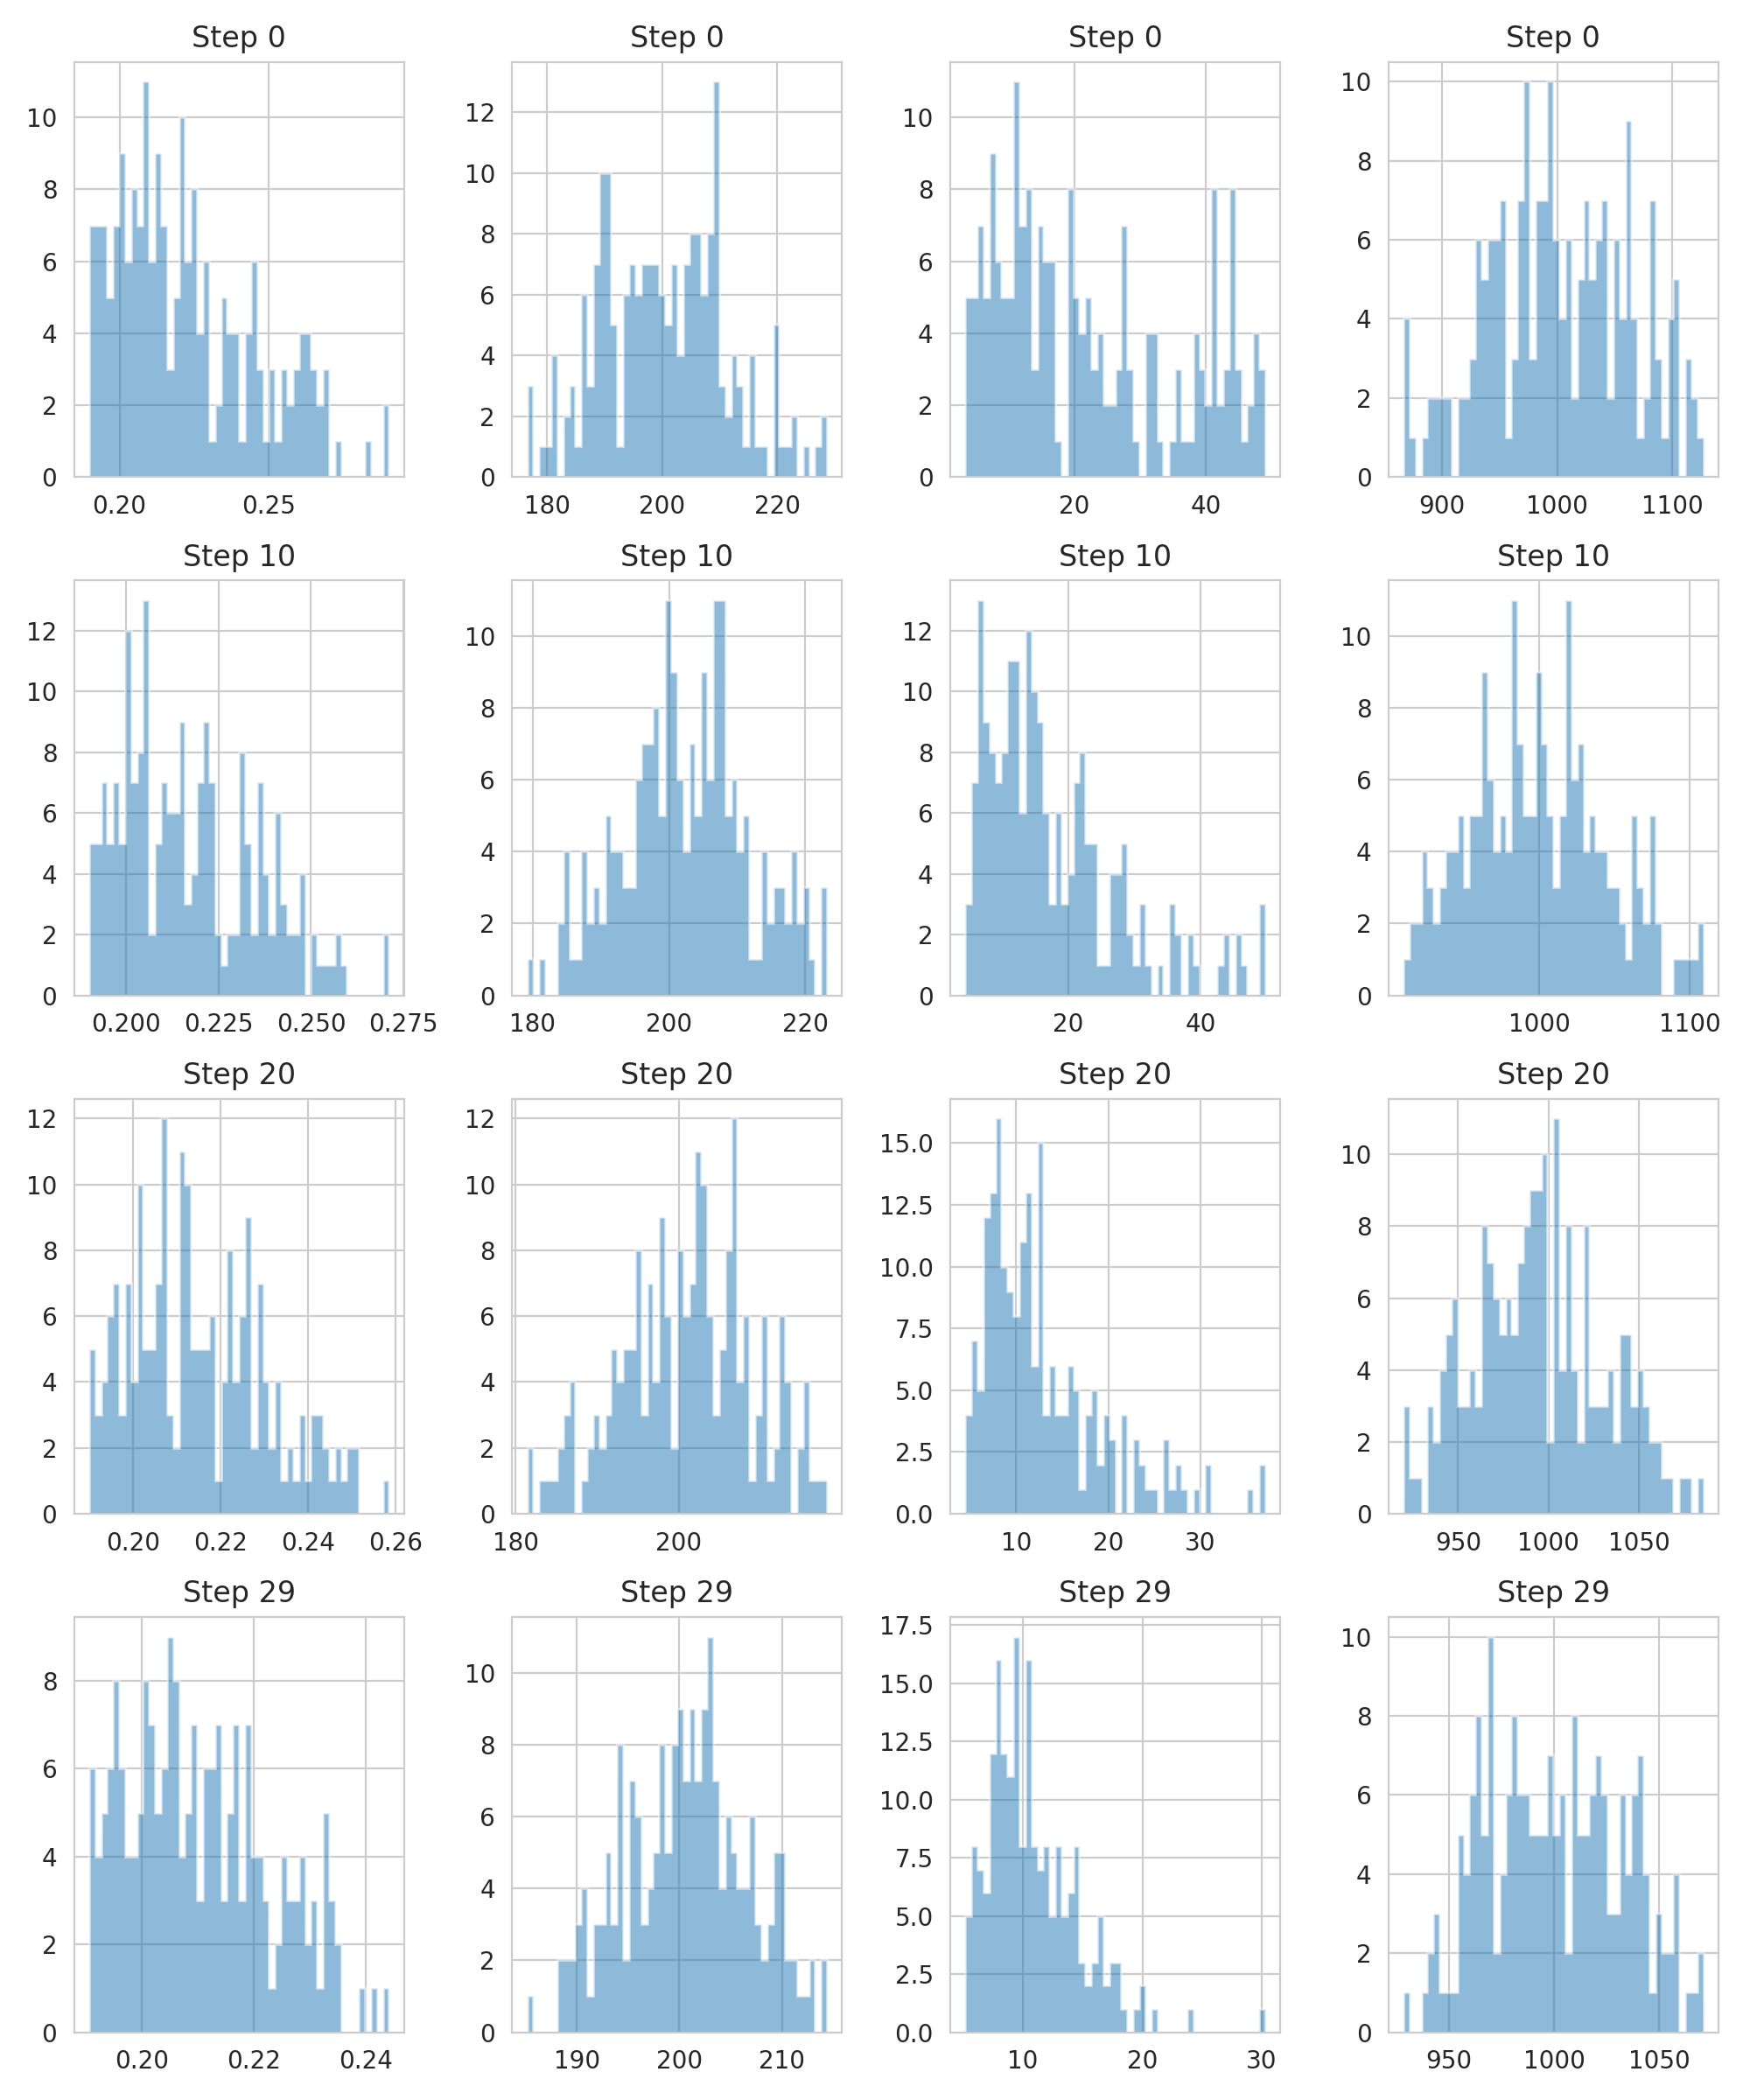

In [200]:
samp = pd.read_csv("abc_pmc_output_qpo_withmean_param.txt", sep="\t", 
                   names=["rms", "x0", "qual", "mean", "dist", "weight"], skiprows=1, index_col=False)
niter_post = samp.shape[0] // npart
idx = np.arange(0, niter_post, 10)

idx = np.hstack([idx, (niter_post)-1])
print(idx)

fig, axes = plt.subplots(len(idx), nparam, figsize=(10, 3*len(idx)))

for i, ax in zip(idx, axes):
    minind = 200*i
    maxind = 200*(i+1)
    samp_iter = samp.loc[minind:maxind]
    for j, par in enumerate(["rms", "x0", "qual", "mean"]):
        ax[j].hist(samp_iter[par], bins=50, histtype="stepfilled", alpha=0.5)
        ax[j].set_title("Step %i"%i)
        
plt.tight_layout()

What do the posterior samples look like?

<IPython.core.display.Javascript object>


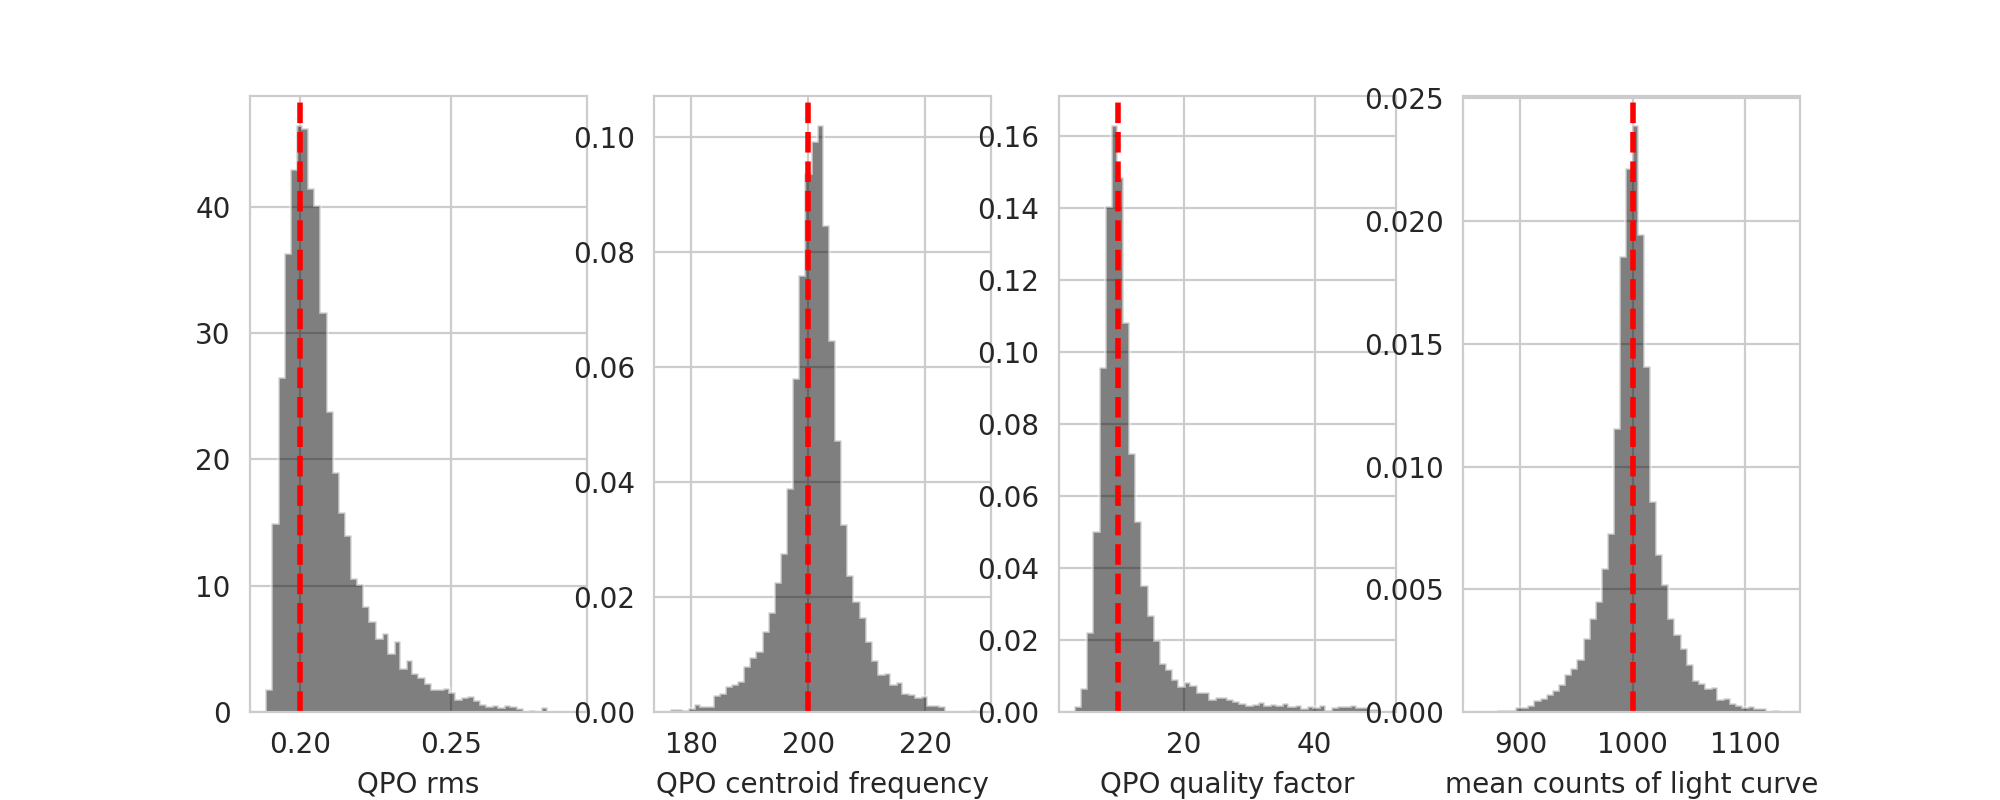

In [201]:
post = samp.sample(n=50000,weights="weight", replace=True, axis=0)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10,4))

ax1.hist(post["rms"], bins=50, histtype="stepfilled", alpha=0.5, color="black", density=True)
ax1.set_xlabel("QPO rms")
ax1.axvline(true_rms, lw=2, color="red", linestyle="dashed")

ax2.hist(post["x0"], bins=50, histtype="stepfilled", alpha=0.5, color="black", density=True)
ax2.set_xlabel("QPO centroid frequency")
ax2.axvline(true_pars[1], lw=2, color="red", linestyle="dashed")

ax3.hist(post["qual"], bins=50, histtype="stepfilled", alpha=0.5, color="black", density=True)
ax3.set_xlabel("QPO quality factor")
ax3.axvline(true_pars[1]/true_pars[2], lw=2, color="red", linestyle="dashed")

ax4.hist(post["mean"], bins=50, histtype="stepfilled", alpha=0.5, color="black", density=True)
ax4.set_xlabel("mean counts of light curve")
ax4.axvline(true_mean, lw=2, color="red", linestyle="dashed")

Okay, so I think I can use the weights to figure out how well I want to be able to estimate different parameters. That's useful to know. :) 

## Adding Dead Time

Time to add some sweet, sweet dead time to the problem! 